In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

import imageio
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm
matplotlib.style.use('ggplot')

/Users/sennedirkx/.local/share/virtualenvs/src-3aXnpWCD/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ZeldaLevelDataset(Dataset):
    """Zelda Game levels dataset."""

    def __init__(self, data_dir):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_dir = data_dir
        self.levels = self.load_levels()

    def __len__(self):
        return len(self.levels)

    def __getitem__(self, idx):
        return self.levels[idx]
    
    def load_levels(self):
        levels = []
        directory = os.fsencode(self.data_dir)
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.endswith(".pt"): 
                level = torch.load(self.data_dir + '/' + filename).float()
                levels.append(level)
        return levels
                
        

In [3]:
#transform = transforms.Compose([
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5,),(0.5,)),
#])
to_pil_image = transforms.ToPILImage()
train_data = ZeldaLevelDataset('./data/tensorizedConv/')
print("data size", len(train_data))

data size 459


In [4]:
# learning parameters
no_cuda = False
batch_size = 16
epochs = 10000
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
seed = 2020
temperature = 1.0
hard = False
categorical_dim = 10
k = 1 # number of steps to apply to the discriminator
is_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
torch.manual_seed(seed)
if is_cuda:
    torch.cuda.manual_seed(seed)

In [5]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)


In [7]:
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    if is_cuda:
        U = U.cuda()
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature, hard=False):
    """
    ST-gumple-softmax
    input: [*, n_class]
    return: flatten --> [*, n_class] an one-hot vector
    """
    permuted_logits = logits.permute(0,2,3,1)
    permuted_y = gumbel_softmax_sample(permuted_logits, temperature)
    #if not hard:
    #    return y.view(-1, nz * categorical_dim)
    
    shape = permuted_y.size()
    _, ind = permuted_y.max(dim=-1)
    y_hard = torch.zeros_like(permuted_y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    # Set gradients w.r.t. y_hard gradients w.r.t. y
    y_hard = (y_hard - permuted_y).detach() + permuted_y
    y_final = y_hard.permute(0,3,1,2)
    return y_final#.view(-1, latent_dim * categorical_dim)

In [8]:
# testing
print(iter(train_loader).next().shape)

torch.Size([16, 10, 16, 11])


In [9]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 1760),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 16, 110)
    
class GeneratorConv(nn.Module):
    def __init__(self, nz, temp):
        super(GeneratorConv, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.ConvTranspose2d(self.nz, 64, (3,2), 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, 16, (3,2), 2, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(16, 10, (4,2), 1, bias=False),
            #nn.Tanh()
        )

    def forward(self, x, temp, hard):
        x = self.main(x)
        x = gumbel_softmax(x, temp, hard)
        return x

In [43]:
generator = GeneratorConv(nz, temperature).to(device)
#generator.apply(weights_init)
print(generator)

GeneratorConv(
  (main): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 2), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 16, kernel_size=(3, 2), stride=(2, 2), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(16, 10, kernel_size=(4, 2), stride=(1, 1), bias=False)
  )
)


In [44]:
# CONV shape tests
test_level = torch.rand(1, 10, 16, 11)

conv1 = nn.Conv2d(10, 32, 4, 1, bias=False)
conv2 = nn.Conv2d(32, 48, 4, 1, bias=False)
conv3 = nn.Conv2d(48, 64, 4, 1, bias=False)
flatt = nn.Flatten()
lin1 = nn.Linear(64*7*2, 128)
print("dis")
x = conv1(test_level)
print(x.shape)
x = conv2(x)
print(x.shape)
x = conv3(x)
print(x.shape)
x = flatt(x)
print(x.shape)
x = lin1(x)
print(x.shape)

print("gen")
test_latent = torch.rand(1, 128, 4, 4)
deconv1 = nn.ConvTranspose2d(128, 64, (3,2), 1, bias=False)
deconv2 = nn.ConvTranspose2d(64, 16, (3,2), 2, bias=False)
deconv3 = nn.ConvTranspose2d(16, 10, (4,2), 1, bias=False)
y = deconv1(test_latent)
print(y.shape)
y = deconv2(y)
print(y.shape)
y = deconv3(y)
print(y.shape)

dis
torch.Size([1, 32, 13, 8])
torch.Size([1, 48, 10, 5])
torch.Size([1, 64, 7, 2])
torch.Size([1, 896])
torch.Size([1, 128])
gen
torch.Size([1, 64, 6, 5])
torch.Size([1, 16, 13, 10])
torch.Size([1, 10, 16, 11])


In [45]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 1760
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 2048),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 1760)
        return self.main(x)

class DiscriminatorConv(nn.Module):
    def __init__(self):
        super(DiscriminatorConv, self).__init__()
        self.main = nn.Sequential(
            # input is B x C x H x W
            # B = 16, C = 10, H = 16, W = 11
            nn.Conv2d(10, 32, 4, 1, bias=False),
            # output:
            # B = 16, C = 32, H = (in+2P-k)/S + 1 = (16+0-4)/1 + 1 = 13, W = (in+2P-k)/S + 1 = (11+0-4)/1 + 1 = 8
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 1, bias=False),
            # output:
            # B = 16, C = 32, H = (in+2P-k)/S + 1 = (13+0-4)/1 + 1 = 10, W = (in+2P-k)/S + 1 = (8+0-4)/1 + 1 = 5
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 1, bias=False),
            # output:
            # B = 16, C = 1, H = (in+2P-k)/S + 1 = (10+0-4)/2 + 1 = 7, W = (in+2P-k)/S + 1 = (5+0-4)/2 + 1 = 2
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128*7*2, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [46]:
discriminator = DiscriminatorConv().to(device)
#discriminator.apply(weights_init)
print(discriminator)

DiscriminatorConv(
  (main): Sequential(
    (0): Conv2d(10, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=1792, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=16, bias=True)
    (13): ReLU()
    (14): Linear(in_features=16, out_features=1, bias=True)
    (15): Sigmoid()
  )
)


In [47]:

temp_min = 0.5
ANNEAL_RATE = 0.00003
if is_cuda:
    generator.cuda()
    discriminator.cuda()

In [48]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz, 4, 4).to(device)

In [49]:
from pysdd.sdd import Vtree, SddManager
from pathlib import Path
current_folder = globals()['_dh'][0]

def import_sdd(name):
    vtree_file = "./" + name + ".vtree"
    vtree = Vtree.from_file(vtree_file)
    manager = SddManager.from_vtree(vtree)
    root = manager.read_sdd_file(bytes(Path(current_folder) / (name + ".sdd")))
    return root

def create_computation_graph(root, vars):
    shape = vars[1].shape
    if not root.is_decision():
        if root.is_literal():
            if root.literal < 0:
                return torch.ones(shape, requires_grad=True) - vars[abs(root.literal)]
            else:
                return vars[root.literal]
        elif root.is_false():
            return torch.zeros(shape, requires_grad=True)
        elif root.is_true():
            return torch.ones(shape, requires_grad=True)
        else:
            return "BRUH"
    else:
        sum = torch.zeros(shape, requires_grad=True)
        for elem in root.elements():
            sum = torch.add(sum, torch.mul(create_computation_graph(elem[0], vars), create_computation_graph(elem[1], vars)))
        return sum

def satisfaction(output):
    sdd = import_sdd("constraints/basic_constraint")
    #print(traverse_tree(sdd))
    #print(analyze_tree_with_vars(sdd, [0, 1, 1, 1, 1] + [0, 0, 0, 1]))
    door_left = torch.prod(output[:, 6, 7:9, 0], 1)
    door_right = torch.prod(output[:, 6, 7:9, 10], 1)
    door_top = torch.prod(output[:, 6, 0, 4:7], 1)
    door_bottom = torch.prod(output[:, 6, 15, 4:7], 1)
    
    wall_left = torch.prod(output[:, 8, :, 0], 1)
    wall_right = torch.prod(output[:, 8, :, 10], 1)
    wall_top = torch.prod(output[:, 8, 0, :], 1)
    wall_bottom = torch.prod(output[:, 8, 15, :], 1)
    
    batch_size = output.shape[0]
    eps = 1e-7
    
    constraint_vals = [None, door_left, door_right, door_top, door_bottom, wall_left, wall_right, wall_top, wall_bottom]
    loss = create_computation_graph(sdd, constraint_vals)
    loss = torch.sum(loss)/batch_size + eps
    return loss
    
    
def semantic_loss(output):
    loss = satisfaction(output)
    loss = -torch.log(loss)
    return loss

In [50]:
gan_criterion = nn.BCELoss()
sl_lambda = 1.5
def can_loss(output, target, level=None):
    #print("output", output)
    #print("target", target)
    
    loss = gan_criterion(output, target)
    
    if level is not None:
        #print("gan loss", loss)
        loss = torch.add(loss, sl_lambda * semantic_loss(level))
        #print("+ semantic loss", loss)
    
    return loss
    

In [51]:
rnd = torch.rand(64, 10, 16, 11)
out = (rnd>0.2).float()
result_loss = torch.sum(semantic_loss(out))
print(result_loss)
result_loss.backward()

tensor(4.1589, grad_fn=<SumBackward0>)


In [52]:
#criterion = nn.BCEWithLogitsLoss()
criterion = can_loss

losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator
sat = []

# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.00005)
optim_d = optim.Adam(discriminator.parameters(), lr=0.00005)

real_label = 1.
fake_label = 0.

# create the noise vector
noise = create_noise(64, nz)

In [53]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [54]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [55]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [56]:
# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label, data_fake)
    loss.backward()
    optimizer.step()
    return loss

In [57]:
def transform_to_image_format(level):
    colorR = torch.tensor([0.69,0.3, 0.8,0,   0.06,0.08,0.52,0.3, 0.26,0])
    colorG = torch.tensor([0.69,1,   0,  0.14,0.12,0.94,0.13,0.52,0.14,0])
    colorB = torch.tensor([0.69,1,   0.1,0.8 ,0.35,0.33,0.08,0.08,0.31,0])
    
    colorMap = torch.tensor([[0.69,0.3, 0.8,0,   0.06,0.08,0.52,0.3, 0.26,0],
                            [0.69,1,   0,  0.14,0.12,0.94,0.13,0.52,0.14,0],
                            [0.69,1,   0.1,0.8 ,0.35,0.33,0.08,0.08,0.31,0]]).transpose(0,1)
    permuted_level = level.permute(0,2,3,1)
    
    colored_permuted_level = torch.matmul(permuted_level,colorMap)
    colored_level = colored_permuted_level.permute(0,3,1,2)
    
    return colored_level

In [58]:
t1 = torch.rand(64,10,16,11)
t1p = t1.permute(0,2,3,1)
print(t1p.shape)
t2 = torch.rand(10,3)
t = torch.matmul(t1p,t2)
print(t.shape)
tp = t.permute(0,3,1,2)
print(tp.shape)

torch.Size([64, 16, 11, 10])
torch.Size([64, 16, 11, 3])
torch.Size([64, 3, 16, 11])


In [59]:
generator.train()
discriminator.train()

DiscriminatorConv(
  (main): Sequential(
    (0): Conv2d(10, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=1792, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=16, bias=True)
    (13): ReLU()
    (14): Linear(in_features=16, out_features=1, bias=True)
    (15): Sigmoid()
  )
)

In [60]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    temp = temperature
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        level = data
        level = level.to(device)
        b_size = len(level)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz), temp, hard).detach()
            data_real = level
            # train the discriminator network
            
            loss_d += train_discriminator(optim_d, data_real, data_fake)
            #print(loss_d)
        data_fake = generator(create_noise(b_size, nz), temp, hard)
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
        if bi % 100 == 1:
            temp = np.maximum(temp * np.exp(-ANNEAL_RATE * bi), temp_min)
        #print(loss_d)
    # create the final fake image for the epoch
    generated_level = generator(noise, temp, hard).cpu().detach()
    # make the images as grid
    #generated_level = transform_to_image_format(generated_level)
    #generated_level = make_grid(generated_level)
    # save the generated torch tensor models to disk
    #save_generator_image(generated_level, f"./outputs/gen_img{epoch}.png")
    images.append(generated_level)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    if epoch > 1 and epoch_loss_g < losses_g[-1]:
        torch.save(generator.state_dict(), f'./outputs/generators/v1_conv_gumbel/generator{epoch}.pth')
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    sat.append(satisfaction(generated_level))
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

29it [00:01, 17.81it/s]                                                                      


Epoch 0 of 10000
Generator loss: 25.67294884, Discriminator loss: 1.38244259


29it [00:01, 19.32it/s]                                                                      


Epoch 1 of 10000
Generator loss: 25.88876534, Discriminator loss: 0.97231436


29it [00:01, 20.74it/s]                                                                      


Epoch 2 of 10000
Generator loss: 27.30676079, Discriminator loss: 0.23052499


29it [00:01, 19.96it/s]                                                                      


Epoch 3 of 10000
Generator loss: 29.52039146, Discriminator loss: 0.02361599


29it [00:01, 20.03it/s]                                                                      


Epoch 4 of 10000
Generator loss: 30.56909370, Discriminator loss: 0.00790489


29it [00:01, 19.85it/s]                                                                      


Epoch 5 of 10000
Generator loss: 31.17583656, Discriminator loss: 0.00454862


29it [00:02, 10.69it/s]                                                                      


Epoch 6 of 10000
Generator loss: 31.63233757, Discriminator loss: 0.00302668


29it [00:03,  8.15it/s]                                                                      


Epoch 7 of 10000
Generator loss: 31.97957039, Discriminator loss: 0.00216529


29it [00:02, 13.66it/s]                                                                      


Epoch 8 of 10000
Generator loss: 32.26696396, Discriminator loss: 0.00155853


29it [00:01, 21.06it/s]                                                                      


Epoch 9 of 10000
Generator loss: 32.59683609, Discriminator loss: 0.00124802


29it [00:01, 19.64it/s]                                                                      


Epoch 10 of 10000
Generator loss: 32.75272369, Discriminator loss: 0.00100352


29it [00:01, 17.47it/s]                                                                      


Epoch 11 of 10000
Generator loss: 33.00037384, Discriminator loss: 0.00084487


29it [00:01, 20.65it/s]                                                                      


Epoch 12 of 10000
Generator loss: 33.13824463, Discriminator loss: 0.00071084


29it [00:01, 20.24it/s]                                                                      


Epoch 13 of 10000
Generator loss: 33.36318588, Discriminator loss: 0.00063006


29it [00:01, 19.78it/s]                                                                      


Epoch 14 of 10000
Generator loss: 33.49356842, Discriminator loss: 0.00055956


29it [00:01, 20.04it/s]                                                                      


Epoch 15 of 10000
Generator loss: 33.62729263, Discriminator loss: 0.00051171


29it [00:01, 20.08it/s]                                                                      


Epoch 16 of 10000
Generator loss: 33.76591873, Discriminator loss: 0.00043356


29it [00:02, 13.51it/s]                                                                      


Epoch 17 of 10000
Generator loss: 33.82961273, Discriminator loss: 0.00041059


29it [00:02, 11.75it/s]                                                                      


Epoch 18 of 10000
Generator loss: 33.89257812, Discriminator loss: 0.00039396


29it [00:01, 18.46it/s]                                                                      


Epoch 19 of 10000
Generator loss: 33.94146347, Discriminator loss: 0.00039318


29it [00:02, 13.72it/s]                                                                      


Epoch 20 of 10000
Generator loss: 34.03895187, Discriminator loss: 0.00037657


29it [00:01, 18.73it/s]                                                                      


Epoch 21 of 10000
Generator loss: 34.08072281, Discriminator loss: 0.00036446


29it [00:02, 11.12it/s]                                                                      


Epoch 22 of 10000
Generator loss: 34.11779404, Discriminator loss: 0.00039481


29it [00:01, 20.57it/s]                                                                      


Epoch 23 of 10000
Generator loss: 34.20079803, Discriminator loss: 0.00043254


29it [00:01, 20.82it/s]                                                                      


Epoch 24 of 10000
Generator loss: 34.12174988, Discriminator loss: 0.00054728


29it [00:01, 19.66it/s]                                                                      


Epoch 25 of 10000
Generator loss: 34.34703064, Discriminator loss: 0.00054061


29it [00:01, 19.58it/s]                                                                      


Epoch 26 of 10000
Generator loss: 34.18136215, Discriminator loss: 0.00063360


29it [00:01, 19.65it/s]                                                                      


Epoch 27 of 10000
Generator loss: 34.45036697, Discriminator loss: 0.00060426


29it [00:01, 18.18it/s]                                                                      


Epoch 28 of 10000
Generator loss: 34.44390488, Discriminator loss: 0.00049343


29it [00:01, 18.70it/s]                                                                      


Epoch 29 of 10000
Generator loss: 34.71032715, Discriminator loss: 0.00049866


29it [00:01, 20.88it/s]                                                                      


Epoch 30 of 10000
Generator loss: 34.59736252, Discriminator loss: 0.00046096


29it [00:01, 20.95it/s]                                                                      


Epoch 31 of 10000
Generator loss: 34.76766968, Discriminator loss: 0.00035981


29it [00:01, 18.02it/s]                                                                      


Epoch 32 of 10000
Generator loss: 34.95438766, Discriminator loss: 0.00037676


29it [00:02, 12.96it/s]                                                                      


Epoch 33 of 10000
Generator loss: 35.26435852, Discriminator loss: 0.00028531


29it [00:03,  9.14it/s]                                                                      


Epoch 34 of 10000
Generator loss: 35.22370911, Discriminator loss: 0.00019625


29it [00:02, 11.04it/s]                                                                      


Epoch 35 of 10000
Generator loss: 35.19141388, Discriminator loss: 0.00017381


29it [00:02, 11.84it/s]                                                                      


Epoch 36 of 10000
Generator loss: 35.26522064, Discriminator loss: 0.00016972


29it [00:01, 16.52it/s]                                                                      


Epoch 37 of 10000
Generator loss: 35.32353592, Discriminator loss: 0.00022582


29it [00:01, 17.19it/s]                                                                      


Epoch 38 of 10000
Generator loss: 35.80512619, Discriminator loss: 0.00018482


29it [00:01, 18.76it/s]                                                                      


Epoch 39 of 10000
Generator loss: 35.76902390, Discriminator loss: 0.00013271


29it [00:01, 14.60it/s]                                                                      


Epoch 40 of 10000
Generator loss: 35.64842606, Discriminator loss: 0.00011252


29it [00:02, 12.20it/s]                                                                      


Epoch 41 of 10000
Generator loss: 35.60398865, Discriminator loss: 0.00011125


29it [00:02, 10.41it/s]                                                                      


Epoch 42 of 10000
Generator loss: 35.77490997, Discriminator loss: 0.00013846


29it [00:01, 18.34it/s]                                                                      


Epoch 43 of 10000
Generator loss: 35.94512558, Discriminator loss: 0.00011848


29it [00:01, 17.79it/s]                                                                      


Epoch 44 of 10000
Generator loss: 35.94224167, Discriminator loss: 0.00010455


29it [00:04,  6.75it/s]                                                                      


Epoch 45 of 10000
Generator loss: 35.77155304, Discriminator loss: 0.00009747


29it [00:04,  5.90it/s]                                                                      


Epoch 46 of 10000
Generator loss: 36.04270172, Discriminator loss: 0.00013372


29it [00:02, 11.98it/s]                                                                      


Epoch 47 of 10000
Generator loss: 36.28289795, Discriminator loss: 0.00010658


29it [00:01, 19.45it/s]                                                                      


Epoch 48 of 10000
Generator loss: 36.33681488, Discriminator loss: 0.00008091


29it [00:01, 20.63it/s]                                                                      


Epoch 49 of 10000
Generator loss: 36.16005707, Discriminator loss: 0.00007925


29it [00:01, 20.78it/s]                                                                      


Epoch 50 of 10000
Generator loss: 36.44350815, Discriminator loss: 0.00009350


29it [00:01, 20.83it/s]                                                                      


Epoch 51 of 10000
Generator loss: 36.60553360, Discriminator loss: 0.00009926


29it [00:01, 19.61it/s]                                                                      


Epoch 52 of 10000
Generator loss: 36.89118576, Discriminator loss: 0.00008546


29it [00:01, 17.19it/s]                                                                      


Epoch 53 of 10000
Generator loss: 36.23575974, Discriminator loss: 0.00008032


29it [00:01, 20.44it/s]                                                                      


Epoch 54 of 10000
Generator loss: 36.92025375, Discriminator loss: 0.00006316


29it [00:01, 20.85it/s]                                                                      


Epoch 55 of 10000
Generator loss: 36.76378250, Discriminator loss: 0.00005883


29it [00:01, 20.87it/s]                                                                      


Epoch 56 of 10000
Generator loss: 36.60630035, Discriminator loss: 0.00005466


29it [00:01, 20.65it/s]                                                                      


Epoch 57 of 10000
Generator loss: 36.91243744, Discriminator loss: 0.00005137


29it [00:01, 19.54it/s]                                                                      


Epoch 58 of 10000
Generator loss: 36.66559982, Discriminator loss: 0.00004621


29it [00:01, 20.18it/s]                                                                      


Epoch 59 of 10000
Generator loss: 36.72117996, Discriminator loss: 0.00004448


29it [00:01, 20.64it/s]                                                                      


Epoch 60 of 10000
Generator loss: 36.73554230, Discriminator loss: 0.00004603


29it [00:01, 19.69it/s]                                                                      


Epoch 61 of 10000
Generator loss: 36.76889420, Discriminator loss: 0.00004418


29it [00:01, 19.62it/s]                                                                      


Epoch 62 of 10000
Generator loss: 36.77548599, Discriminator loss: 0.00004108


29it [00:01, 20.40it/s]                                                                      


Epoch 63 of 10000
Generator loss: 36.80902100, Discriminator loss: 0.00003897


29it [00:01, 20.70it/s]                                                                      


Epoch 64 of 10000
Generator loss: 37.13746262, Discriminator loss: 0.00004936


29it [00:01, 20.42it/s]                                                                      


Epoch 65 of 10000
Generator loss: 36.95500565, Discriminator loss: 0.00003827


29it [00:01, 20.50it/s]                                                                      


Epoch 66 of 10000
Generator loss: 37.11855698, Discriminator loss: 0.00004267


29it [00:01, 20.67it/s]                                                                      


Epoch 67 of 10000
Generator loss: 36.91469574, Discriminator loss: 0.00003456


29it [00:01, 20.81it/s]                                                                      


Epoch 68 of 10000
Generator loss: 37.14587784, Discriminator loss: 0.00004150


29it [00:01, 20.82it/s]                                                                      


Epoch 69 of 10000
Generator loss: 37.33062744, Discriminator loss: 0.00003818


29it [00:01, 15.42it/s]                                                                      


Epoch 70 of 10000
Generator loss: 37.28670502, Discriminator loss: 0.00003837


29it [00:01, 16.81it/s]                                                                      


Epoch 71 of 10000
Generator loss: 37.25447464, Discriminator loss: 0.00002954


29it [00:01, 17.75it/s]                                                                      


Epoch 72 of 10000
Generator loss: 37.16116714, Discriminator loss: 0.00003430


29it [00:01, 16.64it/s]                                                                      


Epoch 73 of 10000
Generator loss: 37.43779373, Discriminator loss: 0.00004194


29it [00:02, 10.92it/s]                                                                      


Epoch 74 of 10000
Generator loss: 37.22537231, Discriminator loss: 0.00003205


29it [00:02, 10.79it/s]                                                                      


Epoch 75 of 10000
Generator loss: 37.19522858, Discriminator loss: 0.00003064


29it [00:01, 17.90it/s]                                                                      


Epoch 76 of 10000
Generator loss: 37.31576920, Discriminator loss: 0.00004266


29it [00:01, 18.00it/s]                                                                      


Epoch 77 of 10000
Generator loss: 37.17988968, Discriminator loss: 0.00009927


29it [00:01, 18.30it/s]                                                                      


Epoch 78 of 10000
Generator loss: 37.08220673, Discriminator loss: 0.00007122


29it [00:01, 18.13it/s]                                                                      


Epoch 79 of 10000
Generator loss: 37.03460693, Discriminator loss: 0.00047340


29it [00:01, 17.06it/s]                                                                      


Epoch 80 of 10000
Generator loss: 35.68763733, Discriminator loss: 0.00674869


29it [00:01, 19.98it/s]                                                                      


Epoch 81 of 10000
Generator loss: 35.86424637, Discriminator loss: 0.00509352


29it [00:01, 19.17it/s]                                                                      


Epoch 82 of 10000
Generator loss: 36.98136520, Discriminator loss: 0.00096474


29it [00:01, 19.20it/s]                                                                      


Epoch 83 of 10000
Generator loss: 35.97060013, Discriminator loss: 0.00060887


29it [00:01, 20.20it/s]                                                                      


Epoch 84 of 10000
Generator loss: 35.81229401, Discriminator loss: 0.00018321


29it [00:01, 18.97it/s]                                                                      


Epoch 85 of 10000
Generator loss: 36.52777863, Discriminator loss: 0.00015347


29it [00:01, 20.29it/s]                                                                      


Epoch 86 of 10000
Generator loss: 37.16776276, Discriminator loss: 0.00004372


29it [00:01, 20.24it/s]                                                                      


Epoch 87 of 10000
Generator loss: 37.25089645, Discriminator loss: 0.00003811


29it [00:01, 20.31it/s]                                                                      


Epoch 88 of 10000
Generator loss: 36.93456268, Discriminator loss: 0.00004415


29it [00:02, 10.48it/s]                                                                      


Epoch 89 of 10000
Generator loss: 36.88860321, Discriminator loss: 0.00010615


29it [00:01, 14.91it/s]                                                                      


Epoch 90 of 10000
Generator loss: 36.79696655, Discriminator loss: 0.00007226


29it [00:01, 17.72it/s]                                                                      


Epoch 91 of 10000
Generator loss: 36.69462204, Discriminator loss: 0.00010134


29it [00:01, 20.38it/s]                                                                      


Epoch 92 of 10000
Generator loss: 36.48285675, Discriminator loss: 0.00021681


29it [00:01, 19.91it/s]                                                                      


Epoch 93 of 10000
Generator loss: 36.70537567, Discriminator loss: 0.00020716


29it [00:01, 18.51it/s]                                                                      


Epoch 94 of 10000
Generator loss: 36.54440308, Discriminator loss: 0.00018956


29it [00:01, 17.61it/s]                                                                      


Epoch 95 of 10000
Generator loss: 36.32842255, Discriminator loss: 0.00030233


29it [00:01, 20.29it/s]                                                                      


Epoch 96 of 10000
Generator loss: 36.09458160, Discriminator loss: 0.00275195


29it [00:01, 20.39it/s]                                                                      


Epoch 97 of 10000
Generator loss: 38.79475784, Discriminator loss: 0.08884334


29it [00:01, 20.43it/s]                                                                      


Epoch 98 of 10000
Generator loss: 34.98744965, Discriminator loss: 0.00669448


29it [00:01, 20.32it/s]                                                                      


Epoch 99 of 10000
Generator loss: 36.73874664, Discriminator loss: 0.00021578


29it [00:01, 20.52it/s]                                                                      


Epoch 100 of 10000
Generator loss: 35.97019577, Discriminator loss: 0.00029796


29it [00:01, 20.59it/s]                                                                      


Epoch 101 of 10000
Generator loss: 34.55990219, Discriminator loss: 0.00187469


29it [00:01, 20.59it/s]                                                                      


Epoch 102 of 10000
Generator loss: 34.03235245, Discriminator loss: 0.03344193


29it [00:01, 20.54it/s]                                                                      


Epoch 103 of 10000
Generator loss: 35.18116379, Discriminator loss: 0.02316098


29it [00:01, 20.15it/s]                                                                      


Epoch 104 of 10000
Generator loss: 35.91010666, Discriminator loss: 0.00422897


29it [00:01, 20.48it/s]                                                                      


Epoch 105 of 10000
Generator loss: 34.32103348, Discriminator loss: 0.00531693


29it [00:01, 20.51it/s]                                                                      


Epoch 106 of 10000
Generator loss: 34.59659958, Discriminator loss: 0.02236812


29it [00:01, 20.50it/s]                                                                      


Epoch 107 of 10000
Generator loss: 36.36072159, Discriminator loss: 0.02137524


29it [00:01, 20.60it/s]                                                                      


Epoch 108 of 10000
Generator loss: 35.64069366, Discriminator loss: 0.00188983


29it [00:01, 20.39it/s]                                                                      


Epoch 109 of 10000
Generator loss: 36.13886642, Discriminator loss: 0.00103196


29it [00:01, 20.56it/s]                                                                      


Epoch 110 of 10000
Generator loss: 35.44793320, Discriminator loss: 0.00234048


29it [00:01, 20.03it/s]                                                                      


Epoch 111 of 10000
Generator loss: 35.71210098, Discriminator loss: 0.00087085


29it [00:01, 20.51it/s]                                                                      


Epoch 112 of 10000
Generator loss: 36.20938492, Discriminator loss: 0.00059568


29it [00:01, 20.49it/s]                                                                      


Epoch 113 of 10000
Generator loss: 35.93915558, Discriminator loss: 0.00095886


29it [00:01, 20.39it/s]                                                                      


Epoch 114 of 10000
Generator loss: 35.23349762, Discriminator loss: 0.00076367


29it [00:01, 20.52it/s]                                                                      


Epoch 115 of 10000
Generator loss: 36.22486115, Discriminator loss: 0.00237099


29it [00:01, 20.58it/s]                                                                      


Epoch 116 of 10000
Generator loss: 35.25624084, Discriminator loss: 0.00300307


29it [00:01, 20.61it/s]                                                                      


Epoch 117 of 10000
Generator loss: 35.86267853, Discriminator loss: 0.00037247


29it [00:01, 20.50it/s]                                                                      


Epoch 118 of 10000
Generator loss: 36.12786102, Discriminator loss: 0.00060135


29it [00:01, 20.53it/s]                                                                      


Epoch 119 of 10000
Generator loss: 36.41185379, Discriminator loss: 0.00070907


29it [00:01, 19.92it/s]                                                                      


Epoch 120 of 10000
Generator loss: 36.15019608, Discriminator loss: 0.00047860


29it [00:01, 20.44it/s]                                                                      


Epoch 121 of 10000
Generator loss: 35.48522186, Discriminator loss: 0.00079546


29it [00:01, 20.39it/s]                                                                      


Epoch 122 of 10000
Generator loss: 35.99354553, Discriminator loss: 0.00088057


29it [00:01, 20.34it/s]                                                                      


Epoch 123 of 10000
Generator loss: 36.41226959, Discriminator loss: 0.00066531


29it [00:01, 20.56it/s]                                                                      


Epoch 124 of 10000
Generator loss: 35.90169144, Discriminator loss: 0.00052544


29it [00:01, 20.50it/s]                                                                      


Epoch 125 of 10000
Generator loss: 35.86940002, Discriminator loss: 0.00065545


29it [00:01, 20.48it/s]                                                                      


Epoch 126 of 10000
Generator loss: 35.98142242, Discriminator loss: 0.00055137


29it [00:01, 20.14it/s]                                                                      


Epoch 127 of 10000
Generator loss: 36.17300797, Discriminator loss: 0.00031573


29it [00:01, 18.48it/s]                                                                      


Epoch 128 of 10000
Generator loss: 36.08097458, Discriminator loss: 0.00192094


29it [00:01, 16.52it/s]                                                                      


Epoch 129 of 10000
Generator loss: 36.01448822, Discriminator loss: 0.00103793


29it [00:01, 20.09it/s]                                                                      


Epoch 130 of 10000
Generator loss: 36.43656158, Discriminator loss: 0.00064184


29it [00:01, 20.55it/s]                                                                      


Epoch 131 of 10000
Generator loss: 36.62509537, Discriminator loss: 0.00042110


29it [00:01, 20.38it/s]                                                                      


Epoch 132 of 10000
Generator loss: 36.27717972, Discriminator loss: 0.00025594


29it [00:01, 20.35it/s]                                                                      


Epoch 133 of 10000
Generator loss: 35.69573593, Discriminator loss: 0.00057269


29it [00:01, 20.41it/s]                                                                      


Epoch 134 of 10000
Generator loss: 35.88385773, Discriminator loss: 0.00040774


29it [00:01, 20.56it/s]                                                                      


Epoch 135 of 10000
Generator loss: 35.80461502, Discriminator loss: 0.00065197


29it [00:01, 20.55it/s]                                                                      


Epoch 136 of 10000
Generator loss: 35.65946960, Discriminator loss: 0.00122554


29it [00:01, 19.36it/s]                                                                      


Epoch 137 of 10000
Generator loss: 35.47039032, Discriminator loss: 0.00099333


29it [00:01, 20.60it/s]                                                                      


Epoch 138 of 10000
Generator loss: 36.48916245, Discriminator loss: 0.02931450


29it [00:01, 20.53it/s]                                                                      


Epoch 139 of 10000
Generator loss: 36.30503464, Discriminator loss: 0.00154021


29it [00:01, 20.45it/s]                                                                      


Epoch 140 of 10000
Generator loss: 37.84529495, Discriminator loss: 0.00004634


29it [00:01, 20.48it/s]                                                                      


Epoch 141 of 10000
Generator loss: 38.30757523, Discriminator loss: 0.00007288


29it [00:01, 20.54it/s]                                                                      


Epoch 142 of 10000
Generator loss: 38.12499237, Discriminator loss: 0.00002800


29it [00:01, 19.56it/s]                                                                      


Epoch 143 of 10000
Generator loss: 38.06253815, Discriminator loss: 0.00004360


29it [00:01, 16.54it/s]                                                                      


Epoch 144 of 10000
Generator loss: 37.90234756, Discriminator loss: 0.00002966


29it [00:01, 20.49it/s]                                                                      


Epoch 145 of 10000
Generator loss: 37.85079193, Discriminator loss: 0.00003376


29it [00:01, 16.30it/s]                                                                      


Epoch 146 of 10000
Generator loss: 37.78748322, Discriminator loss: 0.00007870


29it [00:01, 20.91it/s]                                                                      


Epoch 147 of 10000
Generator loss: 37.86656570, Discriminator loss: 0.00006852


29it [00:01, 21.01it/s]                                                                      


Epoch 148 of 10000
Generator loss: 37.83617401, Discriminator loss: 0.00004454


29it [00:01, 20.49it/s]                                                                      


Epoch 149 of 10000
Generator loss: 37.80009842, Discriminator loss: 0.00004048


29it [00:01, 20.84it/s]                                                                      


Epoch 150 of 10000
Generator loss: 37.79775620, Discriminator loss: 0.00003476


29it [00:01, 20.94it/s]                                                                      


Epoch 151 of 10000
Generator loss: 37.75835800, Discriminator loss: 0.00003724


29it [00:01, 19.42it/s]                                                                      


Epoch 152 of 10000
Generator loss: 37.72309494, Discriminator loss: 0.00004300


29it [00:01, 20.79it/s]                                                                      


Epoch 153 of 10000
Generator loss: 37.79064560, Discriminator loss: 0.00010501


29it [00:01, 20.42it/s]                                                                      


Epoch 154 of 10000
Generator loss: 37.69972610, Discriminator loss: 0.00004949


29it [00:01, 20.89it/s]                                                                      


Epoch 155 of 10000
Generator loss: 37.57305908, Discriminator loss: 0.00004027


29it [00:01, 21.00it/s]                                                                      


Epoch 156 of 10000
Generator loss: 37.68387222, Discriminator loss: 0.00014997


29it [00:01, 21.02it/s]                                                                      


Epoch 157 of 10000
Generator loss: 37.53543091, Discriminator loss: 0.00006673


29it [00:01, 21.01it/s]                                                                      


Epoch 158 of 10000
Generator loss: 37.49692917, Discriminator loss: 0.00003066


29it [00:01, 20.98it/s]                                                                      


Epoch 159 of 10000
Generator loss: 37.56653976, Discriminator loss: 0.00004110


29it [00:01, 19.79it/s]                                                                      


Epoch 160 of 10000
Generator loss: 37.75496292, Discriminator loss: 0.00006490


29it [00:01, 20.84it/s]                                                                      


Epoch 161 of 10000
Generator loss: 37.78262329, Discriminator loss: 0.00005769


29it [00:01, 21.02it/s]                                                                      


Epoch 162 of 10000
Generator loss: 37.85876846, Discriminator loss: 0.00005323


29it [00:01, 21.05it/s]                                                                      


Epoch 163 of 10000
Generator loss: 37.93902206, Discriminator loss: 0.00002912


29it [00:01, 20.34it/s]                                                                      


Epoch 164 of 10000
Generator loss: 37.64255142, Discriminator loss: 0.00020743


29it [00:01, 20.91it/s]                                                                      


Epoch 165 of 10000
Generator loss: 37.37894440, Discriminator loss: 0.00005763


29it [00:01, 20.91it/s]                                                                      


Epoch 166 of 10000
Generator loss: 37.48352432, Discriminator loss: 0.00008361


29it [00:01, 20.88it/s]                                                                      


Epoch 167 of 10000
Generator loss: 37.70016479, Discriminator loss: 0.00004530


29it [00:01, 21.05it/s]                                                                      


Epoch 168 of 10000
Generator loss: 37.70751572, Discriminator loss: 0.00004299


29it [00:01, 21.10it/s]                                                                      


Epoch 169 of 10000
Generator loss: 37.90409088, Discriminator loss: 0.00002247


29it [00:01, 15.41it/s]                                                                      


Epoch 170 of 10000
Generator loss: 37.88115311, Discriminator loss: 0.00005317


29it [00:01, 16.98it/s]                                                                      


Epoch 171 of 10000
Generator loss: 38.22287750, Discriminator loss: 0.00003885


29it [00:01, 21.08it/s]                                                                      


Epoch 172 of 10000
Generator loss: 38.17556000, Discriminator loss: 0.00002255


29it [00:01, 20.97it/s]                                                                      


Epoch 173 of 10000
Generator loss: 38.21478653, Discriminator loss: 0.00002766


29it [00:01, 21.06it/s]                                                                      


Epoch 174 of 10000
Generator loss: 38.28389740, Discriminator loss: 0.00002606


29it [00:01, 20.89it/s]                                                                      


Epoch 175 of 10000
Generator loss: 38.14136505, Discriminator loss: 0.00003361


29it [00:01, 21.00it/s]                                                                      


Epoch 176 of 10000
Generator loss: 38.37300491, Discriminator loss: 0.00003497


29it [00:01, 16.82it/s]                                                                      


Epoch 177 of 10000
Generator loss: 38.19204712, Discriminator loss: 0.00002328


29it [00:01, 18.47it/s]                                                                      


Epoch 178 of 10000
Generator loss: 38.25683594, Discriminator loss: 0.00003014


29it [00:01, 20.99it/s]                                                                      


Epoch 179 of 10000
Generator loss: 38.07270050, Discriminator loss: 0.00002345


29it [00:01, 20.94it/s]                                                                      


Epoch 180 of 10000
Generator loss: 38.26021576, Discriminator loss: 0.00006721


29it [00:01, 20.76it/s]                                                                      


Epoch 181 of 10000
Generator loss: 38.32170868, Discriminator loss: 0.00003159


29it [00:01, 21.06it/s]                                                                      


Epoch 182 of 10000
Generator loss: 38.30986404, Discriminator loss: 0.00003073


29it [00:01, 20.91it/s]                                                                      


Epoch 183 of 10000
Generator loss: 38.18004227, Discriminator loss: 0.00003142


29it [00:01, 21.06it/s]                                                                      


Epoch 184 of 10000
Generator loss: 38.15692902, Discriminator loss: 0.00002691


29it [00:01, 20.88it/s]                                                                      


Epoch 185 of 10000
Generator loss: 38.38076019, Discriminator loss: 0.00019673


29it [00:01, 20.98it/s]                                                                      


Epoch 186 of 10000
Generator loss: 38.37176132, Discriminator loss: 0.00002617


29it [00:01, 19.95it/s]                                                                      


Epoch 187 of 10000
Generator loss: 38.30253220, Discriminator loss: 0.00002064


29it [00:01, 19.79it/s]                                                                      


Epoch 188 of 10000
Generator loss: 38.20171738, Discriminator loss: 0.00002379


29it [00:01, 19.83it/s]                                                                      


Epoch 189 of 10000
Generator loss: 38.42615891, Discriminator loss: 0.00004350


29it [00:01, 15.01it/s]                                                                      


Epoch 190 of 10000
Generator loss: 38.42388916, Discriminator loss: 0.00003025


29it [00:01, 16.27it/s]                                                                      


Epoch 191 of 10000
Generator loss: 38.24914169, Discriminator loss: 0.00002613


29it [00:01, 16.72it/s]                                                                      


Epoch 192 of 10000
Generator loss: 38.26363754, Discriminator loss: 0.00004567


29it [00:01, 20.04it/s]                                                                      


Epoch 193 of 10000
Generator loss: 38.51556778, Discriminator loss: 0.00002967


29it [00:01, 20.63it/s]                                                                      


Epoch 194 of 10000
Generator loss: 38.49980545, Discriminator loss: 0.00002493


29it [00:01, 20.99it/s]                                                                      


Epoch 195 of 10000
Generator loss: 38.40982437, Discriminator loss: 0.00002573


29it [00:01, 20.94it/s]                                                                      


Epoch 196 of 10000
Generator loss: 38.34621048, Discriminator loss: 0.00001801


29it [00:01, 20.99it/s]                                                                      


Epoch 197 of 10000
Generator loss: 38.39613724, Discriminator loss: 0.00003221


29it [00:01, 21.02it/s]                                                                      


Epoch 198 of 10000
Generator loss: 38.48625565, Discriminator loss: 0.00004960


29it [00:01, 21.00it/s]                                                                      


Epoch 199 of 10000
Generator loss: 38.52503586, Discriminator loss: 0.00002321


29it [00:01, 20.95it/s]                                                                      


Epoch 200 of 10000
Generator loss: 38.65659332, Discriminator loss: 0.00001843


29it [00:01, 21.00it/s]                                                                      


Epoch 201 of 10000
Generator loss: 38.70021439, Discriminator loss: 0.00001627


29it [00:01, 20.80it/s]                                                                      


Epoch 202 of 10000
Generator loss: 38.46532059, Discriminator loss: 0.00002082


29it [00:01, 20.93it/s]                                                                      


Epoch 203 of 10000
Generator loss: 38.42786789, Discriminator loss: 0.00002930


29it [00:01, 20.94it/s]                                                                      


Epoch 204 of 10000
Generator loss: 38.44785309, Discriminator loss: 0.00004816


29it [00:01, 20.97it/s]                                                                      


Epoch 205 of 10000
Generator loss: 38.46865463, Discriminator loss: 0.00002453


29it [00:01, 20.92it/s]                                                                      


Epoch 206 of 10000
Generator loss: 38.28272247, Discriminator loss: 0.00003210


29it [00:01, 20.96it/s]                                                                      


Epoch 207 of 10000
Generator loss: 38.22407913, Discriminator loss: 0.00002256


29it [00:01, 20.53it/s]                                                                      


Epoch 208 of 10000
Generator loss: 38.12783432, Discriminator loss: 0.00002370


29it [00:01, 20.88it/s]                                                                      


Epoch 209 of 10000
Generator loss: 38.26233292, Discriminator loss: 0.00003445


29it [00:01, 20.47it/s]                                                                      


Epoch 210 of 10000
Generator loss: 38.38946152, Discriminator loss: 0.00003348


29it [00:01, 20.93it/s]                                                                      


Epoch 211 of 10000
Generator loss: 38.50801468, Discriminator loss: 0.00003830


29it [00:01, 20.86it/s]                                                                      


Epoch 212 of 10000
Generator loss: 38.46140289, Discriminator loss: 0.00004737


29it [00:01, 20.90it/s]                                                                      


Epoch 213 of 10000
Generator loss: 38.46305084, Discriminator loss: 0.00002839


29it [00:01, 20.91it/s]                                                                      


Epoch 214 of 10000
Generator loss: 38.48403549, Discriminator loss: 0.00002633


29it [00:01, 21.02it/s]                                                                      


Epoch 215 of 10000
Generator loss: 38.47379303, Discriminator loss: 0.00001818


29it [00:01, 19.82it/s]                                                                      


Epoch 216 of 10000
Generator loss: 37.27535629, Discriminator loss: 0.00371288


29it [00:01, 19.78it/s]                                                                      


Epoch 217 of 10000
Generator loss: 37.66292191, Discriminator loss: 0.01457354


29it [00:01, 19.73it/s]                                                                      


Epoch 218 of 10000
Generator loss: 39.13862991, Discriminator loss: 0.00001234


29it [00:01, 19.90it/s]                                                                      


Epoch 219 of 10000
Generator loss: 39.03282928, Discriminator loss: 0.00091974


29it [00:01, 18.98it/s]                                                                      


Epoch 220 of 10000
Generator loss: 35.90903473, Discriminator loss: 0.00150016


29it [00:01, 20.77it/s]                                                                      


Epoch 221 of 10000
Generator loss: 38.35625076, Discriminator loss: 0.00018957


29it [00:01, 20.92it/s]                                                                      


Epoch 222 of 10000
Generator loss: 37.55984879, Discriminator loss: 0.00018380


29it [00:01, 20.76it/s]                                                                      


Epoch 223 of 10000
Generator loss: 37.10032272, Discriminator loss: 0.00318524


29it [00:01, 20.97it/s]                                                                      


Epoch 224 of 10000
Generator loss: 37.84851456, Discriminator loss: 0.00248399


29it [00:01, 21.00it/s]                                                                      


Epoch 225 of 10000
Generator loss: 38.33727646, Discriminator loss: 0.00057850


29it [00:01, 20.94it/s]                                                                      


Epoch 226 of 10000
Generator loss: 36.84225845, Discriminator loss: 0.00013036


29it [00:01, 20.91it/s]                                                                      


Epoch 227 of 10000
Generator loss: 36.40356064, Discriminator loss: 0.00018509


29it [00:01, 21.00it/s]                                                                      


Epoch 228 of 10000
Generator loss: 36.94393921, Discriminator loss: 0.00026838


29it [00:01, 21.04it/s]                                                                      


Epoch 229 of 10000
Generator loss: 37.36380005, Discriminator loss: 0.00023239


29it [00:01, 20.97it/s]                                                                      


Epoch 230 of 10000
Generator loss: 36.94100189, Discriminator loss: 0.00066188


29it [00:01, 20.00it/s]                                                                      


Epoch 231 of 10000
Generator loss: 37.38727951, Discriminator loss: 0.00052457


29it [00:01, 19.71it/s]                                                                      


Epoch 232 of 10000
Generator loss: 36.40745926, Discriminator loss: 0.00047075


29it [00:01, 19.74it/s]                                                                      


Epoch 233 of 10000
Generator loss: 36.65960693, Discriminator loss: 0.00126152


29it [00:01, 19.77it/s]                                                                      


Epoch 234 of 10000
Generator loss: 35.32770538, Discriminator loss: 0.06756805


29it [00:01, 19.47it/s]                                                                      


Epoch 235 of 10000
Generator loss: 35.78713226, Discriminator loss: 0.23233524


29it [00:01, 19.38it/s]                                                                      


Epoch 236 of 10000
Generator loss: 34.18905640, Discriminator loss: 0.01696030


29it [00:01, 19.70it/s]                                                                      


Epoch 237 of 10000
Generator loss: 34.27161789, Discriminator loss: 0.00417562


29it [00:01, 19.87it/s]                                                                      


Epoch 238 of 10000
Generator loss: 34.37749100, Discriminator loss: 0.00056816


29it [00:01, 19.90it/s]                                                                      


Epoch 239 of 10000
Generator loss: 34.63589859, Discriminator loss: 0.00056713


29it [00:01, 19.87it/s]                                                                      


Epoch 240 of 10000
Generator loss: 34.84113312, Discriminator loss: 0.00044292


29it [00:01, 19.90it/s]                                                                      


Epoch 241 of 10000
Generator loss: 35.11186981, Discriminator loss: 0.00028903


29it [00:01, 19.89it/s]                                                                      


Epoch 242 of 10000
Generator loss: 35.25994492, Discriminator loss: 0.00025971


29it [00:01, 19.83it/s]                                                                      


Epoch 243 of 10000
Generator loss: 35.49596786, Discriminator loss: 0.00023617


29it [00:01, 19.86it/s]                                                                      


Epoch 244 of 10000
Generator loss: 35.63000488, Discriminator loss: 0.00020695


29it [00:01, 19.90it/s]                                                                      


Epoch 245 of 10000
Generator loss: 35.75949478, Discriminator loss: 0.00018124


29it [00:01, 19.84it/s]                                                                      


Epoch 246 of 10000
Generator loss: 36.10490036, Discriminator loss: 0.00015688


29it [00:01, 18.87it/s]                                                                      


Epoch 247 of 10000
Generator loss: 36.08905792, Discriminator loss: 0.00014420


29it [00:01, 19.84it/s]                                                                      


Epoch 248 of 10000
Generator loss: 36.25632095, Discriminator loss: 0.00012190


29it [00:01, 19.89it/s]                                                                      


Epoch 249 of 10000
Generator loss: 36.46828079, Discriminator loss: 0.00010893


29it [00:01, 18.65it/s]                                                                      


Epoch 250 of 10000
Generator loss: 36.61998367, Discriminator loss: 0.00014032


29it [00:01, 19.84it/s]                                                                      


Epoch 251 of 10000
Generator loss: 36.83848953, Discriminator loss: 0.00010153


29it [00:02, 13.36it/s]                                                                      


Epoch 252 of 10000
Generator loss: 36.86380768, Discriminator loss: 0.00009517


29it [00:01, 19.39it/s]                                                                      


Epoch 253 of 10000
Generator loss: 36.99534225, Discriminator loss: 0.00007940


29it [00:01, 20.98it/s]                                                                      


Epoch 254 of 10000
Generator loss: 37.11611938, Discriminator loss: 0.00007886


29it [00:01, 20.96it/s]                                                                      


Epoch 255 of 10000
Generator loss: 37.23003387, Discriminator loss: 0.00009284


29it [00:01, 20.98it/s]                                                                      


Epoch 256 of 10000
Generator loss: 37.30670166, Discriminator loss: 0.00006724


29it [00:01, 20.96it/s]                                                                      


Epoch 257 of 10000
Generator loss: 37.42107391, Discriminator loss: 0.00006935


29it [00:01, 19.79it/s]                                                                      


Epoch 258 of 10000
Generator loss: 37.34122849, Discriminator loss: 0.00008001


29it [00:01, 17.18it/s]                                                                      


Epoch 259 of 10000
Generator loss: 37.40306473, Discriminator loss: 0.00005494


29it [00:01, 18.68it/s]                                                                      


Epoch 260 of 10000
Generator loss: 37.43991852, Discriminator loss: 0.00004942


29it [00:01, 20.99it/s]                                                                      


Epoch 261 of 10000
Generator loss: 37.53888702, Discriminator loss: 0.00004609


29it [00:01, 20.98it/s]                                                                      


Epoch 262 of 10000
Generator loss: 37.46448135, Discriminator loss: 0.00004715


29it [00:01, 20.73it/s]                                                                      


Epoch 263 of 10000
Generator loss: 37.41616440, Discriminator loss: 0.00004509


29it [00:01, 20.99it/s]                                                                      


Epoch 264 of 10000
Generator loss: 37.49627686, Discriminator loss: 0.00009978


29it [00:01, 21.00it/s]                                                                      


Epoch 265 of 10000
Generator loss: 37.54094315, Discriminator loss: 0.00005841


29it [00:01, 21.02it/s]                                                                      


Epoch 266 of 10000
Generator loss: 37.53957748, Discriminator loss: 0.00005664


29it [00:01, 19.96it/s]                                                                      


Epoch 267 of 10000
Generator loss: 37.64027023, Discriminator loss: 0.00026437


29it [00:01, 15.61it/s]                                                                      


Epoch 268 of 10000
Generator loss: 37.53480911, Discriminator loss: 0.00006479


29it [00:01, 16.33it/s]                                                                      


Epoch 269 of 10000
Generator loss: 37.53124619, Discriminator loss: 0.00006321


29it [00:01, 18.01it/s]                                                                      


Epoch 270 of 10000
Generator loss: 37.01657486, Discriminator loss: 0.00016192


29it [00:01, 18.26it/s]                                                                      


Epoch 271 of 10000
Generator loss: 37.05698395, Discriminator loss: 0.00033284


29it [00:02, 13.65it/s]                                                                      


Epoch 272 of 10000
Generator loss: 37.47244263, Discriminator loss: 0.00025343


29it [00:01, 17.21it/s]                                                                      


Epoch 273 of 10000
Generator loss: 37.49559784, Discriminator loss: 0.00011974


29it [00:01, 20.73it/s]                                                                      


Epoch 274 of 10000
Generator loss: 37.16050339, Discriminator loss: 0.00075926


29it [00:01, 20.89it/s]                                                                      


Epoch 275 of 10000
Generator loss: 36.69136429, Discriminator loss: 0.00037237


29it [00:01, 20.95it/s]                                                                      


Epoch 276 of 10000
Generator loss: 37.09510040, Discriminator loss: 0.00043248


29it [00:01, 18.60it/s]                                                                      


Epoch 277 of 10000
Generator loss: 37.11285782, Discriminator loss: 0.00011177


29it [00:01, 20.53it/s]                                                                      


Epoch 278 of 10000
Generator loss: 36.91036224, Discriminator loss: 0.00022366


29it [00:01, 20.54it/s]                                                                      


Epoch 279 of 10000
Generator loss: 37.60672760, Discriminator loss: 0.00012139


29it [00:01, 20.90it/s]                                                                      


Epoch 280 of 10000
Generator loss: 37.40850067, Discriminator loss: 0.00019436


29it [00:01, 17.84it/s]                                                                      


Epoch 281 of 10000
Generator loss: 37.28638458, Discriminator loss: 0.00015518


29it [00:01, 15.98it/s]                                                                      


Epoch 282 of 10000
Generator loss: 37.25008011, Discriminator loss: 0.00017532


29it [00:01, 15.34it/s]                                                                      


Epoch 283 of 10000
Generator loss: 37.52086639, Discriminator loss: 0.00008386


29it [00:02, 13.65it/s]                                                                      


Epoch 284 of 10000
Generator loss: 37.72917557, Discriminator loss: 0.00013411


29it [00:03,  9.24it/s]                                                                      


Epoch 285 of 10000
Generator loss: 37.74151611, Discriminator loss: 0.00017696


29it [00:01, 15.08it/s]                                                                      


Epoch 286 of 10000
Generator loss: 37.59206772, Discriminator loss: 0.00012123


29it [00:01, 17.24it/s]                                                                      


Epoch 287 of 10000
Generator loss: 37.78482056, Discriminator loss: 0.00017417


29it [00:01, 16.73it/s]                                                                      


Epoch 288 of 10000
Generator loss: 37.72084427, Discriminator loss: 0.00007878


29it [00:01, 16.15it/s]                                                                      


Epoch 289 of 10000
Generator loss: 37.89559174, Discriminator loss: 0.00005728


29it [00:01, 17.68it/s]                                                                      


Epoch 290 of 10000
Generator loss: 38.17991257, Discriminator loss: 0.00004198


29it [00:01, 18.10it/s]                                                                      


Epoch 291 of 10000
Generator loss: 38.32558060, Discriminator loss: 0.00003975


29it [00:01, 15.69it/s]                                                                      


Epoch 292 of 10000
Generator loss: 38.31548691, Discriminator loss: 0.00003786


29it [00:01, 17.89it/s]                                                                      


Epoch 293 of 10000
Generator loss: 38.50916290, Discriminator loss: 0.00004117


29it [00:01, 16.51it/s]                                                                      


Epoch 294 of 10000
Generator loss: 38.63943100, Discriminator loss: 0.00003653


29it [00:01, 18.68it/s]                                                                      


Epoch 295 of 10000
Generator loss: 37.77939606, Discriminator loss: 0.00060752


29it [00:01, 21.04it/s]                                                                      


Epoch 296 of 10000
Generator loss: 37.49245071, Discriminator loss: 0.00011510


29it [00:01, 15.90it/s]                                                                      


Epoch 297 of 10000
Generator loss: 38.25295258, Discriminator loss: 0.00015967


29it [00:02, 12.36it/s]                                                                      


Epoch 298 of 10000
Generator loss: 38.68635178, Discriminator loss: 0.00001758


29it [00:01, 18.10it/s]                                                                      


Epoch 299 of 10000
Generator loss: 38.89124680, Discriminator loss: 0.00002199


29it [00:01, 18.45it/s]                                                                      


Epoch 300 of 10000
Generator loss: 38.96413040, Discriminator loss: 0.00003385


29it [00:01, 18.22it/s]                                                                      


Epoch 301 of 10000
Generator loss: 39.09759521, Discriminator loss: 0.00001683


29it [00:01, 18.45it/s]                                                                      


Epoch 302 of 10000
Generator loss: 39.18350983, Discriminator loss: 0.00001453


29it [00:01, 19.15it/s]                                                                      


Epoch 303 of 10000
Generator loss: 39.18059158, Discriminator loss: 0.00001623


29it [00:01, 18.25it/s]                                                                      


Epoch 304 of 10000
Generator loss: 39.31088257, Discriminator loss: 0.00001484


29it [00:01, 18.54it/s]                                                                      


Epoch 305 of 10000
Generator loss: 39.24068069, Discriminator loss: 0.00001414


29it [00:01, 18.83it/s]                                                                      


Epoch 306 of 10000
Generator loss: 39.32201385, Discriminator loss: 0.00001529


29it [00:01, 17.12it/s]                                                                      


Epoch 307 of 10000
Generator loss: 39.37977982, Discriminator loss: 0.00001678


29it [00:01, 15.19it/s]                                                                      


Epoch 308 of 10000
Generator loss: 39.29357147, Discriminator loss: 0.00001464


29it [00:01, 18.39it/s]                                                                      


Epoch 309 of 10000
Generator loss: 39.38962173, Discriminator loss: 0.00001325


29it [00:01, 19.91it/s]                                                                      


Epoch 310 of 10000
Generator loss: 39.39139557, Discriminator loss: 0.00001523


29it [00:01, 19.33it/s]                                                                      


Epoch 311 of 10000
Generator loss: 39.31015778, Discriminator loss: 0.00001215


29it [00:01, 19.07it/s]                                                                      


Epoch 312 of 10000
Generator loss: 39.25834274, Discriminator loss: 0.00001775


29it [00:01, 19.27it/s]                                                                      


Epoch 313 of 10000
Generator loss: 39.15363312, Discriminator loss: 0.00001270


29it [00:01, 15.62it/s]                                                                      


Epoch 314 of 10000
Generator loss: 39.15187836, Discriminator loss: 0.00001553


29it [00:02, 14.45it/s]                                                                      


Epoch 315 of 10000
Generator loss: 38.96040726, Discriminator loss: 0.00001838


29it [00:03,  9.41it/s]                                                                      


Epoch 316 of 10000
Generator loss: 38.86616898, Discriminator loss: 0.00001458


29it [00:01, 18.10it/s]                                                                      


Epoch 317 of 10000
Generator loss: 38.75609589, Discriminator loss: 0.00002308


29it [00:01, 14.86it/s]                                                                      


Epoch 318 of 10000
Generator loss: 38.89509964, Discriminator loss: 0.00001999


29it [00:01, 17.13it/s]                                                                      


Epoch 319 of 10000
Generator loss: 38.71284103, Discriminator loss: 0.00001853


29it [00:01, 17.20it/s]                                                                      


Epoch 320 of 10000
Generator loss: 38.75310516, Discriminator loss: 0.00002278


29it [00:02, 12.05it/s]                                                                      


Epoch 321 of 10000
Generator loss: 38.69264984, Discriminator loss: 0.00003003


29it [00:01, 17.69it/s]                                                                      


Epoch 322 of 10000
Generator loss: 38.44493484, Discriminator loss: 0.00003328


29it [00:02,  9.67it/s]                                                                      


Epoch 323 of 10000
Generator loss: 38.15363312, Discriminator loss: 0.00022513


29it [00:01, 19.54it/s]                                                                      


Epoch 324 of 10000
Generator loss: 37.28874969, Discriminator loss: 0.00048974


29it [00:01, 18.44it/s]                                                                      


Epoch 325 of 10000
Generator loss: 37.45111465, Discriminator loss: 0.00032548


29it [00:01, 20.80it/s]                                                                      


Epoch 326 of 10000
Generator loss: 37.28989029, Discriminator loss: 0.00299403


29it [00:01, 18.70it/s]                                                                      


Epoch 327 of 10000
Generator loss: 36.14902878, Discriminator loss: 0.02631255


29it [00:01, 18.54it/s]                                                                      


Epoch 328 of 10000
Generator loss: 36.03061676, Discriminator loss: 0.01121820


29it [00:01, 19.07it/s]                                                                      


Epoch 329 of 10000
Generator loss: 36.26228333, Discriminator loss: 0.00604637


29it [00:01, 20.66it/s]                                                                      


Epoch 330 of 10000
Generator loss: 35.56810379, Discriminator loss: 0.00095055


29it [00:01, 18.93it/s]                                                                      


Epoch 331 of 10000
Generator loss: 37.43540573, Discriminator loss: 0.00009534


29it [00:01, 19.75it/s]                                                                      


Epoch 332 of 10000
Generator loss: 37.43884659, Discriminator loss: 0.00005743


29it [00:01, 18.05it/s]                                                                      


Epoch 333 of 10000
Generator loss: 37.42958832, Discriminator loss: 0.00020489


29it [00:01, 19.49it/s]                                                                      


Epoch 334 of 10000
Generator loss: 37.76308060, Discriminator loss: 0.00006057


29it [00:01, 20.09it/s]                                                                      


Epoch 335 of 10000
Generator loss: 37.78601074, Discriminator loss: 0.00007052


29it [00:01, 19.19it/s]                                                                      


Epoch 336 of 10000
Generator loss: 37.57605362, Discriminator loss: 0.00008264


29it [00:01, 20.62it/s]                                                                      


Epoch 337 of 10000
Generator loss: 37.53835297, Discriminator loss: 0.00004711


29it [00:01, 20.01it/s]                                                                      


Epoch 338 of 10000
Generator loss: 37.35530853, Discriminator loss: 0.00012929


29it [00:01, 20.76it/s]                                                                      


Epoch 339 of 10000
Generator loss: 37.52841187, Discriminator loss: 0.00007657


29it [00:01, 19.20it/s]                                                                      


Epoch 340 of 10000
Generator loss: 37.54913330, Discriminator loss: 0.00013141


29it [00:01, 18.27it/s]                                                                      


Epoch 341 of 10000
Generator loss: 37.60688019, Discriminator loss: 0.00005838


29it [00:01, 18.75it/s]                                                                      


Epoch 342 of 10000
Generator loss: 37.52959061, Discriminator loss: 0.00005565


29it [00:01, 20.54it/s]                                                                      


Epoch 343 of 10000
Generator loss: 37.11635590, Discriminator loss: 0.00052349


29it [00:01, 19.94it/s]                                                                      


Epoch 344 of 10000
Generator loss: 37.11370468, Discriminator loss: 0.00021725


29it [00:01, 18.06it/s]                                                                      


Epoch 345 of 10000
Generator loss: 37.44331741, Discriminator loss: 0.00004604


29it [00:01, 19.32it/s]                                                                      


Epoch 346 of 10000
Generator loss: 37.55843353, Discriminator loss: 0.00004492


29it [00:01, 19.43it/s]                                                                      


Epoch 347 of 10000
Generator loss: 37.91457367, Discriminator loss: 0.00013869


29it [00:01, 20.89it/s]                                                                      


Epoch 348 of 10000
Generator loss: 37.94207382, Discriminator loss: 0.00004651


29it [00:01, 21.01it/s]                                                                      


Epoch 349 of 10000
Generator loss: 37.98622894, Discriminator loss: 0.00003462


29it [00:01, 20.85it/s]                                                                      


Epoch 350 of 10000
Generator loss: 37.81924057, Discriminator loss: 0.00002091


29it [00:01, 20.79it/s]                                                                      


Epoch 351 of 10000
Generator loss: 38.09612656, Discriminator loss: 0.00006799


29it [00:01, 20.83it/s]                                                                      


Epoch 352 of 10000
Generator loss: 38.18700409, Discriminator loss: 0.00001972


29it [00:01, 20.65it/s]                                                                      


Epoch 353 of 10000
Generator loss: 38.06230545, Discriminator loss: 0.00002800


29it [00:01, 20.99it/s]                                                                      


Epoch 354 of 10000
Generator loss: 38.12255859, Discriminator loss: 0.00011959


29it [00:01, 21.04it/s]                                                                      


Epoch 355 of 10000
Generator loss: 37.93351364, Discriminator loss: 0.00001859


29it [00:01, 21.05it/s]                                                                      


Epoch 356 of 10000
Generator loss: 38.05578613, Discriminator loss: 0.00005525


29it [00:01, 21.03it/s]                                                                      


Epoch 357 of 10000
Generator loss: 38.18081665, Discriminator loss: 0.00002402


29it [00:01, 20.80it/s]                                                                      


Epoch 358 of 10000
Generator loss: 38.05574417, Discriminator loss: 0.00002892


29it [00:01, 17.74it/s]                                                                      


Epoch 359 of 10000
Generator loss: 38.28393936, Discriminator loss: 0.00004817


29it [00:01, 20.84it/s]                                                                      


Epoch 360 of 10000
Generator loss: 38.42874908, Discriminator loss: 0.00001532


29it [00:01, 20.49it/s]                                                                      


Epoch 361 of 10000
Generator loss: 38.70585251, Discriminator loss: 0.00001446


29it [00:01, 21.03it/s]                                                                      


Epoch 362 of 10000
Generator loss: 38.64425659, Discriminator loss: 0.00001982


29it [00:01, 20.97it/s]                                                                      


Epoch 363 of 10000
Generator loss: 38.77124023, Discriminator loss: 0.00001531


29it [00:01, 21.10it/s]                                                                      


Epoch 364 of 10000
Generator loss: 38.59240723, Discriminator loss: 0.00016308


29it [00:01, 21.05it/s]                                                                      


Epoch 365 of 10000
Generator loss: 38.34437943, Discriminator loss: 0.00002347


29it [00:01, 21.03it/s]                                                                      


Epoch 366 of 10000
Generator loss: 38.35483551, Discriminator loss: 0.00001597


29it [00:01, 21.04it/s]                                                                      


Epoch 367 of 10000
Generator loss: 38.45931244, Discriminator loss: 0.00001549


29it [00:01, 21.08it/s]                                                                      


Epoch 368 of 10000
Generator loss: 38.78238297, Discriminator loss: 0.00001274


29it [00:01, 21.07it/s]                                                                      


Epoch 369 of 10000
Generator loss: 38.74510956, Discriminator loss: 0.00001266


29it [00:01, 20.97it/s]                                                                      


Epoch 370 of 10000
Generator loss: 38.89833832, Discriminator loss: 0.00004879


29it [00:01, 21.03it/s]                                                                      


Epoch 371 of 10000
Generator loss: 39.09882355, Discriminator loss: 0.00001288


29it [00:01, 20.97it/s]                                                                      


Epoch 372 of 10000
Generator loss: 39.32138443, Discriminator loss: 0.00001002


29it [00:01, 21.08it/s]                                                                      


Epoch 373 of 10000
Generator loss: 39.30466843, Discriminator loss: 0.00000817


29it [00:01, 20.90it/s]                                                                      


Epoch 374 of 10000
Generator loss: 39.43597794, Discriminator loss: 0.00000747


29it [00:01, 21.07it/s]                                                                      


Epoch 375 of 10000
Generator loss: 39.43530655, Discriminator loss: 0.00000750


29it [00:01, 21.05it/s]                                                                      


Epoch 376 of 10000
Generator loss: 39.49459457, Discriminator loss: 0.00003511


29it [00:01, 21.04it/s]                                                                      


Epoch 377 of 10000
Generator loss: 39.54649734, Discriminator loss: 0.00000826


29it [00:01, 21.08it/s]                                                                      


Epoch 378 of 10000
Generator loss: 39.64588547, Discriminator loss: 0.00001580


29it [00:01, 21.02it/s]                                                                      


Epoch 379 of 10000
Generator loss: 39.69618607, Discriminator loss: 0.00000718


29it [00:01, 20.93it/s]                                                                      


Epoch 380 of 10000
Generator loss: 39.94502640, Discriminator loss: 0.00000661


29it [00:01, 21.06it/s]                                                                      


Epoch 381 of 10000
Generator loss: 39.76416779, Discriminator loss: 0.00000526


29it [00:01, 21.06it/s]                                                                      


Epoch 382 of 10000
Generator loss: 39.92665482, Discriminator loss: 0.00000843


29it [00:01, 21.10it/s]                                                                      


Epoch 383 of 10000
Generator loss: 39.96569061, Discriminator loss: 0.00000488


29it [00:01, 20.97it/s]                                                                      


Epoch 384 of 10000
Generator loss: 40.13465118, Discriminator loss: 0.00000798


29it [00:01, 21.04it/s]                                                                      


Epoch 385 of 10000
Generator loss: 40.04944992, Discriminator loss: 0.00000528


29it [00:01, 20.93it/s]                                                                      


Epoch 386 of 10000
Generator loss: 40.08145142, Discriminator loss: 0.00000452


29it [00:01, 21.08it/s]                                                                      


Epoch 387 of 10000
Generator loss: 40.20129395, Discriminator loss: 0.00000512


29it [00:01, 21.07it/s]                                                                      


Epoch 388 of 10000
Generator loss: 40.17192841, Discriminator loss: 0.00000469


29it [00:01, 20.57it/s]                                                                      


Epoch 389 of 10000
Generator loss: 40.27325058, Discriminator loss: 0.00000415


29it [00:01, 21.04it/s]                                                                      


Epoch 390 of 10000
Generator loss: 40.23745728, Discriminator loss: 0.00000419


29it [00:01, 19.67it/s]                                                                      


Epoch 391 of 10000
Generator loss: 40.39471054, Discriminator loss: 0.00000574


29it [00:01, 19.23it/s]                                                                      


Epoch 392 of 10000
Generator loss: 40.41032791, Discriminator loss: 0.00000486


29it [00:01, 20.31it/s]                                                                      


Epoch 393 of 10000
Generator loss: 40.40916061, Discriminator loss: 0.00000429


29it [00:01, 20.37it/s]                                                                      


Epoch 394 of 10000
Generator loss: 40.44381714, Discriminator loss: 0.00000437


29it [00:01, 19.46it/s]                                                                      


Epoch 395 of 10000
Generator loss: 40.39520645, Discriminator loss: 0.00000368


29it [00:01, 21.06it/s]                                                                      


Epoch 396 of 10000
Generator loss: 40.48114395, Discriminator loss: 0.00000399


29it [00:01, 21.07it/s]                                                                      


Epoch 397 of 10000
Generator loss: 40.42130280, Discriminator loss: 0.00000397


29it [00:01, 21.05it/s]                                                                      


Epoch 398 of 10000
Generator loss: 40.54502487, Discriminator loss: 0.00000412


29it [00:01, 20.99it/s]                                                                      


Epoch 399 of 10000
Generator loss: 40.45824814, Discriminator loss: 0.00000403


29it [00:01, 20.97it/s]                                                                      


Epoch 400 of 10000
Generator loss: 40.62246704, Discriminator loss: 0.00000349


29it [00:01, 21.09it/s]                                                                      


Epoch 401 of 10000
Generator loss: 40.56599808, Discriminator loss: 0.00000397


29it [00:01, 20.99it/s]                                                                      


Epoch 402 of 10000
Generator loss: 40.69488525, Discriminator loss: 0.00000305


29it [00:01, 21.06it/s]                                                                      


Epoch 403 of 10000
Generator loss: 40.68675995, Discriminator loss: 0.00000361


29it [00:01, 20.56it/s]                                                                      


Epoch 404 of 10000
Generator loss: 40.59072495, Discriminator loss: 0.00000331


29it [00:01, 15.35it/s]                                                                      


Epoch 405 of 10000
Generator loss: 40.70489502, Discriminator loss: 0.00000319


29it [00:01, 20.57it/s]                                                                      


Epoch 406 of 10000
Generator loss: 40.77212524, Discriminator loss: 0.00000341


29it [00:01, 21.04it/s]                                                                      


Epoch 407 of 10000
Generator loss: 40.77225113, Discriminator loss: 0.00000298


29it [00:01, 20.87it/s]                                                                      


Epoch 408 of 10000
Generator loss: 40.74044800, Discriminator loss: 0.00000271


29it [00:01, 21.00it/s]                                                                      


Epoch 409 of 10000
Generator loss: 40.75867462, Discriminator loss: 0.00000376


29it [00:01, 21.06it/s]                                                                      


Epoch 410 of 10000
Generator loss: 40.68260956, Discriminator loss: 0.00000486


29it [00:01, 21.02it/s]                                                                      


Epoch 411 of 10000
Generator loss: 40.77305984, Discriminator loss: 0.00000288


29it [00:01, 21.00it/s]                                                                      


Epoch 412 of 10000
Generator loss: 40.64008331, Discriminator loss: 0.00002149


29it [00:01, 21.00it/s]                                                                      


Epoch 413 of 10000
Generator loss: 40.79516220, Discriminator loss: 0.00000382


29it [00:01, 20.94it/s]                                                                      


Epoch 414 of 10000
Generator loss: 41.00380325, Discriminator loss: 0.00000265


29it [00:01, 20.94it/s]                                                                      


Epoch 415 of 10000
Generator loss: 40.99434280, Discriminator loss: 0.00000294


29it [00:01, 20.78it/s]                                                                      


Epoch 416 of 10000
Generator loss: 40.86704254, Discriminator loss: 0.00000233


29it [00:01, 20.96it/s]                                                                      


Epoch 417 of 10000
Generator loss: 40.86877441, Discriminator loss: 0.00000374


29it [00:01, 20.97it/s]                                                                      


Epoch 418 of 10000
Generator loss: 40.98883820, Discriminator loss: 0.00000457


29it [00:01, 21.06it/s]                                                                      


Epoch 419 of 10000
Generator loss: 40.92276382, Discriminator loss: 0.00000295


29it [00:01, 20.97it/s]                                                                      


Epoch 420 of 10000
Generator loss: 40.77442551, Discriminator loss: 0.00000259


29it [00:01, 20.56it/s]                                                                      


Epoch 421 of 10000
Generator loss: 40.77270508, Discriminator loss: 0.00000370


29it [00:01, 21.07it/s]                                                                      


Epoch 422 of 10000
Generator loss: 41.08218765, Discriminator loss: 0.00002934


29it [00:01, 21.04it/s]                                                                      


Epoch 423 of 10000
Generator loss: 41.06645966, Discriminator loss: 0.00000279


29it [00:01, 20.98it/s]                                                                      


Epoch 424 of 10000
Generator loss: 40.90103912, Discriminator loss: 0.00001881


29it [00:01, 20.67it/s]                                                                      


Epoch 425 of 10000
Generator loss: 40.73397446, Discriminator loss: 0.00000232


29it [00:01, 20.86it/s]                                                                      


Epoch 426 of 10000
Generator loss: 40.75271606, Discriminator loss: 0.00000440


29it [00:01, 21.00it/s]                                                                      


Epoch 427 of 10000
Generator loss: 40.69594193, Discriminator loss: 0.00000504


29it [00:01, 20.87it/s]                                                                      


Epoch 428 of 10000
Generator loss: 40.68428802, Discriminator loss: 0.00000211


29it [00:01, 21.00it/s]                                                                      


Epoch 429 of 10000
Generator loss: 40.54465103, Discriminator loss: 0.00000241


29it [00:01, 19.92it/s]                                                                      


Epoch 430 of 10000
Generator loss: 40.44467163, Discriminator loss: 0.00000893


29it [00:01, 19.82it/s]                                                                      


Epoch 431 of 10000
Generator loss: 40.43340302, Discriminator loss: 0.00000410


29it [00:01, 19.62it/s]                                                                      


Epoch 432 of 10000
Generator loss: 40.34733200, Discriminator loss: 0.00000305


29it [00:01, 19.69it/s]                                                                      


Epoch 433 of 10000
Generator loss: 40.19337845, Discriminator loss: 0.00000328


29it [00:01, 19.83it/s]                                                                      


Epoch 434 of 10000
Generator loss: 39.96724319, Discriminator loss: 0.00001498


29it [00:01, 19.32it/s]                                                                      


Epoch 435 of 10000
Generator loss: 39.86992645, Discriminator loss: 0.00000361


29it [00:01, 19.81it/s]                                                                      


Epoch 436 of 10000
Generator loss: 39.69181061, Discriminator loss: 0.00000523


29it [00:01, 19.70it/s]                                                                      


Epoch 437 of 10000
Generator loss: 39.39165497, Discriminator loss: 0.00001089


29it [00:01, 19.83it/s]                                                                      


Epoch 438 of 10000
Generator loss: 39.19164276, Discriminator loss: 0.00002618


29it [00:01, 19.78it/s]                                                                      


Epoch 439 of 10000
Generator loss: 38.79452133, Discriminator loss: 0.00004566


29it [00:01, 19.75it/s]                                                                      


Epoch 440 of 10000
Generator loss: 38.62591934, Discriminator loss: 0.00008821


29it [00:01, 19.71it/s]                                                                      


Epoch 441 of 10000
Generator loss: 39.27878952, Discriminator loss: 0.00005068


29it [00:01, 19.29it/s]                                                                      


Epoch 442 of 10000
Generator loss: 39.18113327, Discriminator loss: 0.00340446


29it [00:01, 20.81it/s]                                                                      


Epoch 443 of 10000
Generator loss: 38.34300995, Discriminator loss: 0.00115579


29it [00:01, 19.92it/s]                                                                      


Epoch 444 of 10000
Generator loss: 39.04323959, Discriminator loss: 0.00001872


29it [00:01, 20.97it/s]                                                                      


Epoch 445 of 10000
Generator loss: 39.53083420, Discriminator loss: 0.00000672


29it [00:01, 20.97it/s]                                                                      


Epoch 446 of 10000
Generator loss: 39.86097336, Discriminator loss: 0.00000564


29it [00:01, 19.67it/s]                                                                      


Epoch 447 of 10000
Generator loss: 40.23796844, Discriminator loss: 0.00000972


29it [00:01, 20.86it/s]                                                                      


Epoch 448 of 10000
Generator loss: 40.62204742, Discriminator loss: 0.00000529


29it [00:01, 20.22it/s]                                                                      


Epoch 449 of 10000
Generator loss: 40.79239655, Discriminator loss: 0.00000447


29it [00:01, 20.96it/s]                                                                      


Epoch 450 of 10000
Generator loss: 40.94174194, Discriminator loss: 0.00000281


29it [00:01, 20.95it/s]                                                                      


Epoch 451 of 10000
Generator loss: 41.08533096, Discriminator loss: 0.00000573


29it [00:01, 21.03it/s]                                                                      


Epoch 452 of 10000
Generator loss: 41.27287674, Discriminator loss: 0.00002006


29it [00:01, 20.99it/s]                                                                      


Epoch 453 of 10000
Generator loss: 42.33407593, Discriminator loss: 0.00033520


29it [00:01, 21.01it/s]                                                                      


Epoch 454 of 10000
Generator loss: 42.27334213, Discriminator loss: 0.00138324


29it [00:01, 20.96it/s]                                                                      


Epoch 455 of 10000
Generator loss: 40.17352295, Discriminator loss: 0.00065635


29it [00:01, 20.97it/s]                                                                      


Epoch 456 of 10000
Generator loss: 40.97306061, Discriminator loss: 0.00000130


29it [00:01, 20.97it/s]                                                                      


Epoch 457 of 10000
Generator loss: 40.80319214, Discriminator loss: 0.00000183


29it [00:01, 19.64it/s]                                                                      


Epoch 458 of 10000
Generator loss: 40.52000046, Discriminator loss: 0.00000437


29it [00:01, 19.84it/s]                                                                      


Epoch 459 of 10000
Generator loss: 39.95944595, Discriminator loss: 0.00001510


29it [00:01, 19.85it/s]                                                                      


Epoch 460 of 10000
Generator loss: 39.64509964, Discriminator loss: 0.00000712


29it [00:01, 19.83it/s]                                                                      


Epoch 461 of 10000
Generator loss: 39.48040390, Discriminator loss: 0.00012733


29it [00:01, 19.98it/s]                                                                      


Epoch 462 of 10000
Generator loss: 39.73991776, Discriminator loss: 0.00148968


29it [00:01, 19.87it/s]                                                                      


Epoch 463 of 10000
Generator loss: 40.91312408, Discriminator loss: 0.13174355


29it [00:01, 19.54it/s]                                                                      


Epoch 464 of 10000
Generator loss: 36.18987274, Discriminator loss: 0.03148652


29it [00:01, 19.87it/s]                                                                      


Epoch 465 of 10000
Generator loss: 35.35037994, Discriminator loss: 0.01259219


29it [00:01, 19.85it/s]                                                                      


Epoch 466 of 10000
Generator loss: 36.38479233, Discriminator loss: 0.18822910


29it [00:01, 19.89it/s]                                                                      


Epoch 467 of 10000
Generator loss: 33.56761551, Discriminator loss: 0.07168658


29it [00:01, 19.94it/s]                                                                      


Epoch 468 of 10000
Generator loss: 33.11826324, Discriminator loss: 0.01851350


29it [00:01, 19.91it/s]                                                                      


Epoch 469 of 10000
Generator loss: 35.53498459, Discriminator loss: 0.00438258


29it [00:01, 19.88it/s]                                                                      


Epoch 470 of 10000
Generator loss: 35.00364685, Discriminator loss: 0.00136239


29it [00:01, 19.93it/s]                                                                      


Epoch 471 of 10000
Generator loss: 35.07544327, Discriminator loss: 0.00103558


29it [00:01, 19.30it/s]                                                                      


Epoch 472 of 10000
Generator loss: 35.68401718, Discriminator loss: 0.00068126


29it [00:01, 19.94it/s]                                                                      


Epoch 473 of 10000
Generator loss: 36.15817642, Discriminator loss: 0.00049291


29it [00:01, 19.94it/s]                                                                      


Epoch 474 of 10000
Generator loss: 36.72892380, Discriminator loss: 0.00057555


29it [00:01, 20.05it/s]                                                                      


Epoch 475 of 10000
Generator loss: 37.04882050, Discriminator loss: 0.00023313


29it [00:01, 19.94it/s]                                                                      


Epoch 476 of 10000
Generator loss: 36.79996490, Discriminator loss: 0.00029164


29it [00:01, 19.95it/s]                                                                      


Epoch 477 of 10000
Generator loss: 36.78603745, Discriminator loss: 0.00045888


29it [00:01, 19.81it/s]                                                                      


Epoch 478 of 10000
Generator loss: 36.62666702, Discriminator loss: 0.00016752


29it [00:01, 19.86it/s]                                                                      


Epoch 479 of 10000
Generator loss: 36.41064072, Discriminator loss: 0.00023506


29it [00:01, 19.98it/s]                                                                      


Epoch 480 of 10000
Generator loss: 35.95512390, Discriminator loss: 0.00085522


29it [00:01, 19.87it/s]                                                                      


Epoch 481 of 10000
Generator loss: 35.70386505, Discriminator loss: 0.00116368


29it [00:01, 19.51it/s]                                                                      


Epoch 482 of 10000
Generator loss: 36.44976425, Discriminator loss: 0.00025658


29it [00:01, 18.85it/s]                                                                      


Epoch 483 of 10000
Generator loss: 36.36268997, Discriminator loss: 0.00030230


29it [00:01, 20.48it/s]                                                                      


Epoch 484 of 10000
Generator loss: 36.18724823, Discriminator loss: 0.00057408


29it [00:01, 20.96it/s]                                                                      


Epoch 485 of 10000
Generator loss: 36.26007462, Discriminator loss: 0.00033213


29it [00:01, 21.02it/s]                                                                      


Epoch 486 of 10000
Generator loss: 36.26372528, Discriminator loss: 0.00043931


29it [00:01, 19.85it/s]                                                                      


Epoch 487 of 10000
Generator loss: 36.40342712, Discriminator loss: 0.00034247


29it [00:01, 15.93it/s]                                                                      


Epoch 488 of 10000
Generator loss: 36.87847519, Discriminator loss: 0.00021845


29it [00:01, 20.95it/s]                                                                      


Epoch 489 of 10000
Generator loss: 37.18419647, Discriminator loss: 0.00060610


29it [00:01, 20.94it/s]                                                                      


Epoch 490 of 10000
Generator loss: 37.34396744, Discriminator loss: 0.00028456


29it [00:01, 20.89it/s]                                                                      


Epoch 491 of 10000
Generator loss: 37.44939423, Discriminator loss: 0.00014129


29it [00:01, 21.00it/s]                                                                      


Epoch 492 of 10000
Generator loss: 37.80206680, Discriminator loss: 0.00010463


29it [00:01, 20.98it/s]                                                                      


Epoch 493 of 10000
Generator loss: 37.75348282, Discriminator loss: 0.00015954


29it [00:01, 20.92it/s]                                                                      


Epoch 494 of 10000
Generator loss: 37.89632416, Discriminator loss: 0.00011682


29it [00:01, 20.96it/s]                                                                      


Epoch 495 of 10000
Generator loss: 37.88410187, Discriminator loss: 0.00008887


29it [00:01, 20.98it/s]                                                                      


Epoch 496 of 10000
Generator loss: 37.94702148, Discriminator loss: 0.00007577


29it [00:01, 20.95it/s]                                                                      


Epoch 497 of 10000
Generator loss: 37.93632889, Discriminator loss: 0.00005989


29it [00:01, 19.67it/s]                                                                      


Epoch 498 of 10000
Generator loss: 38.22119522, Discriminator loss: 0.00007957


29it [00:01, 19.65it/s]                                                                      


Epoch 499 of 10000
Generator loss: 38.25559616, Discriminator loss: 0.00007167


29it [00:01, 18.46it/s]                                                                      


Epoch 500 of 10000
Generator loss: 38.28391266, Discriminator loss: 0.00142157


29it [00:01, 19.84it/s]                                                                      


Epoch 501 of 10000
Generator loss: 37.31560898, Discriminator loss: 0.00005704


29it [00:01, 19.50it/s]                                                                      


Epoch 502 of 10000
Generator loss: 37.10314560, Discriminator loss: 0.00015499


29it [00:01, 19.73it/s]                                                                      


Epoch 503 of 10000
Generator loss: 37.40994644, Discriminator loss: 0.00040918


29it [00:01, 19.86it/s]                                                                      


Epoch 504 of 10000
Generator loss: 38.03339386, Discriminator loss: 0.00003734


29it [00:01, 19.85it/s]                                                                      


Epoch 505 of 10000
Generator loss: 38.03713608, Discriminator loss: 0.00002665


29it [00:01, 19.74it/s]                                                                      


Epoch 506 of 10000
Generator loss: 38.06341171, Discriminator loss: 0.00007908


29it [00:01, 19.75it/s]                                                                      


Epoch 507 of 10000
Generator loss: 38.13285446, Discriminator loss: 0.00002423


29it [00:01, 19.76it/s]                                                                      


Epoch 508 of 10000
Generator loss: 38.18332672, Discriminator loss: 0.00002554


29it [00:01, 19.87it/s]                                                                      


Epoch 509 of 10000
Generator loss: 38.10660172, Discriminator loss: 0.00010322


29it [00:01, 19.33it/s]                                                                      


Epoch 510 of 10000
Generator loss: 38.11651230, Discriminator loss: 0.00002726


29it [00:01, 19.86it/s]                                                                      


Epoch 511 of 10000
Generator loss: 38.13975143, Discriminator loss: 0.00003330


29it [00:01, 19.85it/s]                                                                      


Epoch 512 of 10000
Generator loss: 38.16415024, Discriminator loss: 0.00005336


29it [00:01, 19.82it/s]                                                                      


Epoch 513 of 10000
Generator loss: 38.08156586, Discriminator loss: 0.00002309


29it [00:01, 19.83it/s]                                                                      


Epoch 514 of 10000
Generator loss: 38.23032379, Discriminator loss: 0.00003112


29it [00:01, 19.88it/s]                                                                      


Epoch 515 of 10000
Generator loss: 38.07480621, Discriminator loss: 0.00002480


29it [00:01, 19.79it/s]                                                                      


Epoch 516 of 10000
Generator loss: 38.21471024, Discriminator loss: 0.00002372


29it [00:01, 19.80it/s]                                                                      


Epoch 517 of 10000
Generator loss: 38.12035751, Discriminator loss: 0.00002178


29it [00:01, 19.72it/s]                                                                      


Epoch 518 of 10000
Generator loss: 38.12706375, Discriminator loss: 0.00002960


29it [00:01, 19.74it/s]                                                                      


Epoch 519 of 10000
Generator loss: 38.24524689, Discriminator loss: 0.00002498


29it [00:01, 19.83it/s]                                                                      


Epoch 520 of 10000
Generator loss: 38.19601440, Discriminator loss: 0.00002290


29it [00:01, 19.88it/s]                                                                      


Epoch 521 of 10000
Generator loss: 38.08155060, Discriminator loss: 0.00002319


29it [00:01, 19.43it/s]                                                                      


Epoch 522 of 10000
Generator loss: 38.20169449, Discriminator loss: 0.00002575


29it [00:01, 19.90it/s]                                                                      


Epoch 523 of 10000
Generator loss: 38.14087296, Discriminator loss: 0.00004198


29it [00:01, 19.74it/s]                                                                      


Epoch 524 of 10000
Generator loss: 38.26492310, Discriminator loss: 0.00002208


29it [00:01, 19.69it/s]                                                                      


Epoch 525 of 10000
Generator loss: 38.25150299, Discriminator loss: 0.00002164


29it [00:01, 19.71it/s]                                                                      


Epoch 526 of 10000
Generator loss: 38.25426102, Discriminator loss: 0.00002488


29it [00:01, 19.69it/s]                                                                      


Epoch 527 of 10000
Generator loss: 38.33404541, Discriminator loss: 0.00002275


29it [00:01, 19.82it/s]                                                                      


Epoch 528 of 10000
Generator loss: 38.23138809, Discriminator loss: 0.00002319


29it [00:01, 19.77it/s]                                                                      


Epoch 529 of 10000
Generator loss: 38.21282959, Discriminator loss: 0.00002580


29it [00:01, 19.75it/s]                                                                      


Epoch 530 of 10000
Generator loss: 38.12553024, Discriminator loss: 0.00002227


29it [00:01, 19.81it/s]                                                                      


Epoch 531 of 10000
Generator loss: 38.27078629, Discriminator loss: 0.00002313


29it [00:01, 19.86it/s]                                                                      


Epoch 532 of 10000
Generator loss: 38.28653717, Discriminator loss: 0.00002704


29it [00:01, 19.81it/s]                                                                      


Epoch 533 of 10000
Generator loss: 38.24723434, Discriminator loss: 0.00003944


29it [00:01, 19.55it/s]                                                                      


Epoch 534 of 10000
Generator loss: 38.27443695, Discriminator loss: 0.00002397


29it [00:01, 19.79it/s]                                                                      


Epoch 535 of 10000
Generator loss: 38.31438828, Discriminator loss: 0.00002382


29it [00:01, 19.83it/s]                                                                      


Epoch 536 of 10000
Generator loss: 38.23269272, Discriminator loss: 0.00002811


29it [00:01, 19.67it/s]                                                                      


Epoch 537 of 10000
Generator loss: 38.25128555, Discriminator loss: 0.00002573


29it [00:01, 19.46it/s]                                                                      


Epoch 538 of 10000
Generator loss: 38.12096024, Discriminator loss: 0.00002177


29it [00:01, 19.67it/s]                                                                      


Epoch 539 of 10000
Generator loss: 38.05718994, Discriminator loss: 0.00002272


29it [00:01, 19.89it/s]                                                                      


Epoch 540 of 10000
Generator loss: 37.98921585, Discriminator loss: 0.00003057


29it [00:01, 19.84it/s]                                                                      


Epoch 541 of 10000
Generator loss: 38.26877213, Discriminator loss: 0.00011338


29it [00:01, 19.89it/s]                                                                      


Epoch 542 of 10000
Generator loss: 38.23527908, Discriminator loss: 0.00001955


29it [00:01, 16.89it/s]                                                                      


Epoch 543 of 10000
Generator loss: 38.25466156, Discriminator loss: 0.00003019


29it [00:01, 20.79it/s]                                                                      


Epoch 544 of 10000
Generator loss: 38.07324982, Discriminator loss: 0.00005321


29it [00:01, 20.95it/s]                                                                      


Epoch 545 of 10000
Generator loss: 38.04541016, Discriminator loss: 0.00002629


29it [00:01, 20.98it/s]                                                                      


Epoch 546 of 10000
Generator loss: 37.89273453, Discriminator loss: 0.00003977


29it [00:01, 18.03it/s]                                                                      


Epoch 547 of 10000
Generator loss: 37.90051651, Discriminator loss: 0.00002839


29it [00:01, 17.50it/s]                                                                      


Epoch 548 of 10000
Generator loss: 37.90590668, Discriminator loss: 0.00003254


29it [00:01, 17.74it/s]                                                                      


Epoch 549 of 10000
Generator loss: 37.62624741, Discriminator loss: 0.00005882


29it [00:01, 16.21it/s]                                                                      


Epoch 550 of 10000
Generator loss: 37.79972076, Discriminator loss: 0.00006355


29it [00:01, 20.95it/s]                                                                      


Epoch 551 of 10000
Generator loss: 37.68377686, Discriminator loss: 0.00003622


29it [00:01, 20.63it/s]                                                                      


Epoch 552 of 10000
Generator loss: 37.62035370, Discriminator loss: 0.00007702


29it [00:01, 18.73it/s]                                                                      


Epoch 553 of 10000
Generator loss: 37.66240311, Discriminator loss: 0.00009960


29it [00:01, 19.75it/s]                                                                      


Epoch 554 of 10000
Generator loss: 37.99876022, Discriminator loss: 0.00006260


29it [00:01, 19.87it/s]                                                                      


Epoch 555 of 10000
Generator loss: 38.02941895, Discriminator loss: 0.00009729


29it [00:01, 19.91it/s]                                                                      


Epoch 556 of 10000
Generator loss: 38.16368866, Discriminator loss: 0.00004554


29it [00:01, 20.89it/s]                                                                      


Epoch 557 of 10000
Generator loss: 37.93037033, Discriminator loss: 0.00004979


29it [00:01, 15.55it/s]                                                                      


Epoch 558 of 10000
Generator loss: 37.79224396, Discriminator loss: 0.00009026


29it [00:02, 14.17it/s]                                                                      


Epoch 559 of 10000
Generator loss: 37.60280609, Discriminator loss: 0.00009494


29it [00:01, 17.10it/s]                                                                      


Epoch 560 of 10000
Generator loss: 37.92734146, Discriminator loss: 0.00062614


29it [00:01, 20.31it/s]                                                                      


Epoch 561 of 10000
Generator loss: 40.28046036, Discriminator loss: 0.00019815


29it [00:01, 18.97it/s]                                                                      


Epoch 562 of 10000
Generator loss: 40.11163712, Discriminator loss: 0.00004040


29it [00:01, 18.75it/s]                                                                      


Epoch 563 of 10000
Generator loss: 39.98080444, Discriminator loss: 0.00006225


29it [00:02, 12.77it/s]                                                                      


Epoch 564 of 10000
Generator loss: 39.69509506, Discriminator loss: 0.00003920


29it [00:01, 15.45it/s]                                                                      


Epoch 565 of 10000
Generator loss: 39.46213913, Discriminator loss: 0.00002860


29it [00:02,  9.71it/s]                                                                      


Epoch 566 of 10000
Generator loss: 39.46726608, Discriminator loss: 0.00003096


29it [00:01, 18.41it/s]                                                                      


Epoch 567 of 10000
Generator loss: 39.00257492, Discriminator loss: 0.00009874


29it [00:01, 18.49it/s]                                                                      


Epoch 568 of 10000
Generator loss: 38.65889359, Discriminator loss: 0.00003814


29it [00:01, 18.47it/s]                                                                      


Epoch 569 of 10000
Generator loss: 38.78881836, Discriminator loss: 0.00004226


29it [00:01, 18.04it/s]                                                                      


Epoch 570 of 10000
Generator loss: 38.56726456, Discriminator loss: 0.00004025


29it [00:01, 18.39it/s]                                                                      


Epoch 571 of 10000
Generator loss: 38.86534500, Discriminator loss: 0.00008994


29it [00:01, 18.21it/s]                                                                      


Epoch 572 of 10000
Generator loss: 38.88233185, Discriminator loss: 0.00009432


29it [00:01, 18.59it/s]                                                                      


Epoch 573 of 10000
Generator loss: 38.87860870, Discriminator loss: 0.00003882


29it [00:01, 18.36it/s]                                                                      


Epoch 574 of 10000
Generator loss: 39.18184280, Discriminator loss: 0.00017743


29it [00:01, 18.48it/s]                                                                      


Epoch 575 of 10000
Generator loss: 40.06068039, Discriminator loss: 0.00001859


29it [00:01, 18.10it/s]                                                                      


Epoch 576 of 10000
Generator loss: 40.01384735, Discriminator loss: 0.00004787


29it [00:01, 19.42it/s]                                                                      


Epoch 577 of 10000
Generator loss: 40.28719711, Discriminator loss: 0.00001859


29it [00:01, 14.57it/s]                                                                      


Epoch 578 of 10000
Generator loss: 40.43590546, Discriminator loss: 0.00002246


29it [00:01, 20.20it/s]                                                                      


Epoch 579 of 10000
Generator loss: 40.50762558, Discriminator loss: 0.00001390


29it [00:01, 20.39it/s]                                                                      


Epoch 580 of 10000
Generator loss: 40.64216995, Discriminator loss: 0.00001066


29it [00:01, 20.39it/s]                                                                      


Epoch 581 of 10000
Generator loss: 40.75369644, Discriminator loss: 0.00000996


29it [00:01, 20.52it/s]                                                                      


Epoch 582 of 10000
Generator loss: 40.71598434, Discriminator loss: 0.00002150


29it [00:01, 20.51it/s]                                                                      


Epoch 583 of 10000
Generator loss: 40.82853317, Discriminator loss: 0.00001002


29it [00:01, 20.29it/s]                                                                      


Epoch 584 of 10000
Generator loss: 40.87735367, Discriminator loss: 0.00001026


29it [00:01, 20.49it/s]                                                                      


Epoch 585 of 10000
Generator loss: 40.90311813, Discriminator loss: 0.00001971


29it [00:01, 20.47it/s]                                                                      


Epoch 586 of 10000
Generator loss: 41.01729584, Discriminator loss: 0.00000571


29it [00:01, 20.33it/s]                                                                      


Epoch 587 of 10000
Generator loss: 41.09899902, Discriminator loss: 0.00000730


29it [00:01, 20.49it/s]                                                                      


Epoch 588 of 10000
Generator loss: 41.15071869, Discriminator loss: 0.00001184


29it [00:01, 20.05it/s]                                                                      


Epoch 589 of 10000
Generator loss: 41.34464264, Discriminator loss: 0.00000720


29it [00:01, 20.32it/s]                                                                      


Epoch 590 of 10000
Generator loss: 41.27601242, Discriminator loss: 0.00001799


29it [00:01, 19.68it/s]                                                                      


Epoch 591 of 10000
Generator loss: 41.04917526, Discriminator loss: 0.00000578


29it [00:01, 20.24it/s]                                                                      


Epoch 592 of 10000
Generator loss: 41.22594070, Discriminator loss: 0.00000556


29it [00:01, 20.32it/s]                                                                      


Epoch 593 of 10000
Generator loss: 41.23747635, Discriminator loss: 0.00000651


29it [00:01, 20.31it/s]                                                                      


Epoch 594 of 10000
Generator loss: 41.03590012, Discriminator loss: 0.00000469


29it [00:01, 19.82it/s]                                                                      


Epoch 595 of 10000
Generator loss: 41.04632950, Discriminator loss: 0.00002130


29it [00:01, 20.32it/s]                                                                      


Epoch 596 of 10000
Generator loss: 41.09872055, Discriminator loss: 0.00000465


29it [00:01, 20.45it/s]                                                                      


Epoch 597 of 10000
Generator loss: 40.95153046, Discriminator loss: 0.00000593


29it [00:01, 20.51it/s]                                                                      


Epoch 598 of 10000
Generator loss: 40.88317108, Discriminator loss: 0.00000498


29it [00:01, 20.01it/s]                                                                      


Epoch 599 of 10000
Generator loss: 40.91047287, Discriminator loss: 0.00000475


29it [00:01, 20.48it/s]                                                                      


Epoch 600 of 10000
Generator loss: 40.80193329, Discriminator loss: 0.00000583


29it [00:01, 20.26it/s]                                                                      


Epoch 601 of 10000
Generator loss: 40.96194077, Discriminator loss: 0.00000514


29it [00:01, 20.39it/s]                                                                      


Epoch 602 of 10000
Generator loss: 40.76540756, Discriminator loss: 0.00000497


29it [00:01, 20.08it/s]                                                                      


Epoch 603 of 10000
Generator loss: 40.69429398, Discriminator loss: 0.00000462


29it [00:01, 19.63it/s]                                                                      


Epoch 604 of 10000
Generator loss: 40.64993286, Discriminator loss: 0.00000519


29it [00:01, 20.37it/s]                                                                      


Epoch 605 of 10000
Generator loss: 40.49080658, Discriminator loss: 0.00000656


29it [00:01, 20.37it/s]                                                                      


Epoch 606 of 10000
Generator loss: 40.57714462, Discriminator loss: 0.00007152


29it [00:01, 20.27it/s]                                                                      


Epoch 607 of 10000
Generator loss: 40.22057343, Discriminator loss: 0.00000379


29it [00:01, 20.29it/s]                                                                      


Epoch 608 of 10000
Generator loss: 40.03591537, Discriminator loss: 0.00000441


29it [00:01, 20.41it/s]                                                                      


Epoch 609 of 10000
Generator loss: 40.01102829, Discriminator loss: 0.00000655


29it [00:01, 20.46it/s]                                                                      


Epoch 610 of 10000
Generator loss: 40.02219772, Discriminator loss: 0.00001332


29it [00:01, 20.45it/s]                                                                      


Epoch 611 of 10000
Generator loss: 40.13325119, Discriminator loss: 0.00000434


29it [00:01, 20.43it/s]                                                                      


Epoch 612 of 10000
Generator loss: 40.06382370, Discriminator loss: 0.00000401


29it [00:01, 20.44it/s]                                                                      


Epoch 613 of 10000
Generator loss: 39.87140274, Discriminator loss: 0.00000553


29it [00:01, 20.40it/s]                                                                      


Epoch 614 of 10000
Generator loss: 39.85692978, Discriminator loss: 0.00000515


29it [00:01, 20.46it/s]                                                                      


Epoch 615 of 10000
Generator loss: 39.91018677, Discriminator loss: 0.00000548


29it [00:01, 20.50it/s]                                                                      


Epoch 616 of 10000
Generator loss: 39.93854523, Discriminator loss: 0.00000426


29it [00:01, 20.35it/s]                                                                      


Epoch 617 of 10000
Generator loss: 39.73453522, Discriminator loss: 0.00000416


29it [00:01, 20.36it/s]                                                                      


Epoch 618 of 10000
Generator loss: 39.96771622, Discriminator loss: 0.00000463


29it [00:01, 20.41it/s]                                                                      


Epoch 619 of 10000
Generator loss: 40.06915283, Discriminator loss: 0.00000690


29it [00:01, 20.48it/s]                                                                      


Epoch 620 of 10000
Generator loss: 40.27986526, Discriminator loss: 0.00001737


29it [00:01, 19.76it/s]                                                                      


Epoch 621 of 10000
Generator loss: 40.27050018, Discriminator loss: 0.00000397


29it [00:01, 20.53it/s]                                                                      


Epoch 622 of 10000
Generator loss: 39.97823715, Discriminator loss: 0.00000388


29it [00:01, 19.41it/s]                                                                      


Epoch 623 of 10000
Generator loss: 40.10715866, Discriminator loss: 0.00000823


29it [00:01, 20.53it/s]                                                                      


Epoch 624 of 10000
Generator loss: 40.09617996, Discriminator loss: 0.00000746


29it [00:01, 20.36it/s]                                                                      


Epoch 625 of 10000
Generator loss: 40.23271942, Discriminator loss: 0.00000505


29it [00:01, 20.32it/s]                                                                      


Epoch 626 of 10000
Generator loss: 40.29123306, Discriminator loss: 0.00000338


29it [00:01, 20.36it/s]                                                                      


Epoch 627 of 10000
Generator loss: 40.22057343, Discriminator loss: 0.00000400


29it [00:01, 19.50it/s]                                                                      


Epoch 628 of 10000
Generator loss: 40.29785538, Discriminator loss: 0.00000445


29it [00:01, 20.42it/s]                                                                      


Epoch 629 of 10000
Generator loss: 40.38297272, Discriminator loss: 0.00000409


29it [00:01, 19.36it/s]                                                                      


Epoch 630 of 10000
Generator loss: 40.18800735, Discriminator loss: 0.00000371


29it [00:01, 20.01it/s]                                                                      


Epoch 631 of 10000
Generator loss: 40.31995773, Discriminator loss: 0.00000472


29it [00:01, 20.46it/s]                                                                      


Epoch 632 of 10000
Generator loss: 40.28316116, Discriminator loss: 0.00000560


29it [00:01, 18.93it/s]                                                                      


Epoch 633 of 10000
Generator loss: 40.27091217, Discriminator loss: 0.00000385


29it [00:01, 20.19it/s]                                                                      


Epoch 634 of 10000
Generator loss: 40.49884033, Discriminator loss: 0.00000529


29it [00:01, 19.90it/s]                                                                      


Epoch 635 of 10000
Generator loss: 40.35374069, Discriminator loss: 0.00000354


29it [00:01, 19.62it/s]                                                                      


Epoch 636 of 10000
Generator loss: 40.38448715, Discriminator loss: 0.00000405


29it [00:01, 20.29it/s]                                                                      


Epoch 637 of 10000
Generator loss: 40.46268082, Discriminator loss: 0.00000320


29it [00:01, 20.45it/s]                                                                      


Epoch 638 of 10000
Generator loss: 40.50905228, Discriminator loss: 0.00000346


29it [00:01, 20.39it/s]                                                                      


Epoch 639 of 10000
Generator loss: 40.58502579, Discriminator loss: 0.00000284


29it [00:01, 19.62it/s]                                                                      


Epoch 640 of 10000
Generator loss: 40.54574203, Discriminator loss: 0.00000435


29it [00:01, 16.41it/s]                                                                      


Epoch 641 of 10000
Generator loss: 40.64513779, Discriminator loss: 0.00000277


29it [00:01, 18.23it/s]                                                                      


Epoch 642 of 10000
Generator loss: 40.64955521, Discriminator loss: 0.00000440


29it [00:01, 20.19it/s]                                                                      


Epoch 643 of 10000
Generator loss: 40.74042511, Discriminator loss: 0.00000257


29it [00:01, 20.37it/s]                                                                      


Epoch 644 of 10000
Generator loss: 40.63400269, Discriminator loss: 0.00000286


29it [00:01, 18.38it/s]                                                                      


Epoch 645 of 10000
Generator loss: 40.56219482, Discriminator loss: 0.00000315


29it [00:02, 12.37it/s]                                                                      


Epoch 646 of 10000
Generator loss: 40.67733383, Discriminator loss: 0.00000232


29it [00:01, 20.06it/s]                                                                      


Epoch 647 of 10000
Generator loss: 40.61537933, Discriminator loss: 0.00000250


29it [00:01, 20.33it/s]                                                                      


Epoch 648 of 10000
Generator loss: 40.71022797, Discriminator loss: 0.00000366


29it [00:01, 20.47it/s]                                                                      


Epoch 649 of 10000
Generator loss: 40.70870972, Discriminator loss: 0.00000275


29it [00:01, 20.46it/s]                                                                      


Epoch 650 of 10000
Generator loss: 40.80227661, Discriminator loss: 0.00000231


29it [00:01, 20.21it/s]                                                                      


Epoch 651 of 10000
Generator loss: 40.74831772, Discriminator loss: 0.00000265


29it [00:01, 20.46it/s]                                                                      


Epoch 652 of 10000
Generator loss: 40.95581055, Discriminator loss: 0.00000212


29it [00:01, 20.45it/s]                                                                      


Epoch 653 of 10000
Generator loss: 40.94835281, Discriminator loss: 0.00000279


29it [00:01, 20.54it/s]                                                                      


Epoch 654 of 10000
Generator loss: 40.67557526, Discriminator loss: 0.00000562


29it [00:01, 20.50it/s]                                                                      


Epoch 655 of 10000
Generator loss: 40.95973969, Discriminator loss: 0.00000240


29it [00:01, 20.59it/s]                                                                      


Epoch 656 of 10000
Generator loss: 40.80083466, Discriminator loss: 0.00000228


29it [00:01, 20.15it/s]                                                                      


Epoch 657 of 10000
Generator loss: 40.83800507, Discriminator loss: 0.00000266


29it [00:01, 20.56it/s]                                                                      


Epoch 658 of 10000
Generator loss: 40.75066376, Discriminator loss: 0.00000197


29it [00:01, 20.48it/s]                                                                      


Epoch 659 of 10000
Generator loss: 40.77594376, Discriminator loss: 0.00000216


29it [00:01, 20.57it/s]                                                                      


Epoch 660 of 10000
Generator loss: 40.88401413, Discriminator loss: 0.00000306


29it [00:01, 20.50it/s]                                                                      


Epoch 661 of 10000
Generator loss: 40.82045364, Discriminator loss: 0.00000221


29it [00:01, 20.32it/s]                                                                      


Epoch 662 of 10000
Generator loss: 40.82500458, Discriminator loss: 0.00000199


29it [00:01, 19.98it/s]                                                                      


Epoch 663 of 10000
Generator loss: 40.98617172, Discriminator loss: 0.00000268


29it [00:01, 19.95it/s]                                                                      


Epoch 664 of 10000
Generator loss: 40.93558884, Discriminator loss: 0.00000297


29it [00:01, 20.04it/s]                                                                      


Epoch 665 of 10000
Generator loss: 41.11275864, Discriminator loss: 0.00000179


29it [00:01, 19.46it/s]                                                                      


Epoch 666 of 10000
Generator loss: 41.10244370, Discriminator loss: 0.00000252


29it [00:01, 18.88it/s]                                                                      


Epoch 667 of 10000
Generator loss: 40.93001175, Discriminator loss: 0.00000193


29it [00:01, 19.34it/s]                                                                      


Epoch 668 of 10000
Generator loss: 41.04112625, Discriminator loss: 0.00000151


29it [00:01, 20.43it/s]                                                                      


Epoch 669 of 10000
Generator loss: 40.94689178, Discriminator loss: 0.00000189


29it [00:01, 20.51it/s]                                                                      


Epoch 670 of 10000
Generator loss: 41.15653610, Discriminator loss: 0.00000184


29it [00:01, 20.49it/s]                                                                      


Epoch 671 of 10000
Generator loss: 41.00192642, Discriminator loss: 0.00000179


29it [00:01, 20.42it/s]                                                                      


Epoch 672 of 10000
Generator loss: 40.97618484, Discriminator loss: 0.00000249


29it [00:01, 20.54it/s]                                                                      


Epoch 673 of 10000
Generator loss: 41.16262436, Discriminator loss: 0.00000351


29it [00:01, 16.79it/s]                                                                      


Epoch 674 of 10000
Generator loss: 41.18221283, Discriminator loss: 0.00000173


29it [00:01, 20.50it/s]                                                                      


Epoch 675 of 10000
Generator loss: 41.04973221, Discriminator loss: 0.00000141


29it [00:01, 20.55it/s]                                                                      


Epoch 676 of 10000
Generator loss: 41.12834549, Discriminator loss: 0.00000188


29it [00:01, 20.31it/s]                                                                      


Epoch 677 of 10000
Generator loss: 41.05375290, Discriminator loss: 0.00000163


29it [00:01, 20.52it/s]                                                                      


Epoch 678 of 10000
Generator loss: 41.24530792, Discriminator loss: 0.00000158


29it [00:01, 20.49it/s]                                                                      


Epoch 679 of 10000
Generator loss: 41.20516205, Discriminator loss: 0.00000129


29it [00:01, 20.49it/s]                                                                      


Epoch 680 of 10000
Generator loss: 41.33258438, Discriminator loss: 0.00000145


29it [00:01, 20.26it/s]                                                                      


Epoch 681 of 10000
Generator loss: 41.36831665, Discriminator loss: 0.00000140


29it [00:01, 20.22it/s]                                                                      


Epoch 682 of 10000
Generator loss: 41.29706955, Discriminator loss: 0.00000482


29it [00:01, 20.47it/s]                                                                      


Epoch 683 of 10000
Generator loss: 41.25849152, Discriminator loss: 0.00000171


29it [00:01, 19.85it/s]                                                                      


Epoch 684 of 10000
Generator loss: 41.29245758, Discriminator loss: 0.00000219


29it [00:01, 20.49it/s]                                                                      


Epoch 685 of 10000
Generator loss: 41.25162506, Discriminator loss: 0.00000125


29it [00:01, 20.11it/s]                                                                      


Epoch 686 of 10000
Generator loss: 41.49245453, Discriminator loss: 0.00000187


29it [00:01, 15.59it/s]                                                                      


Epoch 687 of 10000
Generator loss: 41.41894150, Discriminator loss: 0.00000141


29it [00:01, 18.69it/s]                                                                      


Epoch 688 of 10000
Generator loss: 41.45569992, Discriminator loss: 0.00000136


29it [00:01, 20.13it/s]                                                                      


Epoch 689 of 10000
Generator loss: 41.38399887, Discriminator loss: 0.00000138


29it [00:01, 20.44it/s]                                                                      


Epoch 690 of 10000
Generator loss: 41.53033829, Discriminator loss: 0.00000122


29it [00:01, 20.35it/s]                                                                      


Epoch 691 of 10000
Generator loss: 41.44754791, Discriminator loss: 0.00000129


29it [00:01, 20.50it/s]                                                                      


Epoch 692 of 10000
Generator loss: 41.38098526, Discriminator loss: 0.00000102


29it [00:01, 20.37it/s]                                                                      


Epoch 693 of 10000
Generator loss: 41.38685989, Discriminator loss: 0.00000097


29it [00:01, 20.49it/s]                                                                      


Epoch 694 of 10000
Generator loss: 41.54463577, Discriminator loss: 0.00000248


29it [00:01, 20.35it/s]                                                                      


Epoch 695 of 10000
Generator loss: 41.51817703, Discriminator loss: 0.00000124


29it [00:01, 20.47it/s]                                                                      


Epoch 696 of 10000
Generator loss: 41.38717270, Discriminator loss: 0.00000125


29it [00:01, 20.40it/s]                                                                      


Epoch 697 of 10000
Generator loss: 41.51415253, Discriminator loss: 0.00000108


29it [00:01, 20.26it/s]                                                                      


Epoch 698 of 10000
Generator loss: 41.52515411, Discriminator loss: 0.00000102


29it [00:01, 20.37it/s]                                                                      


Epoch 699 of 10000
Generator loss: 41.70956039, Discriminator loss: 0.00000096


29it [00:01, 20.36it/s]                                                                      


Epoch 700 of 10000
Generator loss: 41.67475510, Discriminator loss: 0.00000144


29it [00:01, 20.43it/s]                                                                      


Epoch 701 of 10000
Generator loss: 41.69300079, Discriminator loss: 0.00000091


29it [00:01, 20.45it/s]                                                                      


Epoch 702 of 10000
Generator loss: 41.64964676, Discriminator loss: 0.00000090


29it [00:01, 20.39it/s]                                                                      


Epoch 703 of 10000
Generator loss: 41.63309860, Discriminator loss: 0.00000094


29it [00:01, 20.43it/s]                                                                      


Epoch 704 of 10000
Generator loss: 41.64349365, Discriminator loss: 0.00000085


29it [00:01, 19.24it/s]                                                                      


Epoch 705 of 10000
Generator loss: 41.70134354, Discriminator loss: 0.00000133


29it [00:01, 19.20it/s]                                                                      


Epoch 706 of 10000
Generator loss: 41.67646408, Discriminator loss: 0.00000079


29it [00:01, 18.24it/s]                                                                      


Epoch 707 of 10000
Generator loss: 41.87921906, Discriminator loss: 0.00000081


29it [00:01, 19.64it/s]                                                                      


Epoch 708 of 10000
Generator loss: 41.84069824, Discriminator loss: 0.00000076


29it [00:01, 18.91it/s]                                                                      


Epoch 709 of 10000
Generator loss: 41.80274582, Discriminator loss: 0.00000096


29it [00:01, 19.59it/s]                                                                      


Epoch 710 of 10000
Generator loss: 41.90629959, Discriminator loss: 0.00000083


29it [00:01, 20.03it/s]                                                                      


Epoch 711 of 10000
Generator loss: 42.01625824, Discriminator loss: 0.00000077


29it [00:01, 20.21it/s]                                                                      


Epoch 712 of 10000
Generator loss: 41.84941483, Discriminator loss: 0.00000076


29it [00:01, 20.52it/s]                                                                      


Epoch 713 of 10000
Generator loss: 41.87442398, Discriminator loss: 0.00000081


29it [00:01, 20.37it/s]                                                                      


Epoch 714 of 10000
Generator loss: 41.83912277, Discriminator loss: 0.00000076


29it [00:01, 20.44it/s]                                                                      


Epoch 715 of 10000
Generator loss: 42.03942871, Discriminator loss: 0.00000083


29it [00:01, 20.42it/s]                                                                      


Epoch 716 of 10000
Generator loss: 41.98827744, Discriminator loss: 0.00000070


29it [00:01, 19.98it/s]                                                                      


Epoch 717 of 10000
Generator loss: 42.08210373, Discriminator loss: 0.00000065


29it [00:01, 20.33it/s]                                                                      


Epoch 718 of 10000
Generator loss: 42.11138916, Discriminator loss: 0.00000072


29it [00:01, 20.52it/s]                                                                      


Epoch 719 of 10000
Generator loss: 42.02501297, Discriminator loss: 0.00000073


29it [00:01, 20.32it/s]                                                                      


Epoch 720 of 10000
Generator loss: 42.17876816, Discriminator loss: 0.00000077


29it [00:01, 20.50it/s]                                                                      


Epoch 721 of 10000
Generator loss: 42.21197128, Discriminator loss: 0.00000060


29it [00:01, 20.52it/s]                                                                      


Epoch 722 of 10000
Generator loss: 42.19097519, Discriminator loss: 0.00000071


29it [00:01, 20.39it/s]                                                                      


Epoch 723 of 10000
Generator loss: 42.05215454, Discriminator loss: 0.00000068


29it [00:01, 19.71it/s]                                                                      


Epoch 724 of 10000
Generator loss: 42.20882797, Discriminator loss: 0.00000091


29it [00:01, 19.92it/s]                                                                      


Epoch 725 of 10000
Generator loss: 42.32685471, Discriminator loss: 0.00000086


29it [00:01, 20.46it/s]                                                                      


Epoch 726 of 10000
Generator loss: 42.20701218, Discriminator loss: 0.00000079


29it [00:02, 13.96it/s]                                                                      


Epoch 727 of 10000
Generator loss: 42.31234360, Discriminator loss: 0.00000058


29it [00:01, 18.81it/s]                                                                      


Epoch 728 of 10000
Generator loss: 42.18198776, Discriminator loss: 0.00000078


29it [00:01, 19.97it/s]                                                                      


Epoch 729 of 10000
Generator loss: 42.36297226, Discriminator loss: 0.00000051


29it [00:01, 20.40it/s]                                                                      


Epoch 730 of 10000
Generator loss: 42.21197128, Discriminator loss: 0.00000075


29it [00:01, 20.40it/s]                                                                      


Epoch 731 of 10000
Generator loss: 42.25924683, Discriminator loss: 0.00000052


29it [00:01, 20.52it/s]                                                                      


Epoch 732 of 10000
Generator loss: 42.36826324, Discriminator loss: 0.00000058


29it [00:01, 20.36it/s]                                                                      


Epoch 733 of 10000
Generator loss: 42.42602921, Discriminator loss: 0.00000055


29it [00:01, 20.47it/s]                                                                      


Epoch 734 of 10000
Generator loss: 42.43371964, Discriminator loss: 0.00000053


29it [00:01, 20.45it/s]                                                                      


Epoch 735 of 10000
Generator loss: 42.30776215, Discriminator loss: 0.00000048


29it [00:01, 19.73it/s]                                                                      


Epoch 736 of 10000
Generator loss: 42.40884399, Discriminator loss: 0.00000052


29it [00:01, 20.46it/s]                                                                      


Epoch 737 of 10000
Generator loss: 42.56484985, Discriminator loss: 0.00000073


29it [00:01, 20.26it/s]                                                                      


Epoch 738 of 10000
Generator loss: 42.38699341, Discriminator loss: 0.00000057


29it [00:01, 20.45it/s]                                                                      


Epoch 739 of 10000
Generator loss: 42.50399780, Discriminator loss: 0.00000058


29it [00:01, 20.39it/s]                                                                      


Epoch 740 of 10000
Generator loss: 42.54095078, Discriminator loss: 0.00000049


29it [00:01, 20.43it/s]                                                                      


Epoch 741 of 10000
Generator loss: 42.48091888, Discriminator loss: 0.00000048


29it [00:01, 16.60it/s]                                                                      


Epoch 742 of 10000
Generator loss: 42.55315018, Discriminator loss: 0.00000044


29it [00:01, 18.92it/s]                                                                      


Epoch 743 of 10000
Generator loss: 42.69663239, Discriminator loss: 0.00000103


29it [00:01, 19.92it/s]                                                                      


Epoch 744 of 10000
Generator loss: 42.40848160, Discriminator loss: 0.00000042


29it [00:01, 20.41it/s]                                                                      


Epoch 745 of 10000
Generator loss: 42.47928238, Discriminator loss: 0.00000046


29it [00:01, 20.40it/s]                                                                      


Epoch 746 of 10000
Generator loss: 42.72735214, Discriminator loss: 0.00000043


29it [00:01, 20.16it/s]                                                                      


Epoch 747 of 10000
Generator loss: 42.71496201, Discriminator loss: 0.00000040


29it [00:01, 20.21it/s]                                                                      


Epoch 748 of 10000
Generator loss: 42.61750031, Discriminator loss: 0.00000041


29it [00:01, 20.26it/s]                                                                      


Epoch 749 of 10000
Generator loss: 42.82855988, Discriminator loss: 0.00000043


29it [00:01, 20.26it/s]                                                                      


Epoch 750 of 10000
Generator loss: 42.84328461, Discriminator loss: 0.00000033


29it [00:01, 20.40it/s]                                                                      


Epoch 751 of 10000
Generator loss: 42.67801285, Discriminator loss: 0.00000043


29it [00:01, 20.37it/s]                                                                      


Epoch 752 of 10000
Generator loss: 42.78899002, Discriminator loss: 0.00000032


29it [00:01, 20.05it/s]                                                                      


Epoch 753 of 10000
Generator loss: 42.86318970, Discriminator loss: 0.00000035


29it [00:01, 20.31it/s]                                                                      


Epoch 754 of 10000
Generator loss: 42.72943115, Discriminator loss: 0.00000036


29it [00:01, 20.37it/s]                                                                      


Epoch 755 of 10000
Generator loss: 42.87274551, Discriminator loss: 0.00000036


29it [00:01, 20.40it/s]                                                                      


Epoch 756 of 10000
Generator loss: 42.76071548, Discriminator loss: 0.00000030


29it [00:01, 20.29it/s]                                                                      


Epoch 757 of 10000
Generator loss: 43.01452255, Discriminator loss: 0.00000032


29it [00:01, 20.48it/s]                                                                      


Epoch 758 of 10000
Generator loss: 42.86721039, Discriminator loss: 0.00000028


29it [00:01, 20.10it/s]                                                                      


Epoch 759 of 10000
Generator loss: 42.91067123, Discriminator loss: 0.00000032


29it [00:01, 20.54it/s]                                                                      


Epoch 760 of 10000
Generator loss: 42.96822739, Discriminator loss: 0.00000034


29it [00:01, 20.47it/s]                                                                      


Epoch 761 of 10000
Generator loss: 42.91401291, Discriminator loss: 0.00000032


29it [00:01, 20.21it/s]                                                                      


Epoch 762 of 10000
Generator loss: 43.03628540, Discriminator loss: 0.00000031


29it [00:01, 20.32it/s]                                                                      


Epoch 763 of 10000
Generator loss: 42.80649948, Discriminator loss: 0.00000032


29it [00:01, 20.31it/s]                                                                      


Epoch 764 of 10000
Generator loss: 42.92854691, Discriminator loss: 0.00000032


29it [00:01, 20.39it/s]                                                                      


Epoch 765 of 10000
Generator loss: 42.70170212, Discriminator loss: 0.00000038


29it [00:01, 19.75it/s]                                                                      


Epoch 766 of 10000
Generator loss: 42.87289047, Discriminator loss: 0.00000039


29it [00:01, 20.30it/s]                                                                      


Epoch 767 of 10000
Generator loss: 42.83693314, Discriminator loss: 0.00000034


29it [00:01, 20.28it/s]                                                                      


Epoch 768 of 10000
Generator loss: 42.80488968, Discriminator loss: 0.00000032


29it [00:01, 20.46it/s]                                                                      


Epoch 769 of 10000
Generator loss: 42.83621979, Discriminator loss: 0.00000031


29it [00:01, 20.46it/s]                                                                      


Epoch 770 of 10000
Generator loss: 42.55030060, Discriminator loss: 0.00000029


29it [00:01, 20.37it/s]                                                                      


Epoch 771 of 10000
Generator loss: 42.73904419, Discriminator loss: 0.00000028


29it [00:01, 20.41it/s]                                                                      


Epoch 772 of 10000
Generator loss: 42.77038574, Discriminator loss: 0.00000033


29it [00:01, 20.49it/s]                                                                      


Epoch 773 of 10000
Generator loss: 42.70435333, Discriminator loss: 0.00000034


29it [00:01, 20.23it/s]                                                                      


Epoch 774 of 10000
Generator loss: 42.75344849, Discriminator loss: 0.00000030


29it [00:01, 20.53it/s]                                                                      


Epoch 775 of 10000
Generator loss: 42.76004410, Discriminator loss: 0.00000034


29it [00:01, 20.37it/s]                                                                      


Epoch 776 of 10000
Generator loss: 42.63797379, Discriminator loss: 0.00000027


29it [00:01, 20.29it/s]                                                                      


Epoch 777 of 10000
Generator loss: 42.59924316, Discriminator loss: 0.00000038


29it [00:01, 20.44it/s]                                                                      


Epoch 778 of 10000
Generator loss: 42.82720566, Discriminator loss: 0.00000032


29it [00:01, 20.32it/s]                                                                      


Epoch 779 of 10000
Generator loss: 42.70000839, Discriminator loss: 0.00000039


29it [00:01, 19.96it/s]                                                                      


Epoch 780 of 10000
Generator loss: 42.73675156, Discriminator loss: 0.00000032


29it [00:01, 20.33it/s]                                                                      


Epoch 781 of 10000
Generator loss: 42.64640427, Discriminator loss: 0.00000039


29it [00:01, 20.42it/s]                                                                      


Epoch 782 of 10000
Generator loss: 42.58412933, Discriminator loss: 0.00000033


29it [00:01, 19.86it/s]                                                                      


Epoch 783 of 10000
Generator loss: 42.71532440, Discriminator loss: 0.00000031


29it [00:01, 20.36it/s]                                                                      


Epoch 784 of 10000
Generator loss: 42.81875992, Discriminator loss: 0.00000028


29it [00:01, 20.30it/s]                                                                      


Epoch 785 of 10000
Generator loss: 42.72784805, Discriminator loss: 0.00000039


29it [00:01, 20.39it/s]                                                                      


Epoch 786 of 10000
Generator loss: 42.59500122, Discriminator loss: 0.00000037


29it [00:01, 20.19it/s]                                                                      


Epoch 787 of 10000
Generator loss: 42.83410645, Discriminator loss: 0.00000032


29it [00:01, 19.99it/s]                                                                      


Epoch 788 of 10000
Generator loss: 42.73793411, Discriminator loss: 0.00000037


29it [00:01, 20.29it/s]                                                                      


Epoch 789 of 10000
Generator loss: 42.70874023, Discriminator loss: 0.00000026


29it [00:01, 20.23it/s]                                                                      


Epoch 790 of 10000
Generator loss: 42.85470963, Discriminator loss: 0.00000033


29it [00:01, 20.36it/s]                                                                      


Epoch 791 of 10000
Generator loss: 42.70493317, Discriminator loss: 0.00000030


29it [00:01, 20.06it/s]                                                                      


Epoch 792 of 10000
Generator loss: 42.80660248, Discriminator loss: 0.00000022


29it [00:01, 20.43it/s]                                                                      


Epoch 793 of 10000
Generator loss: 42.68514252, Discriminator loss: 0.00000025


29it [00:01, 20.36it/s]                                                                      


Epoch 794 of 10000
Generator loss: 42.70672607, Discriminator loss: 0.00000030


29it [00:01, 20.37it/s]                                                                      


Epoch 795 of 10000
Generator loss: 42.75371933, Discriminator loss: 0.00000032


29it [00:01, 20.43it/s]                                                                      


Epoch 796 of 10000
Generator loss: 42.83736420, Discriminator loss: 0.00000099


29it [00:01, 20.58it/s]                                                                      


Epoch 797 of 10000
Generator loss: 42.97024536, Discriminator loss: 0.00000062


29it [00:01, 20.36it/s]                                                                      


Epoch 798 of 10000
Generator loss: 42.87337494, Discriminator loss: 0.00000023


29it [00:01, 20.38it/s]                                                                      


Epoch 799 of 10000
Generator loss: 42.69428635, Discriminator loss: 0.00000023


29it [00:01, 20.27it/s]                                                                      


Epoch 800 of 10000
Generator loss: 42.90520859, Discriminator loss: 0.00000031


29it [00:01, 20.32it/s]                                                                      


Epoch 801 of 10000
Generator loss: 42.86388016, Discriminator loss: 0.00000020


29it [00:01, 20.39it/s]                                                                      


Epoch 802 of 10000
Generator loss: 42.93069458, Discriminator loss: 0.00000027


29it [00:01, 20.36it/s]                                                                      


Epoch 803 of 10000
Generator loss: 42.96256256, Discriminator loss: 0.00000023


29it [00:01, 20.49it/s]                                                                      


Epoch 804 of 10000
Generator loss: 42.79015350, Discriminator loss: 0.00000025


29it [00:01, 20.26it/s]                                                                      


Epoch 805 of 10000
Generator loss: 43.00344849, Discriminator loss: 0.00000018


29it [00:01, 20.31it/s]                                                                      


Epoch 806 of 10000
Generator loss: 43.15016556, Discriminator loss: 0.00000039


29it [00:01, 19.66it/s]                                                                      


Epoch 807 of 10000
Generator loss: 43.29833603, Discriminator loss: 0.00000019


29it [00:01, 20.37it/s]                                                                      


Epoch 808 of 10000
Generator loss: 43.16013718, Discriminator loss: 0.00000024


29it [00:02, 13.11it/s]                                                                      


Epoch 809 of 10000
Generator loss: 43.16046906, Discriminator loss: 0.00000021


29it [00:01, 17.65it/s]                                                                      


Epoch 810 of 10000
Generator loss: 43.26815796, Discriminator loss: 0.00000018


29it [00:01, 20.25it/s]                                                                      


Epoch 811 of 10000
Generator loss: 43.03583908, Discriminator loss: 0.00000024


29it [00:01, 20.45it/s]                                                                      


Epoch 812 of 10000
Generator loss: 42.97692490, Discriminator loss: 0.00000017


29it [00:01, 20.54it/s]                                                                      


Epoch 813 of 10000
Generator loss: 43.20852661, Discriminator loss: 0.00000017


29it [00:01, 20.36it/s]                                                                      


Epoch 814 of 10000
Generator loss: 43.29684830, Discriminator loss: 0.00000018


29it [00:01, 20.46it/s]                                                                      


Epoch 815 of 10000
Generator loss: 43.42654037, Discriminator loss: 0.00000017


29it [00:01, 20.49it/s]                                                                      


Epoch 816 of 10000
Generator loss: 43.45823288, Discriminator loss: 0.00000016


29it [00:01, 20.52it/s]                                                                      


Epoch 817 of 10000
Generator loss: 43.46776581, Discriminator loss: 0.00000021


29it [00:01, 20.55it/s]                                                                      


Epoch 818 of 10000
Generator loss: 43.56171036, Discriminator loss: 0.00000017


29it [00:01, 20.48it/s]                                                                      


Epoch 819 of 10000
Generator loss: 43.52389526, Discriminator loss: 0.00000016


29it [00:01, 20.29it/s]                                                                      


Epoch 820 of 10000
Generator loss: 43.52164078, Discriminator loss: 0.00000017


29it [00:01, 20.53it/s]                                                                      


Epoch 821 of 10000
Generator loss: 43.58676910, Discriminator loss: 0.00000013


29it [00:01, 20.49it/s]                                                                      


Epoch 822 of 10000
Generator loss: 43.57128906, Discriminator loss: 0.00000043


29it [00:01, 20.35it/s]                                                                      


Epoch 823 of 10000
Generator loss: 43.73495483, Discriminator loss: 0.00000018


29it [00:01, 20.57it/s]                                                                      


Epoch 824 of 10000
Generator loss: 43.64874649, Discriminator loss: 0.00000017


29it [00:01, 20.50it/s]                                                                      


Epoch 825 of 10000
Generator loss: 43.60130692, Discriminator loss: 0.00000013


29it [00:01, 20.37it/s]                                                                      


Epoch 826 of 10000
Generator loss: 43.57244492, Discriminator loss: 0.00000022


29it [00:01, 19.99it/s]                                                                      


Epoch 827 of 10000
Generator loss: 43.63515091, Discriminator loss: 0.00000012


29it [00:01, 20.54it/s]                                                                      


Epoch 828 of 10000
Generator loss: 43.75673676, Discriminator loss: 0.00000015


29it [00:01, 20.49it/s]                                                                      


Epoch 829 of 10000
Generator loss: 43.64613724, Discriminator loss: 0.00000013


29it [00:01, 20.34it/s]                                                                      


Epoch 830 of 10000
Generator loss: 43.87369537, Discriminator loss: 0.00000024


29it [00:01, 20.61it/s]                                                                      


Epoch 831 of 10000
Generator loss: 43.92389679, Discriminator loss: 0.00000010


29it [00:01, 20.48it/s]                                                                      


Epoch 832 of 10000
Generator loss: 44.09906387, Discriminator loss: 0.00000012


29it [00:01, 20.20it/s]                                                                      


Epoch 833 of 10000
Generator loss: 43.80344772, Discriminator loss: 0.00000010


29it [00:01, 20.45it/s]                                                                      


Epoch 834 of 10000
Generator loss: 43.95305634, Discriminator loss: 0.00000013


29it [00:01, 20.51it/s]                                                                      


Epoch 835 of 10000
Generator loss: 43.97122955, Discriminator loss: 0.00000013


29it [00:01, 20.52it/s]                                                                      


Epoch 836 of 10000
Generator loss: 43.80973053, Discriminator loss: 0.00000011


29it [00:01, 20.29it/s]                                                                      


Epoch 837 of 10000
Generator loss: 44.01569748, Discriminator loss: 0.00000012


29it [00:01, 20.51it/s]                                                                      


Epoch 838 of 10000
Generator loss: 43.87504196, Discriminator loss: 0.00000024


29it [00:01, 19.47it/s]                                                                      


Epoch 839 of 10000
Generator loss: 43.88722610, Discriminator loss: 0.00000017


29it [00:01, 20.39it/s]                                                                      


Epoch 840 of 10000
Generator loss: 43.82807541, Discriminator loss: 0.00000011


29it [00:01, 20.25it/s]                                                                      


Epoch 841 of 10000
Generator loss: 43.95858765, Discriminator loss: 0.00000012


29it [00:01, 20.13it/s]                                                                      


Epoch 842 of 10000
Generator loss: 44.05391693, Discriminator loss: 0.00000008


29it [00:01, 19.63it/s]                                                                      


Epoch 843 of 10000
Generator loss: 44.04778671, Discriminator loss: 0.00000011


29it [00:01, 20.23it/s]                                                                      


Epoch 844 of 10000
Generator loss: 44.09120560, Discriminator loss: 0.00000008


29it [00:01, 19.61it/s]                                                                      


Epoch 845 of 10000
Generator loss: 44.05699539, Discriminator loss: 0.00000026


29it [00:01, 17.73it/s]                                                                      


Epoch 846 of 10000
Generator loss: 44.10876083, Discriminator loss: 0.00000009


29it [00:01, 19.59it/s]                                                                      


Epoch 847 of 10000
Generator loss: 44.08971024, Discriminator loss: 0.00000013


29it [00:01, 18.97it/s]                                                                      


Epoch 848 of 10000
Generator loss: 44.12813950, Discriminator loss: 0.00000010


29it [00:01, 20.52it/s]                                                                      


Epoch 849 of 10000
Generator loss: 44.14325333, Discriminator loss: 0.00000008


29it [00:01, 20.45it/s]                                                                      


Epoch 850 of 10000
Generator loss: 44.13706207, Discriminator loss: 0.00000009


29it [00:01, 20.31it/s]                                                                      


Epoch 851 of 10000
Generator loss: 44.23840332, Discriminator loss: 0.00000011


29it [00:01, 20.50it/s]                                                                      


Epoch 852 of 10000
Generator loss: 44.06335831, Discriminator loss: 0.00000008


29it [00:01, 18.97it/s]                                                                      


Epoch 853 of 10000
Generator loss: 44.19399261, Discriminator loss: 0.00000007


29it [00:01, 20.55it/s]                                                                      


Epoch 854 of 10000
Generator loss: 44.32544708, Discriminator loss: 0.00000008


29it [00:01, 20.37it/s]                                                                      


Epoch 855 of 10000
Generator loss: 44.25947189, Discriminator loss: 0.00000008


29it [00:01, 20.45it/s]                                                                      


Epoch 856 of 10000
Generator loss: 44.15146255, Discriminator loss: 0.00000008


29it [00:01, 20.16it/s]                                                                      


Epoch 857 of 10000
Generator loss: 44.13564682, Discriminator loss: 0.00000007


29it [00:01, 17.39it/s]                                                                      


Epoch 858 of 10000
Generator loss: 44.44779587, Discriminator loss: 0.00000009


29it [00:01, 20.50it/s]                                                                      


Epoch 859 of 10000
Generator loss: 44.32966232, Discriminator loss: 0.00000010


29it [00:01, 20.34it/s]                                                                      


Epoch 860 of 10000
Generator loss: 44.34481049, Discriminator loss: 0.00000007


29it [00:01, 20.22it/s]                                                                      


Epoch 861 of 10000
Generator loss: 44.15739822, Discriminator loss: 0.00000009


29it [00:01, 20.42it/s]                                                                      


Epoch 862 of 10000
Generator loss: 44.28146362, Discriminator loss: 0.00000006


29it [00:01, 20.35it/s]                                                                      


Epoch 863 of 10000
Generator loss: 44.36283493, Discriminator loss: 0.00000006


29it [00:01, 20.28it/s]                                                                      


Epoch 864 of 10000
Generator loss: 44.42700958, Discriminator loss: 0.00000008


29it [00:01, 20.26it/s]                                                                      


Epoch 865 of 10000
Generator loss: 44.41488647, Discriminator loss: 0.00000007


29it [00:01, 20.29it/s]                                                                      


Epoch 866 of 10000
Generator loss: 44.48723602, Discriminator loss: 0.00000006


29it [00:01, 19.27it/s]                                                                      


Epoch 867 of 10000
Generator loss: 44.54411697, Discriminator loss: 0.00000007


29it [00:02, 12.64it/s]                                                                      


Epoch 868 of 10000
Generator loss: 44.36797714, Discriminator loss: 0.00000006


29it [00:01, 14.90it/s]                                                                      


Epoch 869 of 10000
Generator loss: 44.46393204, Discriminator loss: 0.00000006


29it [00:01, 16.05it/s]                                                                      


Epoch 870 of 10000
Generator loss: 44.43165970, Discriminator loss: 0.00000006


29it [00:01, 17.19it/s]                                                                      


Epoch 871 of 10000
Generator loss: 44.48336411, Discriminator loss: 0.00000007


29it [00:01, 18.01it/s]                                                                      


Epoch 872 of 10000
Generator loss: 44.61060715, Discriminator loss: 0.00000006


29it [00:01, 16.99it/s]                                                                      


Epoch 873 of 10000
Generator loss: 44.64707184, Discriminator loss: 0.00000006


29it [00:01, 18.05it/s]                                                                      


Epoch 874 of 10000
Generator loss: 44.52435303, Discriminator loss: 0.00000004


29it [00:01, 16.79it/s]                                                                      


Epoch 875 of 10000
Generator loss: 44.51325607, Discriminator loss: 0.00000005


29it [00:01, 16.67it/s]                                                                      


Epoch 876 of 10000
Generator loss: 44.38284683, Discriminator loss: 0.00000006


29it [00:01, 18.75it/s]                                                                      


Epoch 877 of 10000
Generator loss: 44.58665085, Discriminator loss: 0.00000005


29it [00:01, 20.09it/s]                                                                      


Epoch 878 of 10000
Generator loss: 44.60297012, Discriminator loss: 0.00000006


29it [00:01, 20.30it/s]                                                                      


Epoch 879 of 10000
Generator loss: 44.68607712, Discriminator loss: 0.00000005


29it [00:01, 20.41it/s]                                                                      


Epoch 880 of 10000
Generator loss: 44.71937943, Discriminator loss: 0.00000006


29it [00:01, 18.77it/s]                                                                      


Epoch 881 of 10000
Generator loss: 44.65586090, Discriminator loss: 0.00000005


29it [00:01, 20.12it/s]                                                                      


Epoch 882 of 10000
Generator loss: 44.62186050, Discriminator loss: 0.00000006


29it [00:01, 20.40it/s]                                                                      


Epoch 883 of 10000
Generator loss: 44.67271805, Discriminator loss: 0.00000005


29it [00:01, 18.61it/s]                                                                      


Epoch 884 of 10000
Generator loss: 44.67782211, Discriminator loss: 0.00000006


29it [00:01, 20.34it/s]                                                                      


Epoch 885 of 10000
Generator loss: 44.70142365, Discriminator loss: 0.00000006


29it [00:01, 17.87it/s]                                                                      


Epoch 886 of 10000
Generator loss: 44.75119781, Discriminator loss: 0.00000007


29it [00:02, 14.15it/s]                                                                      


Epoch 887 of 10000
Generator loss: 44.76186371, Discriminator loss: 0.00000004


29it [00:02, 13.13it/s]                                                                      


Epoch 888 of 10000
Generator loss: 44.54107285, Discriminator loss: 0.00000006


29it [00:01, 20.21it/s]                                                                      


Epoch 889 of 10000
Generator loss: 44.64829254, Discriminator loss: 0.00000003


29it [00:01, 19.65it/s]                                                                      


Epoch 890 of 10000
Generator loss: 44.70708847, Discriminator loss: 0.00000007


29it [00:01, 20.35it/s]                                                                      


Epoch 891 of 10000
Generator loss: 44.44794464, Discriminator loss: 0.00000011


29it [00:01, 20.36it/s]                                                                      


Epoch 892 of 10000
Generator loss: 44.91549683, Discriminator loss: 0.00000005


29it [00:01, 20.25it/s]                                                                      


Epoch 893 of 10000
Generator loss: 44.99438858, Discriminator loss: 0.00000005


29it [00:01, 18.46it/s]                                                                      


Epoch 894 of 10000
Generator loss: 44.87507248, Discriminator loss: 0.00000006


29it [00:02, 14.35it/s]                                                                      


Epoch 895 of 10000
Generator loss: 44.80147171, Discriminator loss: 0.00000003


29it [00:01, 17.90it/s]                                                                      


Epoch 896 of 10000
Generator loss: 44.87992477, Discriminator loss: 0.00000005


29it [00:01, 16.34it/s]                                                                      


Epoch 897 of 10000
Generator loss: 45.08803558, Discriminator loss: 0.00000005


29it [00:01, 16.30it/s]                                                                      


Epoch 898 of 10000
Generator loss: 44.82651901, Discriminator loss: 0.00000004


29it [00:01, 17.02it/s]                                                                      


Epoch 899 of 10000
Generator loss: 45.01271820, Discriminator loss: 0.00000003


29it [00:01, 20.25it/s]                                                                      


Epoch 900 of 10000
Generator loss: 44.94067764, Discriminator loss: 0.00000004


29it [00:01, 19.21it/s]                                                                      


Epoch 901 of 10000
Generator loss: 44.91054153, Discriminator loss: 0.00000003


29it [00:01, 16.79it/s]                                                                      


Epoch 902 of 10000
Generator loss: 45.15607071, Discriminator loss: 0.00000003


29it [00:01, 16.42it/s]                                                                      


Epoch 903 of 10000
Generator loss: 44.98897934, Discriminator loss: 0.00000003


29it [00:01, 16.58it/s]                                                                      


Epoch 904 of 10000
Generator loss: 44.99693680, Discriminator loss: 0.00000005


29it [00:01, 17.23it/s]                                                                      


Epoch 905 of 10000
Generator loss: 45.29560471, Discriminator loss: 0.00000003


29it [00:01, 18.36it/s]                                                                      


Epoch 906 of 10000
Generator loss: 45.12404633, Discriminator loss: 0.00000003


29it [00:01, 17.55it/s]                                                                      


Epoch 907 of 10000
Generator loss: 45.15923309, Discriminator loss: 0.00000003


29it [00:01, 20.31it/s]                                                                      


Epoch 908 of 10000
Generator loss: 45.08245087, Discriminator loss: 0.00000005


29it [00:01, 17.92it/s]                                                                      


Epoch 909 of 10000
Generator loss: 45.16025925, Discriminator loss: 0.00000003


29it [00:01, 17.56it/s]                                                                      


Epoch 910 of 10000
Generator loss: 45.22064590, Discriminator loss: 0.00000002


29it [00:01, 19.73it/s]                                                                      


Epoch 911 of 10000
Generator loss: 45.24580002, Discriminator loss: 0.00000002


29it [00:01, 17.58it/s]                                                                      


Epoch 912 of 10000
Generator loss: 45.36061478, Discriminator loss: 0.00000003


29it [00:01, 18.94it/s]                                                                      


Epoch 913 of 10000
Generator loss: 45.39101791, Discriminator loss: 0.00000004


29it [00:01, 19.24it/s]                                                                      


Epoch 914 of 10000
Generator loss: 45.41905594, Discriminator loss: 0.00000004


29it [00:01, 19.60it/s]                                                                      


Epoch 915 of 10000
Generator loss: 45.29788208, Discriminator loss: 0.00000003


29it [00:01, 17.08it/s]                                                                      


Epoch 916 of 10000
Generator loss: 45.50217438, Discriminator loss: 0.00000003


29it [00:01, 19.26it/s]                                                                      


Epoch 917 of 10000
Generator loss: 45.32913208, Discriminator loss: 0.00000003


29it [00:01, 19.36it/s]                                                                      


Epoch 918 of 10000
Generator loss: 45.43443680, Discriminator loss: 0.00000004


29it [00:01, 17.79it/s]                                                                      


Epoch 919 of 10000
Generator loss: 45.45168304, Discriminator loss: 0.00000002


29it [00:01, 15.83it/s]                                                                      


Epoch 920 of 10000
Generator loss: 45.38557053, Discriminator loss: 0.00000004


29it [00:01, 17.68it/s]                                                                      


Epoch 921 of 10000
Generator loss: 45.46741867, Discriminator loss: 0.00000002


29it [00:01, 18.88it/s]                                                                      


Epoch 922 of 10000
Generator loss: 45.31674957, Discriminator loss: 0.00000003


29it [00:01, 17.43it/s]                                                                      


Epoch 923 of 10000
Generator loss: 45.42407227, Discriminator loss: 0.00000002


29it [00:01, 18.38it/s]                                                                      


Epoch 924 of 10000
Generator loss: 45.32184982, Discriminator loss: 0.00000003


29it [00:01, 17.45it/s]                                                                      


Epoch 925 of 10000
Generator loss: 45.40769196, Discriminator loss: 0.00000003


29it [00:01, 19.79it/s]                                                                      


Epoch 926 of 10000
Generator loss: 45.42059708, Discriminator loss: 0.00000002


29it [00:01, 20.12it/s]                                                                      


Epoch 927 of 10000
Generator loss: 45.50612640, Discriminator loss: 0.00000002


29it [00:01, 17.98it/s]                                                                      


Epoch 928 of 10000
Generator loss: 45.35589600, Discriminator loss: 0.00000002


29it [00:01, 16.39it/s]                                                                      


Epoch 929 of 10000
Generator loss: 45.51668167, Discriminator loss: 0.00000003


29it [00:01, 17.24it/s]                                                                      


Epoch 930 of 10000
Generator loss: 45.61214447, Discriminator loss: 0.00000002


29it [00:01, 20.02it/s]                                                                      


Epoch 931 of 10000
Generator loss: 45.53979874, Discriminator loss: 0.00000003


29it [00:01, 20.31it/s]                                                                      


Epoch 932 of 10000
Generator loss: 45.39585495, Discriminator loss: 0.00000002


29it [00:01, 19.22it/s]                                                                      


Epoch 933 of 10000
Generator loss: 45.40453339, Discriminator loss: 0.00000003


29it [00:01, 15.55it/s]                                                                      


Epoch 934 of 10000
Generator loss: 45.45160294, Discriminator loss: 0.00000003


29it [00:01, 17.21it/s]                                                                      


Epoch 935 of 10000
Generator loss: 45.29949951, Discriminator loss: 0.00000002


29it [00:01, 19.36it/s]                                                                      


Epoch 936 of 10000
Generator loss: 45.25200653, Discriminator loss: 0.00000002


29it [00:01, 19.45it/s]                                                                      


Epoch 937 of 10000
Generator loss: 45.51195145, Discriminator loss: 0.00000002


29it [00:01, 15.46it/s]                                                                      


Epoch 938 of 10000
Generator loss: 45.52139664, Discriminator loss: 0.00000002


29it [00:01, 17.24it/s]                                                                      


Epoch 939 of 10000
Generator loss: 45.38845062, Discriminator loss: 0.00000003


29it [00:01, 18.13it/s]                                                                      


Epoch 940 of 10000
Generator loss: 45.38859940, Discriminator loss: 0.00000003


29it [00:01, 16.97it/s]                                                                      


Epoch 941 of 10000
Generator loss: 45.58710861, Discriminator loss: 0.00000002


29it [00:01, 15.05it/s]                                                                      


Epoch 942 of 10000
Generator loss: 45.47027588, Discriminator loss: 0.00000003


29it [00:02, 11.18it/s]                                                                      


Epoch 943 of 10000
Generator loss: 45.39193344, Discriminator loss: 0.00000002


29it [00:02, 10.89it/s]                                                                      


Epoch 944 of 10000
Generator loss: 45.48760986, Discriminator loss: 0.00000002


29it [00:01, 15.56it/s]                                                                      


Epoch 945 of 10000
Generator loss: 45.63318634, Discriminator loss: 0.00000003


29it [00:02, 12.89it/s]                                                                      


Epoch 946 of 10000
Generator loss: 45.43494415, Discriminator loss: 0.00000002


29it [00:01, 17.52it/s]                                                                      


Epoch 947 of 10000
Generator loss: 45.52346039, Discriminator loss: 0.00000002


29it [00:01, 18.51it/s]                                                                      


Epoch 948 of 10000
Generator loss: 45.57875443, Discriminator loss: 0.00000001


29it [00:01, 18.06it/s]                                                                      


Epoch 949 of 10000
Generator loss: 45.62429810, Discriminator loss: 0.00000003


29it [00:01, 17.83it/s]                                                                      


Epoch 950 of 10000
Generator loss: 45.59710693, Discriminator loss: 0.00000002


29it [00:01, 17.53it/s]                                                                      


Epoch 951 of 10000
Generator loss: 45.65570831, Discriminator loss: 0.00000003


29it [00:01, 17.98it/s]                                                                      


Epoch 952 of 10000
Generator loss: 45.49139023, Discriminator loss: 0.00000002


29it [00:01, 17.97it/s]                                                                      


Epoch 953 of 10000
Generator loss: 45.53057098, Discriminator loss: 0.00000002


29it [00:01, 18.20it/s]                                                                      


Epoch 954 of 10000
Generator loss: 45.48896408, Discriminator loss: 0.00000002


29it [00:01, 17.60it/s]                                                                      


Epoch 955 of 10000
Generator loss: 45.79319000, Discriminator loss: 0.00000002


29it [00:01, 19.53it/s]                                                                      


Epoch 956 of 10000
Generator loss: 45.74610138, Discriminator loss: 0.00000004


29it [00:01, 19.39it/s]                                                                      


Epoch 957 of 10000
Generator loss: 45.76601028, Discriminator loss: 0.00000002


29it [00:01, 19.51it/s]                                                                      


Epoch 958 of 10000
Generator loss: 45.65038300, Discriminator loss: 0.00000002


29it [00:01, 17.61it/s]                                                                      


Epoch 959 of 10000
Generator loss: 45.59933472, Discriminator loss: 0.00000002


29it [00:02, 12.86it/s]                                                                      


Epoch 960 of 10000
Generator loss: 45.66350937, Discriminator loss: 0.00000001


29it [00:01, 18.92it/s]                                                                      


Epoch 961 of 10000
Generator loss: 45.64136124, Discriminator loss: 0.00000002


29it [00:01, 18.48it/s]                                                                      


Epoch 962 of 10000
Generator loss: 45.80820084, Discriminator loss: 0.00000002


29it [00:01, 19.58it/s]                                                                      


Epoch 963 of 10000
Generator loss: 45.74494171, Discriminator loss: 0.00000002


29it [00:01, 19.37it/s]                                                                      


Epoch 964 of 10000
Generator loss: 45.57608414, Discriminator loss: 0.00000001


29it [00:01, 18.50it/s]                                                                      


Epoch 965 of 10000
Generator loss: 45.86098862, Discriminator loss: 0.00000002


29it [00:01, 16.82it/s]                                                                      


Epoch 966 of 10000
Generator loss: 45.70320892, Discriminator loss: 0.00000001


29it [00:01, 14.60it/s]                                                                      


Epoch 967 of 10000
Generator loss: 45.76953125, Discriminator loss: 0.00000002


29it [00:01, 14.99it/s]                                                                      


Epoch 968 of 10000
Generator loss: 45.56360626, Discriminator loss: 0.00000001


29it [00:01, 18.59it/s]                                                                      


Epoch 969 of 10000
Generator loss: 45.67926788, Discriminator loss: 0.00000002


29it [00:01, 17.18it/s]                                                                      


Epoch 970 of 10000
Generator loss: 45.90836716, Discriminator loss: 0.00000002


29it [00:01, 15.31it/s]                                                                      


Epoch 971 of 10000
Generator loss: 45.86954117, Discriminator loss: 0.00000001


29it [00:01, 20.20it/s]                                                                      


Epoch 972 of 10000
Generator loss: 45.80047989, Discriminator loss: 0.00000002


29it [00:01, 19.29it/s]                                                                      


Epoch 973 of 10000
Generator loss: 45.91908646, Discriminator loss: 0.00000002


29it [00:01, 16.06it/s]                                                                      


Epoch 974 of 10000
Generator loss: 45.91707611, Discriminator loss: 0.00000004


29it [00:01, 19.02it/s]                                                                      


Epoch 975 of 10000
Generator loss: 45.88717270, Discriminator loss: 0.00000002


29it [00:02, 13.53it/s]                                                                      


Epoch 976 of 10000
Generator loss: 45.97204971, Discriminator loss: 0.00000002


29it [00:01, 15.69it/s]                                                                      


Epoch 977 of 10000
Generator loss: 45.88773346, Discriminator loss: 0.00000002


29it [00:02, 11.21it/s]                                                                      


Epoch 978 of 10000
Generator loss: 45.86777496, Discriminator loss: 0.00000001


29it [00:01, 18.55it/s]                                                                      


Epoch 979 of 10000
Generator loss: 46.03737259, Discriminator loss: 0.00000001


29it [00:01, 16.98it/s]                                                                      


Epoch 980 of 10000
Generator loss: 45.91046143, Discriminator loss: 0.00000001


29it [00:01, 15.44it/s]                                                                      


Epoch 981 of 10000
Generator loss: 45.96751785, Discriminator loss: 0.00000001


29it [00:01, 14.99it/s]                                                                      


Epoch 982 of 10000
Generator loss: 45.89940262, Discriminator loss: 0.00000001


29it [00:02, 12.31it/s]                                                                      


Epoch 983 of 10000
Generator loss: 46.05390167, Discriminator loss: 0.00000003


29it [00:01, 19.69it/s]                                                                      


Epoch 984 of 10000
Generator loss: 46.17184067, Discriminator loss: 0.00000001


29it [00:01, 20.54it/s]                                                                      


Epoch 985 of 10000
Generator loss: 45.91290665, Discriminator loss: 0.00000001


29it [00:01, 20.48it/s]                                                                      


Epoch 986 of 10000
Generator loss: 46.10347748, Discriminator loss: 0.00000001


29it [00:01, 20.44it/s]                                                                      


Epoch 987 of 10000
Generator loss: 46.16438675, Discriminator loss: 0.00000001


29it [00:01, 19.13it/s]                                                                      


Epoch 988 of 10000
Generator loss: 46.11096191, Discriminator loss: 0.00000002


29it [00:01, 20.10it/s]                                                                      


Epoch 989 of 10000
Generator loss: 46.01959610, Discriminator loss: 0.00000001


29it [00:01, 20.49it/s]                                                                      


Epoch 990 of 10000
Generator loss: 46.15179443, Discriminator loss: 0.00000002


29it [00:01, 18.59it/s]                                                                      


Epoch 991 of 10000
Generator loss: 46.15154648, Discriminator loss: 0.00000001


29it [00:01, 18.26it/s]                                                                      


Epoch 992 of 10000
Generator loss: 46.13024139, Discriminator loss: 0.00000001


29it [00:01, 17.25it/s]                                                                      


Epoch 993 of 10000
Generator loss: 46.17599487, Discriminator loss: 0.00000001


29it [00:01, 16.55it/s]                                                                      


Epoch 994 of 10000
Generator loss: 46.02710724, Discriminator loss: 0.00000002


29it [00:01, 14.90it/s]                                                                      


Epoch 995 of 10000
Generator loss: 46.10528564, Discriminator loss: 0.00000001


29it [00:01, 18.32it/s]                                                                      


Epoch 996 of 10000
Generator loss: 46.19819260, Discriminator loss: 0.00000001


29it [00:02, 11.64it/s]                                                                      


Epoch 997 of 10000
Generator loss: 46.10627365, Discriminator loss: 0.00000021


29it [00:01, 18.33it/s]                                                                      


Epoch 998 of 10000
Generator loss: 45.86031723, Discriminator loss: 0.00000001


29it [00:01, 18.54it/s]                                                                      


Epoch 999 of 10000
Generator loss: 45.83882904, Discriminator loss: 0.00000001


29it [00:02, 12.58it/s]                                                                      


Epoch 1000 of 10000
Generator loss: 45.96672821, Discriminator loss: 0.00000001


29it [00:01, 19.62it/s]                                                                      


Epoch 1001 of 10000
Generator loss: 45.74717331, Discriminator loss: 0.00000002


29it [00:01, 19.12it/s]                                                                      


Epoch 1002 of 10000
Generator loss: 45.74398422, Discriminator loss: 0.00000002


29it [00:01, 20.66it/s]                                                                      


Epoch 1003 of 10000
Generator loss: 45.89688492, Discriminator loss: 0.00000002


29it [00:01, 18.40it/s]                                                                      


Epoch 1004 of 10000
Generator loss: 45.82782745, Discriminator loss: 0.00000002


29it [00:01, 20.26it/s]                                                                      


Epoch 1005 of 10000
Generator loss: 45.91201019, Discriminator loss: 0.00000002


29it [00:01, 14.73it/s]                                                                      


Epoch 1006 of 10000
Generator loss: 45.96084976, Discriminator loss: 0.00000001


29it [00:01, 16.29it/s]                                                                      


Epoch 1007 of 10000
Generator loss: 45.89271164, Discriminator loss: 0.00000001


29it [00:01, 20.12it/s]                                                                      


Epoch 1008 of 10000
Generator loss: 46.09683609, Discriminator loss: 0.00000002


29it [00:01, 20.02it/s]                                                                      


Epoch 1009 of 10000
Generator loss: 46.03347778, Discriminator loss: 0.00000001


29it [00:01, 19.59it/s]                                                                      


Epoch 1010 of 10000
Generator loss: 46.24288940, Discriminator loss: 0.00000002


29it [00:01, 20.45it/s]                                                                      


Epoch 1011 of 10000
Generator loss: 46.06494904, Discriminator loss: 0.00000001


29it [00:01, 20.53it/s]                                                                      


Epoch 1012 of 10000
Generator loss: 46.01818085, Discriminator loss: 0.00000001


29it [00:01, 20.63it/s]                                                                      


Epoch 1013 of 10000
Generator loss: 46.25937653, Discriminator loss: 0.00000001


29it [00:01, 20.73it/s]                                                                      


Epoch 1014 of 10000
Generator loss: 46.17473984, Discriminator loss: 0.00000001


29it [00:01, 19.18it/s]                                                                      


Epoch 1015 of 10000
Generator loss: 46.15546417, Discriminator loss: 0.00000001


29it [00:01, 19.67it/s]                                                                      


Epoch 1016 of 10000
Generator loss: 46.26851654, Discriminator loss: 0.00000001


29it [00:01, 19.74it/s]                                                                      


Epoch 1017 of 10000
Generator loss: 46.22072983, Discriminator loss: 0.00000001


29it [00:01, 19.29it/s]                                                                      


Epoch 1018 of 10000
Generator loss: 46.47123337, Discriminator loss: 0.00000002


29it [00:01, 20.76it/s]                                                                      


Epoch 1019 of 10000
Generator loss: 46.43090820, Discriminator loss: 0.00000000


29it [00:01, 19.92it/s]                                                                      


Epoch 1020 of 10000
Generator loss: 46.40940475, Discriminator loss: 0.00000001


29it [00:01, 20.80it/s]                                                                      


Epoch 1021 of 10000
Generator loss: 46.44224930, Discriminator loss: 0.00000001


29it [00:01, 20.47it/s]                                                                      


Epoch 1022 of 10000
Generator loss: 46.41022491, Discriminator loss: 0.00000001


29it [00:01, 19.53it/s]                                                                      


Epoch 1023 of 10000
Generator loss: 46.40841293, Discriminator loss: 0.00000001


29it [00:01, 19.56it/s]                                                                      


Epoch 1024 of 10000
Generator loss: 46.53442383, Discriminator loss: 0.00000001


29it [00:01, 19.39it/s]                                                                      


Epoch 1025 of 10000
Generator loss: 46.36736298, Discriminator loss: 0.00000001


29it [00:01, 19.23it/s]                                                                      


Epoch 1026 of 10000
Generator loss: 46.51605988, Discriminator loss: 0.00000001


29it [00:01, 19.68it/s]                                                                      


Epoch 1027 of 10000
Generator loss: 46.40135574, Discriminator loss: 0.00000000


29it [00:01, 20.62it/s]                                                                      


Epoch 1028 of 10000
Generator loss: 46.52470016, Discriminator loss: 0.00000000


29it [00:01, 20.41it/s]                                                                      


Epoch 1029 of 10000
Generator loss: 46.61910629, Discriminator loss: 0.00000000


29it [00:01, 20.85it/s]                                                                      


Epoch 1030 of 10000
Generator loss: 46.48846817, Discriminator loss: 0.00000010


29it [00:01, 20.71it/s]                                                                      


Epoch 1031 of 10000
Generator loss: 46.33543777, Discriminator loss: 0.00000002


29it [00:01, 18.07it/s]                                                                      


Epoch 1032 of 10000
Generator loss: 46.22326660, Discriminator loss: 0.00000001


29it [00:02, 12.68it/s]                                                                      


Epoch 1033 of 10000
Generator loss: 46.45160675, Discriminator loss: 0.00000001


29it [00:01, 20.28it/s]                                                                      


Epoch 1034 of 10000
Generator loss: 46.18701935, Discriminator loss: 0.00000000


29it [00:01, 20.33it/s]                                                                      


Epoch 1035 of 10000
Generator loss: 46.56082535, Discriminator loss: 0.00000000


29it [00:01, 20.83it/s]                                                                      


Epoch 1036 of 10000
Generator loss: 46.42992401, Discriminator loss: 0.00000000


29it [00:01, 20.85it/s]                                                                      


Epoch 1037 of 10000
Generator loss: 46.45384979, Discriminator loss: 0.00000001


29it [00:01, 20.80it/s]                                                                      


Epoch 1038 of 10000
Generator loss: 46.64538956, Discriminator loss: 0.00000001


29it [00:01, 20.50it/s]                                                                      


Epoch 1039 of 10000
Generator loss: 46.69177628, Discriminator loss: 0.00000000


29it [00:01, 20.38it/s]                                                                      


Epoch 1040 of 10000
Generator loss: 46.68264389, Discriminator loss: 0.00000000


29it [00:01, 20.84it/s]                                                                      


Epoch 1041 of 10000
Generator loss: 46.54589844, Discriminator loss: 0.00000000


29it [00:01, 20.51it/s]                                                                      


Epoch 1042 of 10000
Generator loss: 46.53121185, Discriminator loss: 0.00000001


29it [00:01, 20.66it/s]                                                                      


Epoch 1043 of 10000
Generator loss: 46.69955063, Discriminator loss: 0.00000001


29it [00:01, 20.86it/s]                                                                      


Epoch 1044 of 10000
Generator loss: 46.86727142, Discriminator loss: 0.00000000


29it [00:01, 20.86it/s]                                                                      


Epoch 1045 of 10000
Generator loss: 46.63090134, Discriminator loss: 0.00000001


29it [00:01, 20.23it/s]                                                                      


Epoch 1046 of 10000
Generator loss: 46.78635788, Discriminator loss: 0.00000000


29it [00:01, 20.86it/s]                                                                      


Epoch 1047 of 10000
Generator loss: 46.72144699, Discriminator loss: 0.00000001


29it [00:01, 20.87it/s]                                                                      


Epoch 1048 of 10000
Generator loss: 46.75544357, Discriminator loss: 0.00000000


29it [00:01, 20.71it/s]                                                                      


Epoch 1049 of 10000
Generator loss: 46.68973923, Discriminator loss: 0.00000000


29it [00:01, 20.61it/s]                                                                      


Epoch 1050 of 10000
Generator loss: 46.88927078, Discriminator loss: 0.00000000


29it [00:01, 20.85it/s]                                                                      


Epoch 1051 of 10000
Generator loss: 47.01390839, Discriminator loss: 0.00000000


29it [00:01, 20.25it/s]                                                                      


Epoch 1052 of 10000
Generator loss: 46.87759018, Discriminator loss: 0.00000000


29it [00:01, 20.33it/s]                                                                      


Epoch 1053 of 10000
Generator loss: 46.93689728, Discriminator loss: 0.00000000


29it [00:01, 20.77it/s]                                                                      


Epoch 1054 of 10000
Generator loss: 46.98795319, Discriminator loss: 0.00000000


29it [00:01, 20.86it/s]                                                                      


Epoch 1055 of 10000
Generator loss: 47.06203842, Discriminator loss: 0.00000000


29it [00:01, 20.77it/s]                                                                      


Epoch 1056 of 10000
Generator loss: 46.85171509, Discriminator loss: 0.00000000


29it [00:01, 20.22it/s]                                                                      


Epoch 1057 of 10000
Generator loss: 46.75435257, Discriminator loss: 0.00000000


29it [00:01, 19.87it/s]                                                                      


Epoch 1058 of 10000
Generator loss: 46.95680618, Discriminator loss: 0.00000000


29it [00:01, 19.18it/s]                                                                      


Epoch 1059 of 10000
Generator loss: 46.94562531, Discriminator loss: 0.00000000


29it [00:01, 20.03it/s]                                                                      


Epoch 1060 of 10000
Generator loss: 47.22801590, Discriminator loss: 0.00000000


29it [00:01, 19.77it/s]                                                                      


Epoch 1061 of 10000
Generator loss: 47.21504593, Discriminator loss: 0.00000000


29it [00:01, 20.49it/s]                                                                      


Epoch 1062 of 10000
Generator loss: 47.15980911, Discriminator loss: 0.00000000


29it [00:01, 20.68it/s]                                                                      


Epoch 1063 of 10000
Generator loss: 47.06689835, Discriminator loss: 0.00000000


29it [00:01, 20.28it/s]                                                                      


Epoch 1064 of 10000
Generator loss: 47.00075150, Discriminator loss: 0.00000000


29it [00:01, 20.26it/s]                                                                      


Epoch 1065 of 10000
Generator loss: 47.10152817, Discriminator loss: 0.00000000


29it [00:01, 20.73it/s]                                                                      


Epoch 1066 of 10000
Generator loss: 47.12477875, Discriminator loss: 0.00000000


29it [00:01, 20.37it/s]                                                                      


Epoch 1067 of 10000
Generator loss: 47.05289459, Discriminator loss: 0.00000000


29it [00:01, 20.70it/s]                                                                      


Epoch 1068 of 10000
Generator loss: 47.01094818, Discriminator loss: 0.00000000


29it [00:01, 20.73it/s]                                                                      


Epoch 1069 of 10000
Generator loss: 47.09760666, Discriminator loss: 0.00000000


29it [00:01, 20.39it/s]                                                                      


Epoch 1070 of 10000
Generator loss: 47.13603973, Discriminator loss: 0.00000000


29it [00:01, 20.18it/s]                                                                      


Epoch 1071 of 10000
Generator loss: 47.09887695, Discriminator loss: 0.00000001


29it [00:01, 19.69it/s]                                                                      


Epoch 1072 of 10000
Generator loss: 47.22616196, Discriminator loss: 0.00000000


29it [00:01, 19.67it/s]                                                                      


Epoch 1073 of 10000
Generator loss: 47.25759888, Discriminator loss: 0.00000000


29it [00:01, 19.51it/s]                                                                      


Epoch 1074 of 10000
Generator loss: 47.32290268, Discriminator loss: 0.00000000


29it [00:01, 20.76it/s]                                                                      


Epoch 1075 of 10000
Generator loss: 47.31274414, Discriminator loss: 0.00000000


29it [00:01, 20.75it/s]                                                                      


Epoch 1076 of 10000
Generator loss: 47.24071503, Discriminator loss: 0.00000000


29it [00:01, 20.78it/s]                                                                      


Epoch 1077 of 10000
Generator loss: 47.32604980, Discriminator loss: 0.00000000


29it [00:01, 19.78it/s]                                                                      


Epoch 1078 of 10000
Generator loss: 47.22858810, Discriminator loss: 0.00000000


29it [00:01, 20.62it/s]                                                                      


Epoch 1079 of 10000
Generator loss: 47.32016373, Discriminator loss: 0.00000000


29it [00:01, 20.76it/s]                                                                      


Epoch 1080 of 10000
Generator loss: 47.51207733, Discriminator loss: 0.00000000


29it [00:01, 20.45it/s]                                                                      


Epoch 1081 of 10000
Generator loss: 47.58041763, Discriminator loss: 0.00000000


29it [00:01, 20.71it/s]                                                                      


Epoch 1082 of 10000
Generator loss: 47.40020370, Discriminator loss: 0.00000000


29it [00:01, 20.77it/s]                                                                      


Epoch 1083 of 10000
Generator loss: 47.62913895, Discriminator loss: 0.00000000


29it [00:01, 20.76it/s]                                                                      


Epoch 1084 of 10000
Generator loss: 47.51243973, Discriminator loss: 0.00000000


29it [00:01, 19.71it/s]                                                                      


Epoch 1085 of 10000
Generator loss: 47.77032852, Discriminator loss: 0.00000000


29it [00:01, 20.66it/s]                                                                      


Epoch 1086 of 10000
Generator loss: 47.54979706, Discriminator loss: 0.00000000


29it [00:01, 20.74it/s]                                                                      


Epoch 1087 of 10000
Generator loss: 47.62925339, Discriminator loss: 0.00000000


29it [00:01, 19.73it/s]                                                                      


Epoch 1088 of 10000
Generator loss: 47.56930923, Discriminator loss: 0.00000000


29it [00:01, 20.61it/s]                                                                      


Epoch 1089 of 10000
Generator loss: 47.74841309, Discriminator loss: 0.00000000


29it [00:01, 20.71it/s]                                                                      


Epoch 1090 of 10000
Generator loss: 47.66141891, Discriminator loss: 0.00000000


29it [00:01, 20.77it/s]                                                                      


Epoch 1091 of 10000
Generator loss: 47.65657425, Discriminator loss: 0.00000000


29it [00:01, 20.19it/s]                                                                      


Epoch 1092 of 10000
Generator loss: 47.58572388, Discriminator loss: 0.00000000


29it [00:01, 20.64it/s]                                                                      


Epoch 1093 of 10000
Generator loss: 47.66275787, Discriminator loss: 0.00000000


29it [00:01, 20.75it/s]                                                                      


Epoch 1094 of 10000
Generator loss: 47.67152786, Discriminator loss: 0.00000000


29it [00:01, 20.44it/s]                                                                      


Epoch 1095 of 10000
Generator loss: 47.83977127, Discriminator loss: 0.00000000


29it [00:01, 20.61it/s]                                                                      


Epoch 1096 of 10000
Generator loss: 47.70085907, Discriminator loss: 0.00000000


29it [00:01, 20.14it/s]                                                                      


Epoch 1097 of 10000
Generator loss: 47.95392609, Discriminator loss: 0.00000000


29it [00:01, 20.80it/s]                                                                      


Epoch 1098 of 10000
Generator loss: 48.02982330, Discriminator loss: 0.00000000


29it [00:01, 20.23it/s]                                                                      


Epoch 1099 of 10000
Generator loss: 47.81869888, Discriminator loss: 0.00000000


29it [00:01, 20.71it/s]                                                                      


Epoch 1100 of 10000
Generator loss: 47.94097900, Discriminator loss: 0.00000000


29it [00:01, 20.82it/s]                                                                      


Epoch 1101 of 10000
Generator loss: 47.95186615, Discriminator loss: 0.00000000


29it [00:01, 20.78it/s]                                                                      


Epoch 1102 of 10000
Generator loss: 47.98236084, Discriminator loss: 0.00000000


29it [00:01, 20.21it/s]                                                                      


Epoch 1103 of 10000
Generator loss: 47.80408096, Discriminator loss: 0.00000000


29it [00:01, 18.72it/s]                                                                      


Epoch 1104 of 10000
Generator loss: 48.69888306, Discriminator loss: 0.00000008


29it [00:02, 10.88it/s]                                                                      


Epoch 1105 of 10000
Generator loss: 49.09128189, Discriminator loss: 0.00000000


29it [00:01, 18.56it/s]                                                                      


Epoch 1106 of 10000
Generator loss: 49.20326614, Discriminator loss: 0.00000000


29it [00:01, 18.76it/s]                                                                      


Epoch 1107 of 10000
Generator loss: 49.50000000, Discriminator loss: 0.00000001


29it [00:01, 19.31it/s]                                                                      


Epoch 1108 of 10000
Generator loss: 49.17305756, Discriminator loss: 0.00000001


29it [00:01, 18.05it/s]                                                                      


Epoch 1109 of 10000
Generator loss: 49.20623779, Discriminator loss: 0.00000000


29it [00:01, 19.30it/s]                                                                      


Epoch 1110 of 10000
Generator loss: 49.11912918, Discriminator loss: 0.00000000


29it [00:01, 20.68it/s]                                                                      


Epoch 1111 of 10000
Generator loss: 49.19433975, Discriminator loss: 0.00000000


29it [00:01, 20.85it/s]                                                                      


Epoch 1112 of 10000
Generator loss: 49.35746384, Discriminator loss: 0.00000000


29it [00:01, 20.00it/s]                                                                      


Epoch 1113 of 10000
Generator loss: 49.28403854, Discriminator loss: 0.00000000


29it [00:01, 14.51it/s]                                                                      


Epoch 1114 of 10000
Generator loss: 49.20720673, Discriminator loss: 0.00000000


29it [00:01, 16.75it/s]                                                                      


Epoch 1115 of 10000
Generator loss: 49.26095963, Discriminator loss: 0.00000000


29it [00:01, 20.30it/s]                                                                      


Epoch 1116 of 10000
Generator loss: 49.07891846, Discriminator loss: 0.00000000


29it [00:01, 20.89it/s]                                                                      


Epoch 1117 of 10000
Generator loss: 49.22515488, Discriminator loss: 0.00000000


29it [00:01, 20.82it/s]                                                                      


Epoch 1118 of 10000
Generator loss: 49.00106430, Discriminator loss: 0.00000000


29it [00:01, 20.50it/s]                                                                      


Epoch 1119 of 10000
Generator loss: 49.13125992, Discriminator loss: 0.00000000


29it [00:01, 19.51it/s]                                                                      


Epoch 1120 of 10000
Generator loss: 49.12087250, Discriminator loss: 0.00000000


29it [00:01, 16.36it/s]                                                                      


Epoch 1121 of 10000
Generator loss: 49.16630173, Discriminator loss: 0.00000000


29it [00:01, 17.39it/s]                                                                      


Epoch 1122 of 10000
Generator loss: 49.07645035, Discriminator loss: 0.00000000


29it [00:01, 20.02it/s]                                                                      


Epoch 1123 of 10000
Generator loss: 49.21538162, Discriminator loss: 0.00000001


29it [00:01, 20.66it/s]                                                                      


Epoch 1124 of 10000
Generator loss: 49.08219528, Discriminator loss: 0.00000001


29it [00:01, 20.71it/s]                                                                      


Epoch 1125 of 10000
Generator loss: 48.77924347, Discriminator loss: 0.00000000


29it [00:01, 20.47it/s]                                                                      


Epoch 1126 of 10000
Generator loss: 48.93069458, Discriminator loss: 0.00000000


29it [00:01, 20.83it/s]                                                                      


Epoch 1127 of 10000
Generator loss: 48.80666351, Discriminator loss: 0.00000000


29it [00:01, 18.83it/s]                                                                      


Epoch 1128 of 10000
Generator loss: 48.94056320, Discriminator loss: 0.00000000


29it [00:01, 20.43it/s]                                                                      


Epoch 1129 of 10000
Generator loss: 48.66339111, Discriminator loss: 0.00000000


29it [00:01, 20.79it/s]                                                                      


Epoch 1130 of 10000
Generator loss: 48.91234970, Discriminator loss: 0.00000000


29it [00:01, 20.82it/s]                                                                      


Epoch 1131 of 10000
Generator loss: 48.88852310, Discriminator loss: 0.00000000


29it [00:01, 20.81it/s]                                                                      


Epoch 1132 of 10000
Generator loss: 48.98788452, Discriminator loss: 0.00000000


29it [00:01, 14.67it/s]                                                                      


Epoch 1133 of 10000
Generator loss: 48.94618988, Discriminator loss: 0.00000000


29it [00:01, 17.43it/s]                                                                      


Epoch 1134 of 10000
Generator loss: 49.02768707, Discriminator loss: 0.00000000


29it [00:01, 15.55it/s]                                                                      


Epoch 1135 of 10000
Generator loss: 48.81081772, Discriminator loss: 0.00000000


29it [00:01, 17.95it/s]                                                                      


Epoch 1136 of 10000
Generator loss: 48.83633804, Discriminator loss: 0.00000000


29it [00:01, 19.18it/s]                                                                      


Epoch 1137 of 10000
Generator loss: 48.67242432, Discriminator loss: 0.00000000


29it [00:01, 20.25it/s]                                                                      


Epoch 1138 of 10000
Generator loss: 48.78267288, Discriminator loss: 0.00000000


29it [00:01, 19.17it/s]                                                                      


Epoch 1139 of 10000
Generator loss: 48.78070831, Discriminator loss: 0.00000000


29it [00:01, 17.15it/s]                                                                      


Epoch 1140 of 10000
Generator loss: 48.92452240, Discriminator loss: 0.00000000


29it [00:02, 13.01it/s]                                                                      


Epoch 1141 of 10000
Generator loss: 48.85131836, Discriminator loss: 0.00000000


29it [00:01, 16.25it/s]                                                                      


Epoch 1142 of 10000
Generator loss: 48.81129837, Discriminator loss: 0.00000000


29it [00:01, 14.87it/s]                                                                      


Epoch 1143 of 10000
Generator loss: 48.90967178, Discriminator loss: 0.00000000


29it [00:01, 15.05it/s]                                                                      


Epoch 1144 of 10000
Generator loss: 48.85886765, Discriminator loss: 0.00000000


29it [00:01, 16.63it/s]                                                                      


Epoch 1145 of 10000
Generator loss: 48.86187744, Discriminator loss: 0.00000001


29it [00:02, 10.32it/s]                                                                      


Epoch 1146 of 10000
Generator loss: 48.81516266, Discriminator loss: 0.00000000


29it [00:02, 11.78it/s]                                                                      


Epoch 1147 of 10000
Generator loss: 48.65307999, Discriminator loss: 0.00000000


29it [00:02, 13.94it/s]                                                                      


Epoch 1148 of 10000
Generator loss: 48.57598114, Discriminator loss: 0.00000000


29it [00:01, 18.10it/s]                                                                      


Epoch 1149 of 10000
Generator loss: 48.76075363, Discriminator loss: 0.00000000


29it [00:01, 17.41it/s]                                                                      


Epoch 1150 of 10000
Generator loss: 48.55127335, Discriminator loss: 0.00000000


29it [00:01, 19.36it/s]                                                                      


Epoch 1151 of 10000
Generator loss: 48.60160065, Discriminator loss: 0.00000000


29it [00:01, 18.11it/s]                                                                      


Epoch 1152 of 10000
Generator loss: 48.51276016, Discriminator loss: 0.00000000


29it [00:01, 17.84it/s]                                                                      


Epoch 1153 of 10000
Generator loss: 48.81909943, Discriminator loss: 0.00000000


29it [00:01, 19.06it/s]                                                                      


Epoch 1154 of 10000
Generator loss: 48.83953857, Discriminator loss: 0.00000000


29it [00:01, 14.66it/s]                                                                      


Epoch 1155 of 10000
Generator loss: 48.89661407, Discriminator loss: 0.00000000


29it [00:02, 13.46it/s]                                                                      


Epoch 1156 of 10000
Generator loss: 49.01782608, Discriminator loss: 0.00000000


29it [00:01, 19.60it/s]                                                                      


Epoch 1157 of 10000
Generator loss: 48.90054703, Discriminator loss: 0.00000000


29it [00:01, 20.32it/s]                                                                      


Epoch 1158 of 10000
Generator loss: 48.91524506, Discriminator loss: 0.00000000


29it [00:01, 20.68it/s]                                                                      


Epoch 1159 of 10000
Generator loss: 49.05509186, Discriminator loss: 0.00000000


29it [00:01, 19.66it/s]                                                                      


Epoch 1160 of 10000
Generator loss: 48.97744751, Discriminator loss: 0.00000000


29it [00:01, 20.31it/s]                                                                      


Epoch 1161 of 10000
Generator loss: 48.91632843, Discriminator loss: 0.00000000


29it [00:01, 20.84it/s]                                                                      


Epoch 1162 of 10000
Generator loss: 48.85428238, Discriminator loss: 0.00000000


29it [00:01, 20.84it/s]                                                                      


Epoch 1163 of 10000
Generator loss: 49.23720932, Discriminator loss: 0.00000000


29it [00:01, 20.78it/s]                                                                      


Epoch 1164 of 10000
Generator loss: 49.14201736, Discriminator loss: 0.00000000


29it [00:01, 20.86it/s]                                                                      


Epoch 1165 of 10000
Generator loss: 48.97193146, Discriminator loss: 0.00000000


29it [00:01, 19.81it/s]                                                                      


Epoch 1166 of 10000
Generator loss: 49.02045059, Discriminator loss: 0.00000000


29it [00:01, 17.93it/s]                                                                      


Epoch 1167 of 10000
Generator loss: 48.73627472, Discriminator loss: 0.00000000


29it [00:01, 18.29it/s]                                                                      


Epoch 1168 of 10000
Generator loss: 48.83476639, Discriminator loss: 0.00000000


29it [00:01, 20.62it/s]                                                                      


Epoch 1169 of 10000
Generator loss: 48.85433578, Discriminator loss: 0.00000000


29it [00:01, 20.54it/s]                                                                      


Epoch 1170 of 10000
Generator loss: 48.98746490, Discriminator loss: 0.00000000


29it [00:01, 19.78it/s]                                                                      


Epoch 1171 of 10000
Generator loss: 48.89134979, Discriminator loss: 0.00000000


29it [00:01, 20.38it/s]                                                                      


Epoch 1172 of 10000
Generator loss: 49.09167099, Discriminator loss: 0.00000000


29it [00:01, 20.77it/s]                                                                      


Epoch 1173 of 10000
Generator loss: 49.25252151, Discriminator loss: 0.00000000


29it [00:01, 20.82it/s]                                                                      


Epoch 1174 of 10000
Generator loss: 49.21335602, Discriminator loss: 0.00000000


29it [00:01, 20.86it/s]                                                                      


Epoch 1175 of 10000
Generator loss: 49.23371506, Discriminator loss: 0.00000000


29it [00:01, 19.56it/s]                                                                      


Epoch 1176 of 10000
Generator loss: 49.24404526, Discriminator loss: 0.00000000


29it [00:01, 19.17it/s]                                                                      


Epoch 1177 of 10000
Generator loss: 49.16170120, Discriminator loss: 0.00000000


29it [00:01, 18.88it/s]                                                                      


Epoch 1178 of 10000
Generator loss: 49.32714844, Discriminator loss: 0.00000000


29it [00:01, 19.47it/s]                                                                      


Epoch 1179 of 10000
Generator loss: 48.99265289, Discriminator loss: 0.00000000


29it [00:01, 19.26it/s]                                                                      


Epoch 1180 of 10000
Generator loss: 49.25115967, Discriminator loss: 0.00000000


29it [00:01, 19.70it/s]                                                                      


Epoch 1181 of 10000
Generator loss: 49.25545502, Discriminator loss: 0.00000000


29it [00:01, 20.73it/s]                                                                      


Epoch 1182 of 10000
Generator loss: 49.09431076, Discriminator loss: 0.00000000


29it [00:01, 19.76it/s]                                                                      


Epoch 1183 of 10000
Generator loss: 49.25310898, Discriminator loss: 0.00000000


29it [00:01, 19.34it/s]                                                                      


Epoch 1184 of 10000
Generator loss: 49.16223145, Discriminator loss: 0.00000000


29it [00:01, 19.82it/s]                                                                      


Epoch 1185 of 10000
Generator loss: 49.35921097, Discriminator loss: 0.00000000


29it [00:01, 19.55it/s]                                                                      


Epoch 1186 of 10000
Generator loss: 49.45739746, Discriminator loss: 0.00000000


29it [00:01, 19.78it/s]                                                                      


Epoch 1187 of 10000
Generator loss: 49.45425034, Discriminator loss: 0.00000000


29it [00:01, 18.79it/s]                                                                      


Epoch 1188 of 10000
Generator loss: 49.45419693, Discriminator loss: 0.00000000


29it [00:02, 10.80it/s]                                                                      


Epoch 1189 of 10000
Generator loss: 49.18866730, Discriminator loss: 0.00000000


29it [00:01, 17.91it/s]                                                                      


Epoch 1190 of 10000
Generator loss: 49.24197388, Discriminator loss: 0.00000000


29it [00:01, 20.91it/s]                                                                      


Epoch 1191 of 10000
Generator loss: 49.60189438, Discriminator loss: 0.00000000


29it [00:01, 20.92it/s]                                                                      


Epoch 1192 of 10000
Generator loss: 49.44222641, Discriminator loss: 0.00000000


29it [00:01, 20.92it/s]                                                                      


Epoch 1193 of 10000
Generator loss: 49.46552277, Discriminator loss: 0.00000000


29it [00:01, 20.92it/s]                                                                      


Epoch 1194 of 10000
Generator loss: 49.39000702, Discriminator loss: 0.00000000


29it [00:01, 20.43it/s]                                                                      


Epoch 1195 of 10000
Generator loss: 49.37548828, Discriminator loss: 0.00000000


29it [00:01, 19.91it/s]                                                                      


Epoch 1196 of 10000
Generator loss: 49.41146851, Discriminator loss: 0.00000000


29it [00:01, 20.91it/s]                                                                      


Epoch 1197 of 10000
Generator loss: 49.66312790, Discriminator loss: 0.00000000


29it [00:01, 20.92it/s]                                                                      


Epoch 1198 of 10000
Generator loss: 49.47158051, Discriminator loss: 0.00000000


29it [00:01, 19.65it/s]                                                                      


Epoch 1199 of 10000
Generator loss: 49.61343384, Discriminator loss: 0.00000000


29it [00:01, 19.79it/s]                                                                      


Epoch 1200 of 10000
Generator loss: 49.52559662, Discriminator loss: 0.00000000


29it [00:01, 19.75it/s]                                                                      


Epoch 1201 of 10000
Generator loss: 49.65880203, Discriminator loss: 0.00000000


29it [00:01, 18.74it/s]                                                                      


Epoch 1202 of 10000
Generator loss: 49.59060669, Discriminator loss: 0.00000000


29it [00:01, 20.95it/s]                                                                      


Epoch 1203 of 10000
Generator loss: 49.54165649, Discriminator loss: 0.00000000


29it [00:01, 20.93it/s]                                                                      


Epoch 1204 of 10000
Generator loss: 49.60512161, Discriminator loss: 0.00000000


29it [00:01, 20.92it/s]                                                                      


Epoch 1205 of 10000
Generator loss: 49.68835068, Discriminator loss: 0.00000000


29it [00:01, 20.99it/s]                                                                      


Epoch 1206 of 10000
Generator loss: 49.64657593, Discriminator loss: 0.00000000


29it [00:01, 20.94it/s]                                                                      


Epoch 1207 of 10000
Generator loss: 49.54557037, Discriminator loss: 0.00000000


29it [00:01, 20.98it/s]                                                                      


Epoch 1208 of 10000
Generator loss: 49.68539810, Discriminator loss: 0.00000000


29it [00:01, 17.09it/s]                                                                      


Epoch 1209 of 10000
Generator loss: 49.60633087, Discriminator loss: 0.00000000


29it [00:02, 10.54it/s]                                                                      


Epoch 1210 of 10000
Generator loss: 49.72460938, Discriminator loss: 0.00000000


29it [00:01, 15.81it/s]                                                                      


Epoch 1211 of 10000
Generator loss: 49.56615829, Discriminator loss: 0.00000000


29it [00:01, 17.16it/s]                                                                      


Epoch 1212 of 10000
Generator loss: 49.54507065, Discriminator loss: 0.00000000


29it [00:01, 18.71it/s]                                                                      


Epoch 1213 of 10000
Generator loss: 49.79459381, Discriminator loss: 0.00000000


29it [00:02, 13.17it/s]                                                                      


Epoch 1214 of 10000
Generator loss: 49.74594879, Discriminator loss: 0.00000000


29it [00:02, 11.29it/s]                                                                      


Epoch 1215 of 10000
Generator loss: 49.78936768, Discriminator loss: 0.00000000


29it [00:01, 17.96it/s]                                                                      


Epoch 1216 of 10000
Generator loss: 49.73806763, Discriminator loss: 0.00000000


29it [00:01, 17.46it/s]                                                                      


Epoch 1217 of 10000
Generator loss: 49.58588028, Discriminator loss: 0.00000000


29it [00:01, 17.99it/s]                                                                      


Epoch 1218 of 10000
Generator loss: 49.62493515, Discriminator loss: 0.00000000


29it [00:01, 17.51it/s]                                                                      


Epoch 1219 of 10000
Generator loss: 49.65008926, Discriminator loss: 0.00000000


29it [00:01, 18.46it/s]                                                                      


Epoch 1220 of 10000
Generator loss: 49.78261948, Discriminator loss: 0.00000000


29it [00:01, 20.78it/s]                                                                      


Epoch 1221 of 10000
Generator loss: 49.83715057, Discriminator loss: 0.00000000


29it [00:01, 20.86it/s]                                                                      


Epoch 1222 of 10000
Generator loss: 49.75587082, Discriminator loss: 0.00000000


29it [00:01, 19.65it/s]                                                                      


Epoch 1223 of 10000
Generator loss: 49.83274460, Discriminator loss: 0.00000000


29it [00:01, 20.14it/s]                                                                      


Epoch 1224 of 10000
Generator loss: 49.55212784, Discriminator loss: 0.00000000


29it [00:01, 20.35it/s]                                                                      


Epoch 1225 of 10000
Generator loss: 49.51772308, Discriminator loss: 0.00000000


29it [00:01, 20.89it/s]                                                                      


Epoch 1226 of 10000
Generator loss: 49.64407349, Discriminator loss: 0.00000000


29it [00:01, 20.51it/s]                                                                      


Epoch 1227 of 10000
Generator loss: 49.73054886, Discriminator loss: 0.00000000


29it [00:01, 20.86it/s]                                                                      


Epoch 1228 of 10000
Generator loss: 49.89980316, Discriminator loss: 0.00000000


29it [00:01, 20.87it/s]                                                                      


Epoch 1229 of 10000
Generator loss: 49.82437515, Discriminator loss: 0.00000000


29it [00:01, 19.73it/s]                                                                      


Epoch 1230 of 10000
Generator loss: 49.96342850, Discriminator loss: 0.00000000


29it [00:01, 19.54it/s]                                                                      


Epoch 1231 of 10000
Generator loss: 49.88588715, Discriminator loss: 0.00000000


29it [00:01, 18.29it/s]                                                                      


Epoch 1232 of 10000
Generator loss: 49.67844009, Discriminator loss: 0.00000000


29it [00:01, 17.94it/s]                                                                      


Epoch 1233 of 10000
Generator loss: 49.76839066, Discriminator loss: 0.00000000


29it [00:01, 19.63it/s]                                                                      


Epoch 1234 of 10000
Generator loss: 49.58191299, Discriminator loss: 0.00000000


29it [00:01, 19.81it/s]                                                                      


Epoch 1235 of 10000
Generator loss: 49.63919067, Discriminator loss: 0.00000000


29it [00:01, 20.91it/s]                                                                      


Epoch 1236 of 10000
Generator loss: 49.55467987, Discriminator loss: 0.00000000


29it [00:01, 20.53it/s]                                                                      


Epoch 1237 of 10000
Generator loss: 49.69335175, Discriminator loss: 0.00000000


29it [00:01, 20.97it/s]                                                                      


Epoch 1238 of 10000
Generator loss: 49.62424850, Discriminator loss: 0.00000000


29it [00:01, 20.90it/s]                                                                      


Epoch 1239 of 10000
Generator loss: 49.71688461, Discriminator loss: 0.00000000


29it [00:01, 19.80it/s]                                                                      


Epoch 1240 of 10000
Generator loss: 49.59626007, Discriminator loss: 0.00000000


29it [00:01, 20.70it/s]                                                                      


Epoch 1241 of 10000
Generator loss: 49.44126511, Discriminator loss: 0.00000000


29it [00:01, 20.85it/s]                                                                      


Epoch 1242 of 10000
Generator loss: 49.78777695, Discriminator loss: 0.00000000


29it [00:01, 20.98it/s]                                                                      


Epoch 1243 of 10000
Generator loss: 49.62929916, Discriminator loss: 0.00000000


29it [00:01, 19.71it/s]                                                                      


Epoch 1244 of 10000
Generator loss: 49.56792450, Discriminator loss: 0.00000000


29it [00:01, 19.78it/s]                                                                      


Epoch 1245 of 10000
Generator loss: 49.70505524, Discriminator loss: 0.00000000


29it [00:01, 19.65it/s]                                                                      


Epoch 1246 of 10000
Generator loss: 49.62755966, Discriminator loss: 0.00000000


29it [00:01, 19.09it/s]                                                                      


Epoch 1247 of 10000
Generator loss: 49.60352325, Discriminator loss: 0.00000000


29it [00:01, 19.65it/s]                                                                      


Epoch 1248 of 10000
Generator loss: 49.83586502, Discriminator loss: 0.00000000


29it [00:01, 19.76it/s]                                                                      


Epoch 1249 of 10000
Generator loss: 49.76086426, Discriminator loss: 0.00000000


29it [00:01, 19.80it/s]                                                                      


Epoch 1250 of 10000
Generator loss: 49.61302567, Discriminator loss: 0.00000000


29it [00:01, 19.78it/s]                                                                      


Epoch 1251 of 10000
Generator loss: 49.78910065, Discriminator loss: 0.00000000


29it [00:01, 19.44it/s]                                                                      


Epoch 1252 of 10000
Generator loss: 49.73447800, Discriminator loss: 0.00000000


29it [00:01, 20.94it/s]                                                                      


Epoch 1253 of 10000
Generator loss: 49.75205231, Discriminator loss: 0.00000000


29it [00:01, 20.94it/s]                                                                      


Epoch 1254 of 10000
Generator loss: 49.70046234, Discriminator loss: 0.00000000


29it [00:01, 20.76it/s]                                                                      


Epoch 1255 of 10000
Generator loss: 49.80685043, Discriminator loss: 0.00000000


29it [00:01, 20.95it/s]                                                                      


Epoch 1256 of 10000
Generator loss: 49.69831085, Discriminator loss: 0.00000000


29it [00:01, 20.83it/s]                                                                      


Epoch 1257 of 10000
Generator loss: 49.73220062, Discriminator loss: 0.00000000


29it [00:01, 20.75it/s]                                                                      


Epoch 1258 of 10000
Generator loss: 49.93964386, Discriminator loss: 0.00000000


29it [00:01, 20.90it/s]                                                                      


Epoch 1259 of 10000
Generator loss: 49.90410995, Discriminator loss: 0.00000000


29it [00:01, 20.83it/s]                                                                      


Epoch 1260 of 10000
Generator loss: 49.93250656, Discriminator loss: 0.00000000


29it [00:01, 20.75it/s]                                                                      


Epoch 1261 of 10000
Generator loss: 49.99997330, Discriminator loss: 0.00000000


29it [00:01, 20.70it/s]                                                                      


Epoch 1262 of 10000
Generator loss: 49.94321060, Discriminator loss: 0.00000000


29it [00:01, 20.47it/s]                                                                      


Epoch 1263 of 10000
Generator loss: 50.05617142, Discriminator loss: 0.00000000


29it [00:01, 20.78it/s]                                                                      


Epoch 1264 of 10000
Generator loss: 50.19961929, Discriminator loss: 0.00000000


29it [00:01, 20.79it/s]                                                                      


Epoch 1265 of 10000
Generator loss: 50.08357620, Discriminator loss: 0.00000000


29it [00:01, 18.56it/s]                                                                      


Epoch 1266 of 10000
Generator loss: 50.01903915, Discriminator loss: 0.00000000


29it [00:03,  7.73it/s]                                                                      


Epoch 1267 of 10000
Generator loss: 50.12353897, Discriminator loss: 0.00000000


29it [00:02,  9.97it/s]                                                                      


Epoch 1268 of 10000
Generator loss: 50.21551895, Discriminator loss: 0.00000000


29it [00:01, 14.90it/s]                                                                      


Epoch 1269 of 10000
Generator loss: 50.19255447, Discriminator loss: 0.00000000


29it [00:02, 13.73it/s]                                                                      


Epoch 1270 of 10000
Generator loss: 50.15210342, Discriminator loss: 0.00000000


29it [00:02, 12.35it/s]                                                                      


Epoch 1271 of 10000
Generator loss: 50.33118439, Discriminator loss: 0.00000000


29it [00:02, 13.50it/s]                                                                      


Epoch 1272 of 10000
Generator loss: 50.13417816, Discriminator loss: 0.00000000


29it [00:02, 14.30it/s]                                                                      


Epoch 1273 of 10000
Generator loss: 50.29233170, Discriminator loss: 0.00000000


29it [00:01, 17.49it/s]                                                                      


Epoch 1274 of 10000
Generator loss: 50.27578354, Discriminator loss: 0.00000000


29it [00:01, 15.13it/s]                                                                      


Epoch 1275 of 10000
Generator loss: 50.12693024, Discriminator loss: 0.00000000


29it [00:01, 16.96it/s]                                                                      


Epoch 1276 of 10000
Generator loss: 50.30873489, Discriminator loss: 0.00000000


29it [00:01, 17.30it/s]                                                                      


Epoch 1277 of 10000
Generator loss: 50.25615311, Discriminator loss: 0.00000000


29it [00:01, 16.61it/s]                                                                      


Epoch 1278 of 10000
Generator loss: 50.35713959, Discriminator loss: 0.00000000


29it [00:01, 17.34it/s]                                                                      


Epoch 1279 of 10000
Generator loss: 50.55981064, Discriminator loss: 0.00000000


29it [00:01, 17.31it/s]                                                                      


Epoch 1280 of 10000
Generator loss: 50.40732956, Discriminator loss: 0.00000000


29it [00:01, 18.93it/s]                                                                      


Epoch 1281 of 10000
Generator loss: 50.65042877, Discriminator loss: 0.00000000


29it [00:01, 16.58it/s]                                                                      


Epoch 1282 of 10000
Generator loss: 50.56797028, Discriminator loss: 0.00000000


29it [00:02, 13.56it/s]                                                                      


Epoch 1283 of 10000
Generator loss: 50.40146637, Discriminator loss: 0.00000000


29it [00:01, 17.32it/s]                                                                      


Epoch 1284 of 10000
Generator loss: 50.64649200, Discriminator loss: 0.00000000


29it [00:02, 13.67it/s]                                                                      


Epoch 1285 of 10000
Generator loss: 50.58958054, Discriminator loss: 0.00000000


29it [00:01, 14.66it/s]                                                                      


Epoch 1286 of 10000
Generator loss: 50.54519272, Discriminator loss: 0.00000000


29it [00:01, 17.65it/s]                                                                      


Epoch 1287 of 10000
Generator loss: 50.50420380, Discriminator loss: 0.00000000


29it [00:01, 20.54it/s]                                                                      


Epoch 1288 of 10000
Generator loss: 50.60479736, Discriminator loss: 0.00000000


29it [00:01, 20.79it/s]                                                                      


Epoch 1289 of 10000
Generator loss: 50.64019012, Discriminator loss: 0.00000000


29it [00:01, 20.73it/s]                                                                      


Epoch 1290 of 10000
Generator loss: 50.62218857, Discriminator loss: 0.00000000


29it [00:01, 20.52it/s]                                                                      


Epoch 1291 of 10000
Generator loss: 50.87121201, Discriminator loss: 0.00000000


29it [00:01, 20.79it/s]                                                                      


Epoch 1292 of 10000
Generator loss: 50.82685089, Discriminator loss: 0.00000000


29it [00:01, 20.82it/s]                                                                      


Epoch 1293 of 10000
Generator loss: 50.90296173, Discriminator loss: 0.00000000


29it [00:01, 20.84it/s]                                                                      


Epoch 1294 of 10000
Generator loss: 50.84995651, Discriminator loss: 0.00000000


29it [00:01, 20.72it/s]                                                                      


Epoch 1295 of 10000
Generator loss: 50.85351181, Discriminator loss: 0.00000000


29it [00:01, 20.69it/s]                                                                      


Epoch 1296 of 10000
Generator loss: 50.94135666, Discriminator loss: 0.00000000


29it [00:01, 20.77it/s]                                                                      


Epoch 1297 of 10000
Generator loss: 50.83164597, Discriminator loss: 0.00000000


29it [00:01, 20.50it/s]                                                                      


Epoch 1298 of 10000
Generator loss: 51.00625229, Discriminator loss: 0.00000000


29it [00:01, 20.68it/s]                                                                      


Epoch 1299 of 10000
Generator loss: 50.83449936, Discriminator loss: 0.00000000


29it [00:01, 20.68it/s]                                                                      


Epoch 1300 of 10000
Generator loss: 50.92539597, Discriminator loss: 0.00000000


29it [00:01, 20.68it/s]                                                                      


Epoch 1301 of 10000
Generator loss: 50.86494064, Discriminator loss: 0.00000000


29it [00:01, 20.75it/s]                                                                      


Epoch 1302 of 10000
Generator loss: 51.08743286, Discriminator loss: 0.00000000


29it [00:01, 20.76it/s]                                                                      


Epoch 1303 of 10000
Generator loss: 51.09243011, Discriminator loss: 0.00000000


29it [00:01, 20.83it/s]                                                                      


Epoch 1304 of 10000
Generator loss: 50.86471176, Discriminator loss: 0.00000000


29it [00:01, 19.67it/s]                                                                      


Epoch 1305 of 10000
Generator loss: 51.00862885, Discriminator loss: 0.00000000


29it [00:01, 19.70it/s]                                                                      


Epoch 1306 of 10000
Generator loss: 50.98617554, Discriminator loss: 0.00000000


29it [00:01, 19.65it/s]                                                                      


Epoch 1307 of 10000
Generator loss: 51.01896286, Discriminator loss: 0.00000000


29it [00:01, 19.62it/s]                                                                      


Epoch 1308 of 10000
Generator loss: 50.66165161, Discriminator loss: 0.00000000


29it [00:01, 19.56it/s]                                                                      


Epoch 1309 of 10000
Generator loss: 50.73319244, Discriminator loss: 0.00000000


29it [00:01, 19.19it/s]                                                                      


Epoch 1310 of 10000
Generator loss: 50.52642441, Discriminator loss: 0.00000000


29it [00:01, 19.41it/s]                                                                      


Epoch 1311 of 10000
Generator loss: 50.49918747, Discriminator loss: 0.00000000


29it [00:01, 19.62it/s]                                                                      


Epoch 1312 of 10000
Generator loss: 50.48709869, Discriminator loss: 0.00000000


29it [00:01, 19.58it/s]                                                                      


Epoch 1313 of 10000
Generator loss: 50.58043289, Discriminator loss: 0.00000000


29it [00:01, 19.62it/s]                                                                      


Epoch 1314 of 10000
Generator loss: 50.68444443, Discriminator loss: 0.00000000


29it [00:01, 14.96it/s]                                                                      


Epoch 1315 of 10000
Generator loss: 50.59516144, Discriminator loss: 0.00000000


29it [00:02, 14.31it/s]                                                                      


Epoch 1316 of 10000
Generator loss: 50.57113647, Discriminator loss: 0.00000000


29it [00:01, 20.17it/s]                                                                      


Epoch 1317 of 10000
Generator loss: 50.54936981, Discriminator loss: 0.00000000


29it [00:01, 20.64it/s]                                                                      


Epoch 1318 of 10000
Generator loss: 50.63589859, Discriminator loss: 0.00000000


29it [00:01, 20.73it/s]                                                                      


Epoch 1319 of 10000
Generator loss: 50.78957748, Discriminator loss: 0.00000000


29it [00:01, 20.67it/s]                                                                      


Epoch 1320 of 10000
Generator loss: 50.74854660, Discriminator loss: 0.00000000


29it [00:01, 20.67it/s]                                                                      


Epoch 1321 of 10000
Generator loss: 50.64583969, Discriminator loss: 0.00000000


29it [00:01, 20.20it/s]                                                                      


Epoch 1322 of 10000
Generator loss: 50.49062729, Discriminator loss: 0.00000000


29it [00:01, 20.66it/s]                                                                      


Epoch 1323 of 10000
Generator loss: 50.69309616, Discriminator loss: 0.00000000


29it [00:01, 20.86it/s]                                                                      


Epoch 1324 of 10000
Generator loss: 50.76822281, Discriminator loss: 0.00000000


29it [00:01, 20.87it/s]                                                                      


Epoch 1325 of 10000
Generator loss: 50.83239746, Discriminator loss: 0.00000000


29it [00:01, 20.64it/s]                                                                      


Epoch 1326 of 10000
Generator loss: 50.84658813, Discriminator loss: 0.00000000


29it [00:01, 20.59it/s]                                                                      


Epoch 1327 of 10000
Generator loss: 50.75760651, Discriminator loss: 0.00000000


29it [00:01, 20.55it/s]                                                                      


Epoch 1328 of 10000
Generator loss: 51.18056107, Discriminator loss: 0.00000000


29it [00:01, 20.83it/s]                                                                      


Epoch 1329 of 10000
Generator loss: 50.85204697, Discriminator loss: 0.00000000


29it [00:01, 20.77it/s]                                                                      


Epoch 1330 of 10000
Generator loss: 51.10884476, Discriminator loss: 0.00000000


29it [00:01, 20.81it/s]                                                                      


Epoch 1331 of 10000
Generator loss: 50.86046600, Discriminator loss: 0.00000000


29it [00:01, 20.45it/s]                                                                      


Epoch 1332 of 10000
Generator loss: 51.10702515, Discriminator loss: 0.00000000


29it [00:01, 20.79it/s]                                                                      


Epoch 1333 of 10000
Generator loss: 51.27159882, Discriminator loss: 0.00000000


29it [00:01, 20.74it/s]                                                                      


Epoch 1334 of 10000
Generator loss: 50.95430374, Discriminator loss: 0.00000000


29it [00:01, 20.61it/s]                                                                      


Epoch 1335 of 10000
Generator loss: 50.85296249, Discriminator loss: 0.00000000


29it [00:01, 19.36it/s]                                                                      


Epoch 1336 of 10000
Generator loss: 50.94962692, Discriminator loss: 0.00000000


29it [00:01, 20.85it/s]                                                                      


Epoch 1337 of 10000
Generator loss: 51.06769943, Discriminator loss: 0.00000000


29it [00:01, 20.14it/s]                                                                      


Epoch 1338 of 10000
Generator loss: 51.09414291, Discriminator loss: 0.00000000


29it [00:01, 18.12it/s]                                                                      


Epoch 1339 of 10000
Generator loss: 51.17457199, Discriminator loss: 0.00000000


29it [00:01, 18.00it/s]                                                                      


Epoch 1340 of 10000
Generator loss: 50.93192291, Discriminator loss: 0.00000000


29it [00:02, 12.67it/s]                                                                      


Epoch 1341 of 10000
Generator loss: 50.96432114, Discriminator loss: 0.00000000


29it [00:01, 20.78it/s]                                                                      


Epoch 1342 of 10000
Generator loss: 51.09420013, Discriminator loss: 0.00000000


29it [00:01, 18.33it/s]                                                                      


Epoch 1343 of 10000
Generator loss: 51.08037567, Discriminator loss: 0.00000000


29it [00:01, 18.72it/s]                                                                      


Epoch 1344 of 10000
Generator loss: 51.22448730, Discriminator loss: 0.00000000


29it [00:01, 20.93it/s]                                                                      


Epoch 1345 of 10000
Generator loss: 51.31699753, Discriminator loss: 0.00000000


29it [00:01, 20.90it/s]                                                                      


Epoch 1346 of 10000
Generator loss: 51.38124847, Discriminator loss: 0.00000000


29it [00:01, 16.48it/s]                                                                      


Epoch 1347 of 10000
Generator loss: 51.27985382, Discriminator loss: 0.00000000


29it [00:01, 18.79it/s]                                                                      


Epoch 1348 of 10000
Generator loss: 51.22663498, Discriminator loss: 0.00000000


29it [00:01, 20.81it/s]                                                                      


Epoch 1349 of 10000
Generator loss: 51.27181244, Discriminator loss: 0.00000000


29it [00:01, 20.82it/s]                                                                      


Epoch 1350 of 10000
Generator loss: 51.36559296, Discriminator loss: 0.00000000


29it [00:01, 19.28it/s]                                                                      


Epoch 1351 of 10000
Generator loss: 51.37832260, Discriminator loss: 0.00000000


29it [00:01, 20.78it/s]                                                                      


Epoch 1352 of 10000
Generator loss: 51.45136642, Discriminator loss: 0.00000000


29it [00:01, 18.17it/s]                                                                      


Epoch 1353 of 10000
Generator loss: 50.94193649, Discriminator loss: 0.00000000


29it [00:01, 20.88it/s]                                                                      


Epoch 1354 of 10000
Generator loss: 50.65031815, Discriminator loss: 0.00000000


29it [00:01, 15.91it/s]                                                                      


Epoch 1355 of 10000
Generator loss: 50.34426117, Discriminator loss: 0.00000000


29it [00:01, 17.12it/s]                                                                      


Epoch 1356 of 10000
Generator loss: 50.49530411, Discriminator loss: 0.00000000


29it [00:01, 19.23it/s]                                                                      


Epoch 1357 of 10000
Generator loss: 50.55234528, Discriminator loss: 0.00000000


29it [00:01, 20.30it/s]                                                                      


Epoch 1358 of 10000
Generator loss: 50.59543991, Discriminator loss: 0.00000000


29it [00:01, 18.39it/s]                                                                      


Epoch 1359 of 10000
Generator loss: 50.56094742, Discriminator loss: 0.00000000


29it [00:01, 18.36it/s]                                                                      


Epoch 1360 of 10000
Generator loss: 50.65883255, Discriminator loss: 0.00000000


29it [00:01, 19.64it/s]                                                                      


Epoch 1361 of 10000
Generator loss: 50.58100510, Discriminator loss: 0.00000000


29it [00:01, 20.74it/s]                                                                      


Epoch 1362 of 10000
Generator loss: 50.74407196, Discriminator loss: 0.00000000


29it [00:01, 20.81it/s]                                                                      


Epoch 1363 of 10000
Generator loss: 50.67478180, Discriminator loss: 0.00000000


29it [00:01, 20.71it/s]                                                                      


Epoch 1364 of 10000
Generator loss: 50.67216110, Discriminator loss: 0.00000000


29it [00:01, 20.81it/s]                                                                      


Epoch 1365 of 10000
Generator loss: 50.89464951, Discriminator loss: 0.00000000


29it [00:01, 20.84it/s]                                                                      


Epoch 1366 of 10000
Generator loss: 50.90679550, Discriminator loss: 0.00000000


29it [00:01, 20.31it/s]                                                                      


Epoch 1367 of 10000
Generator loss: 50.90034866, Discriminator loss: 0.00000000


29it [00:01, 20.80it/s]                                                                      


Epoch 1368 of 10000
Generator loss: 51.06014633, Discriminator loss: 0.00000000


29it [00:01, 20.74it/s]                                                                      


Epoch 1369 of 10000
Generator loss: 50.87857056, Discriminator loss: 0.00000000


29it [00:01, 20.79it/s]                                                                      


Epoch 1370 of 10000
Generator loss: 51.17519760, Discriminator loss: 0.00000000


29it [00:01, 20.67it/s]                                                                      


Epoch 1371 of 10000
Generator loss: 51.08911896, Discriminator loss: 0.00000000


29it [00:01, 20.73it/s]                                                                      


Epoch 1372 of 10000
Generator loss: 51.15586472, Discriminator loss: 0.00000000


29it [00:01, 20.75it/s]                                                                      


Epoch 1373 of 10000
Generator loss: 51.14442825, Discriminator loss: 0.00000000


29it [00:01, 20.66it/s]                                                                      


Epoch 1374 of 10000
Generator loss: 50.90855789, Discriminator loss: 0.00000000


29it [00:01, 20.69it/s]                                                                      


Epoch 1375 of 10000
Generator loss: 51.35296631, Discriminator loss: 0.00000000


29it [00:01, 20.74it/s]                                                                      


Epoch 1376 of 10000
Generator loss: 51.73623657, Discriminator loss: 0.00000000


29it [00:01, 20.76it/s]                                                                      


Epoch 1377 of 10000
Generator loss: 51.77639771, Discriminator loss: 0.00000000


29it [00:01, 20.67it/s]                                                                      


Epoch 1378 of 10000
Generator loss: 51.79721832, Discriminator loss: 0.00000000


29it [00:01, 20.64it/s]                                                                      


Epoch 1379 of 10000
Generator loss: 51.78448868, Discriminator loss: 0.00000000


29it [00:01, 20.68it/s]                                                                      


Epoch 1380 of 10000
Generator loss: 51.84262848, Discriminator loss: 0.00000000


29it [00:01, 20.78it/s]                                                                      


Epoch 1381 of 10000
Generator loss: 51.77813339, Discriminator loss: 0.00000000


29it [00:01, 18.70it/s]                                                                      


Epoch 1382 of 10000
Generator loss: 51.78514862, Discriminator loss: 0.00000000


29it [00:01, 19.51it/s]                                                                      


Epoch 1383 of 10000
Generator loss: 51.98856354, Discriminator loss: 0.00000000


29it [00:01, 19.65it/s]                                                                      


Epoch 1384 of 10000
Generator loss: 51.89652634, Discriminator loss: 0.00000000


29it [00:01, 19.50it/s]                                                                      


Epoch 1385 of 10000
Generator loss: 51.70285416, Discriminator loss: 0.00000000


29it [00:01, 19.59it/s]                                                                      


Epoch 1386 of 10000
Generator loss: 51.79871368, Discriminator loss: 0.00000000


29it [00:01, 19.54it/s]                                                                      


Epoch 1387 of 10000
Generator loss: 51.74207687, Discriminator loss: 0.00000000


29it [00:01, 19.56it/s]                                                                      


Epoch 1388 of 10000
Generator loss: 51.87311554, Discriminator loss: 0.00000000


29it [00:01, 19.56it/s]                                                                      


Epoch 1389 of 10000
Generator loss: 51.85340500, Discriminator loss: 0.00000000


29it [00:01, 19.51it/s]                                                                      


Epoch 1390 of 10000
Generator loss: 51.75266266, Discriminator loss: 0.00000000


29it [00:01, 19.59it/s]                                                                      


Epoch 1391 of 10000
Generator loss: 51.60766602, Discriminator loss: 0.00000000


29it [00:01, 19.37it/s]                                                                      


Epoch 1392 of 10000
Generator loss: 51.60183716, Discriminator loss: 0.00000000


29it [00:01, 19.50it/s]                                                                      


Epoch 1393 of 10000
Generator loss: 51.35822296, Discriminator loss: 0.00000000


29it [00:01, 19.49it/s]                                                                      


Epoch 1394 of 10000
Generator loss: 51.46796417, Discriminator loss: 0.00000000


29it [00:01, 19.53it/s]                                                                      


Epoch 1395 of 10000
Generator loss: 51.50543213, Discriminator loss: 0.00000000


29it [00:01, 19.49it/s]                                                                      


Epoch 1396 of 10000
Generator loss: 51.79030609, Discriminator loss: 0.00000000


29it [00:01, 19.47it/s]                                                                      


Epoch 1397 of 10000
Generator loss: 51.54802704, Discriminator loss: 0.00000000


29it [00:01, 19.52it/s]                                                                      


Epoch 1398 of 10000
Generator loss: 51.32148361, Discriminator loss: 0.00000000


29it [00:01, 19.47it/s]                                                                      


Epoch 1399 of 10000
Generator loss: 51.56912231, Discriminator loss: 0.00000000


29it [00:01, 19.57it/s]                                                                      


Epoch 1400 of 10000
Generator loss: 50.86856079, Discriminator loss: 0.00000000


29it [00:01, 19.43it/s]                                                                      


Epoch 1401 of 10000
Generator loss: 50.62373734, Discriminator loss: 0.00000000


29it [00:01, 19.42it/s]                                                                      


Epoch 1402 of 10000
Generator loss: 50.86837006, Discriminator loss: 0.00000000


29it [00:01, 19.55it/s]                                                                      


Epoch 1403 of 10000
Generator loss: 50.68071747, Discriminator loss: 0.00000000


29it [00:01, 19.51it/s]                                                                      


Epoch 1404 of 10000
Generator loss: 50.88151169, Discriminator loss: 0.00000000


29it [00:01, 19.52it/s]                                                                      


Epoch 1405 of 10000
Generator loss: 50.72955322, Discriminator loss: 0.00000000


29it [00:01, 19.47it/s]                                                                      


Epoch 1406 of 10000
Generator loss: 51.07072830, Discriminator loss: 0.00000000


29it [00:01, 19.46it/s]                                                                      


Epoch 1407 of 10000
Generator loss: 50.97446442, Discriminator loss: 0.00000000


29it [00:01, 19.50it/s]                                                                      


Epoch 1408 of 10000
Generator loss: 51.05154800, Discriminator loss: 0.00000000


29it [00:01, 18.92it/s]                                                                      


Epoch 1409 of 10000
Generator loss: 51.19502640, Discriminator loss: 0.00000000


29it [00:01, 19.36it/s]                                                                      


Epoch 1410 of 10000
Generator loss: 51.28316879, Discriminator loss: 0.00000000


29it [00:01, 20.13it/s]                                                                      


Epoch 1411 of 10000
Generator loss: 51.25038910, Discriminator loss: 0.00000000


29it [00:01, 20.34it/s]                                                                      


Epoch 1412 of 10000
Generator loss: 51.18010712, Discriminator loss: 0.00000000


29it [00:01, 20.76it/s]                                                                      


Epoch 1413 of 10000
Generator loss: 51.08251953, Discriminator loss: 0.00000000


29it [00:01, 20.77it/s]                                                                      


Epoch 1414 of 10000
Generator loss: 51.14863205, Discriminator loss: 0.00000000


29it [00:01, 20.72it/s]                                                                      


Epoch 1415 of 10000
Generator loss: 51.44747162, Discriminator loss: 0.00000000


29it [00:01, 16.25it/s]                                                                      


Epoch 1416 of 10000
Generator loss: 51.27157593, Discriminator loss: 0.00000000


29it [00:02, 14.11it/s]                                                                      


Epoch 1417 of 10000
Generator loss: 51.31492233, Discriminator loss: 0.00000000


29it [00:01, 16.61it/s]                                                                      


Epoch 1418 of 10000
Generator loss: 51.45530319, Discriminator loss: 0.00000000


29it [00:01, 14.91it/s]                                                                      


Epoch 1419 of 10000
Generator loss: 51.42494583, Discriminator loss: 0.00000000


29it [00:03,  7.63it/s]                                                                      


Epoch 1420 of 10000
Generator loss: 51.36661530, Discriminator loss: 0.00000000


29it [00:01, 15.26it/s]                                                                      


Epoch 1421 of 10000
Generator loss: 51.35989380, Discriminator loss: 0.00000000


29it [00:01, 15.78it/s]                                                                      


Epoch 1422 of 10000
Generator loss: 51.29727936, Discriminator loss: 0.00000000


29it [00:01, 15.75it/s]                                                                      


Epoch 1423 of 10000
Generator loss: 51.45833969, Discriminator loss: 0.00000000


29it [00:01, 18.86it/s]                                                                      


Epoch 1424 of 10000
Generator loss: 51.45463181, Discriminator loss: 0.00000000


29it [00:02, 12.71it/s]                                                                      


Epoch 1425 of 10000
Generator loss: 51.46541977, Discriminator loss: 0.00000000


29it [00:01, 14.79it/s]                                                                      


Epoch 1426 of 10000
Generator loss: 51.42117310, Discriminator loss: 0.00000000


29it [00:01, 16.12it/s]                                                                      


Epoch 1427 of 10000
Generator loss: 51.67052460, Discriminator loss: 0.00000000


29it [00:01, 17.37it/s]                                                                      


Epoch 1428 of 10000
Generator loss: 50.51730347, Discriminator loss: 0.00000000


29it [00:01, 19.00it/s]                                                                      


Epoch 1429 of 10000
Generator loss: 50.82135010, Discriminator loss: 0.00000000


29it [00:01, 20.06it/s]                                                                      


Epoch 1430 of 10000
Generator loss: 50.86447906, Discriminator loss: 0.00000000


29it [00:01, 20.21it/s]                                                                      


Epoch 1431 of 10000
Generator loss: 50.85939407, Discriminator loss: 0.00000000


29it [00:01, 20.10it/s]                                                                      


Epoch 1432 of 10000
Generator loss: 51.30047989, Discriminator loss: 0.00000000


29it [00:01, 20.10it/s]                                                                      


Epoch 1433 of 10000
Generator loss: 51.36182785, Discriminator loss: 0.00000000


29it [00:01, 20.05it/s]                                                                      


Epoch 1434 of 10000
Generator loss: 51.34488297, Discriminator loss: 0.00000000


29it [00:01, 20.04it/s]                                                                      


Epoch 1435 of 10000
Generator loss: 51.62377548, Discriminator loss: 0.00000000


29it [00:01, 19.24it/s]                                                                      


Epoch 1436 of 10000
Generator loss: 51.77222824, Discriminator loss: 0.00000000


29it [00:01, 19.55it/s]                                                                      


Epoch 1437 of 10000
Generator loss: 51.64046478, Discriminator loss: 0.00000000


29it [00:01, 18.67it/s]                                                                      


Epoch 1438 of 10000
Generator loss: 51.56064224, Discriminator loss: 0.00000000


29it [00:01, 19.62it/s]                                                                      


Epoch 1439 of 10000
Generator loss: 51.86335373, Discriminator loss: 0.00000000


29it [00:02, 12.61it/s]                                                                      


Epoch 1440 of 10000
Generator loss: 51.80994797, Discriminator loss: 0.00000000


29it [00:01, 20.25it/s]                                                                      


Epoch 1441 of 10000
Generator loss: 51.82863998, Discriminator loss: 0.00000000


29it [00:01, 20.26it/s]                                                                      


Epoch 1442 of 10000
Generator loss: 52.11312866, Discriminator loss: 0.00000000


29it [00:01, 20.04it/s]                                                                      


Epoch 1443 of 10000
Generator loss: 51.92816544, Discriminator loss: 0.00000000


29it [00:01, 19.72it/s]                                                                      


Epoch 1444 of 10000
Generator loss: 51.93659592, Discriminator loss: 0.00000000


29it [00:01, 20.00it/s]                                                                      


Epoch 1445 of 10000
Generator loss: 51.74748993, Discriminator loss: 0.00000000


29it [00:01, 19.76it/s]                                                                      


Epoch 1446 of 10000
Generator loss: 51.75876999, Discriminator loss: 0.00000000


29it [00:01, 19.65it/s]                                                                      


Epoch 1447 of 10000
Generator loss: 51.70122528, Discriminator loss: 0.00000000


29it [00:01, 19.20it/s]                                                                      


Epoch 1448 of 10000
Generator loss: 51.80040741, Discriminator loss: 0.00000000


29it [00:01, 19.62it/s]                                                                      


Epoch 1449 of 10000
Generator loss: 51.83174896, Discriminator loss: 0.00000000


29it [00:01, 17.50it/s]                                                                      


Epoch 1450 of 10000
Generator loss: 52.00368500, Discriminator loss: 0.00000000


29it [00:02, 11.36it/s]                                                                      


Epoch 1451 of 10000
Generator loss: 51.84344101, Discriminator loss: 0.00000000


29it [00:01, 19.56it/s]                                                                      


Epoch 1452 of 10000
Generator loss: 51.79630661, Discriminator loss: 0.00000000


29it [00:01, 16.36it/s]                                                                      


Epoch 1453 of 10000
Generator loss: 52.05211258, Discriminator loss: 0.00000000


29it [00:01, 18.68it/s]                                                                      


Epoch 1454 of 10000
Generator loss: 51.99924469, Discriminator loss: 0.00000000


29it [00:01, 19.72it/s]                                                                      


Epoch 1455 of 10000
Generator loss: 51.93218994, Discriminator loss: 0.00000000


29it [00:01, 20.07it/s]                                                                      


Epoch 1456 of 10000
Generator loss: 52.16123581, Discriminator loss: 0.00000000


29it [00:02, 11.84it/s]                                                                      


Epoch 1457 of 10000
Generator loss: 52.05258560, Discriminator loss: 0.00000000


29it [00:02, 12.77it/s]                                                                      


Epoch 1458 of 10000
Generator loss: 52.07894516, Discriminator loss: 0.00000000


29it [00:01, 18.72it/s]                                                                      


Epoch 1459 of 10000
Generator loss: 52.22787094, Discriminator loss: 0.00000000


29it [00:01, 18.68it/s]                                                                      


Epoch 1460 of 10000
Generator loss: 52.04681778, Discriminator loss: 0.00000000


29it [00:01, 17.66it/s]                                                                      


Epoch 1461 of 10000
Generator loss: 52.06665039, Discriminator loss: 0.00000000


29it [00:01, 18.07it/s]                                                                      


Epoch 1462 of 10000
Generator loss: 52.60022736, Discriminator loss: 0.00000000


29it [00:01, 16.79it/s]                                                                      


Epoch 1463 of 10000
Generator loss: 52.52141190, Discriminator loss: 0.00000000


29it [00:01, 19.11it/s]                                                                      


Epoch 1464 of 10000
Generator loss: 52.29941940, Discriminator loss: 0.00000000


29it [00:01, 19.04it/s]                                                                      


Epoch 1465 of 10000
Generator loss: 52.07501984, Discriminator loss: 0.00000000


29it [00:01, 18.29it/s]                                                                      


Epoch 1466 of 10000
Generator loss: 52.14141464, Discriminator loss: 0.00000000


29it [00:01, 18.81it/s]                                                                      


Epoch 1467 of 10000
Generator loss: 51.51190186, Discriminator loss: 0.00000000


29it [00:01, 19.47it/s]                                                                      


Epoch 1468 of 10000
Generator loss: 51.81006622, Discriminator loss: 0.00000000


29it [00:01, 18.61it/s]                                                                      


Epoch 1469 of 10000
Generator loss: 52.35888290, Discriminator loss: 0.00000000


29it [00:01, 20.54it/s]                                                                      


Epoch 1470 of 10000
Generator loss: 52.30279922, Discriminator loss: 0.00000000


29it [00:01, 19.79it/s]                                                                      


Epoch 1471 of 10000
Generator loss: 52.17558670, Discriminator loss: 0.00000000


29it [00:01, 20.36it/s]                                                                      


Epoch 1472 of 10000
Generator loss: 51.78825760, Discriminator loss: 0.00000007


29it [00:01, 18.19it/s]                                                                      


Epoch 1473 of 10000
Generator loss: 45.25436783, Discriminator loss: 0.12430723


29it [00:01, 19.67it/s]                                                                      


Epoch 1474 of 10000
Generator loss: 42.96658325, Discriminator loss: 0.04858006


29it [00:01, 19.56it/s]                                                                      


Epoch 1475 of 10000
Generator loss: 47.47061920, Discriminator loss: 0.01223782


29it [00:01, 16.30it/s]                                                                      


Epoch 1476 of 10000
Generator loss: 45.22887421, Discriminator loss: 0.01250548


29it [00:01, 20.75it/s]                                                                      


Epoch 1477 of 10000
Generator loss: 45.49829865, Discriminator loss: 0.00594072


29it [00:01, 19.40it/s]                                                                      


Epoch 1478 of 10000
Generator loss: 46.61218262, Discriminator loss: 0.00528976


29it [00:01, 15.47it/s]                                                                      


Epoch 1479 of 10000
Generator loss: 49.26247406, Discriminator loss: 0.00017033


29it [00:01, 15.94it/s]                                                                      


Epoch 1480 of 10000
Generator loss: 49.58457565, Discriminator loss: 0.00000472


29it [00:01, 19.56it/s]                                                                      


Epoch 1481 of 10000
Generator loss: 49.58697891, Discriminator loss: 0.00000007


29it [00:01, 19.82it/s]                                                                      


Epoch 1482 of 10000
Generator loss: 50.07455444, Discriminator loss: 0.00021949


29it [00:01, 19.25it/s]                                                                      


Epoch 1483 of 10000
Generator loss: 49.91320038, Discriminator loss: 0.00000002


29it [00:01, 19.84it/s]                                                                      


Epoch 1484 of 10000
Generator loss: 50.26364136, Discriminator loss: 0.00000004


29it [00:01, 19.82it/s]                                                                      


Epoch 1485 of 10000
Generator loss: 50.36879349, Discriminator loss: 0.00000001


29it [00:01, 19.14it/s]                                                                      


Epoch 1486 of 10000
Generator loss: 50.55282593, Discriminator loss: 0.00000001


29it [00:01, 19.82it/s]                                                                      


Epoch 1487 of 10000
Generator loss: 49.96199799, Discriminator loss: 0.00000005


29it [00:01, 19.85it/s]                                                                      


Epoch 1488 of 10000
Generator loss: 49.51079559, Discriminator loss: 0.00000007


29it [00:01, 19.85it/s]                                                                      


Epoch 1489 of 10000
Generator loss: 48.78107452, Discriminator loss: 0.00000018


29it [00:02, 13.38it/s]                                                                      


Epoch 1490 of 10000
Generator loss: 47.02106476, Discriminator loss: 0.00000050


29it [00:01, 17.30it/s]                                                                      


Epoch 1491 of 10000
Generator loss: 47.85023117, Discriminator loss: 0.01039249


29it [00:02, 11.84it/s]                                                                      


Epoch 1492 of 10000
Generator loss: 46.82844162, Discriminator loss: 0.00000191


29it [00:01, 16.84it/s]                                                                      


Epoch 1493 of 10000
Generator loss: 45.26979446, Discriminator loss: 0.00000223


29it [00:01, 19.75it/s]                                                                      


Epoch 1494 of 10000
Generator loss: 44.45358658, Discriminator loss: 0.00000374


29it [00:01, 19.61it/s]                                                                      


Epoch 1495 of 10000
Generator loss: 44.17690659, Discriminator loss: 0.00000286


29it [00:01, 19.78it/s]                                                                      


Epoch 1496 of 10000
Generator loss: 44.26709366, Discriminator loss: 0.00058193


29it [00:01, 19.85it/s]                                                                      


Epoch 1497 of 10000
Generator loss: 45.45775604, Discriminator loss: 0.00000377


29it [00:01, 18.23it/s]                                                                      


Epoch 1498 of 10000
Generator loss: 45.76207733, Discriminator loss: 0.00000221


29it [00:01, 16.85it/s]                                                                      


Epoch 1499 of 10000
Generator loss: 46.15488815, Discriminator loss: 0.00000093


29it [00:01, 19.76it/s]                                                                      


Epoch 1500 of 10000
Generator loss: 46.45165634, Discriminator loss: 0.00000662


29it [00:01, 19.81it/s]                                                                      


Epoch 1501 of 10000
Generator loss: 46.48218918, Discriminator loss: 0.00000006


29it [00:01, 19.69it/s]                                                                      


Epoch 1502 of 10000
Generator loss: 46.92777634, Discriminator loss: 0.00000003


29it [00:01, 19.63it/s]                                                                      


Epoch 1503 of 10000
Generator loss: 47.19942856, Discriminator loss: 0.00000002


29it [00:01, 19.55it/s]                                                                      


Epoch 1504 of 10000
Generator loss: 47.60562897, Discriminator loss: 0.00000001


29it [00:01, 17.56it/s]                                                                      


Epoch 1505 of 10000
Generator loss: 48.00905991, Discriminator loss: 0.00000034


29it [00:01, 19.60it/s]                                                                      


Epoch 1506 of 10000
Generator loss: 48.21047211, Discriminator loss: 0.00000002


29it [00:01, 19.40it/s]                                                                      


Epoch 1507 of 10000
Generator loss: 48.36966705, Discriminator loss: 0.00000001


29it [00:01, 19.65it/s]                                                                      


Epoch 1508 of 10000
Generator loss: 48.52536774, Discriminator loss: 0.00000001


29it [00:01, 19.56it/s]                                                                      


Epoch 1509 of 10000
Generator loss: 48.94248199, Discriminator loss: 0.00000005


29it [00:01, 16.59it/s]                                                                      


Epoch 1510 of 10000
Generator loss: 49.45070648, Discriminator loss: 0.00000101


29it [00:01, 14.92it/s]                                                                      


Epoch 1511 of 10000
Generator loss: 49.45124054, Discriminator loss: 0.00000245


29it [00:02, 11.49it/s]                                                                      


Epoch 1512 of 10000
Generator loss: 49.44404221, Discriminator loss: 0.00000002


29it [00:02, 10.08it/s]                                                                      


Epoch 1513 of 10000
Generator loss: 49.04312897, Discriminator loss: 0.00000034


29it [00:03,  9.51it/s]                                                                      


Epoch 1514 of 10000
Generator loss: 47.07888412, Discriminator loss: 0.00000127


29it [00:01, 16.34it/s]                                                                      


Epoch 1515 of 10000
Generator loss: 48.31533432, Discriminator loss: 0.00603492


29it [00:01, 14.85it/s]                                                                      


Epoch 1516 of 10000
Generator loss: 48.91918945, Discriminator loss: 0.00327829


29it [00:01, 18.02it/s]                                                                      


Epoch 1517 of 10000
Generator loss: 44.80947495, Discriminator loss: 0.01578462


29it [00:01, 15.78it/s]                                                                      


Epoch 1518 of 10000
Generator loss: 46.45241928, Discriminator loss: 0.01457672


29it [00:01, 16.69it/s]                                                                      


Epoch 1519 of 10000
Generator loss: 44.99553680, Discriminator loss: 0.00123168


29it [00:01, 19.12it/s]                                                                      


Epoch 1520 of 10000
Generator loss: 43.07595444, Discriminator loss: 0.00063878


29it [00:01, 17.42it/s]                                                                      


Epoch 1521 of 10000
Generator loss: 45.24939728, Discriminator loss: 0.00000051


29it [00:01, 18.84it/s]                                                                      


Epoch 1522 of 10000
Generator loss: 45.95215225, Discriminator loss: 0.00001135


29it [00:01, 19.19it/s]                                                                      


Epoch 1523 of 10000
Generator loss: 46.28232574, Discriminator loss: 0.00000003


29it [00:01, 19.22it/s]                                                                      


Epoch 1524 of 10000
Generator loss: 47.09923172, Discriminator loss: 0.00000001


29it [00:01, 19.22it/s]                                                                      


Epoch 1525 of 10000
Generator loss: 47.67047501, Discriminator loss: 0.00000001


29it [00:01, 18.97it/s]                                                                      


Epoch 1526 of 10000
Generator loss: 48.65477371, Discriminator loss: 0.00000000


29it [00:01, 18.85it/s]                                                                      


Epoch 1527 of 10000
Generator loss: 49.52741241, Discriminator loss: 0.00000000


29it [00:01, 19.01it/s]                                                                      


Epoch 1528 of 10000
Generator loss: 50.09554291, Discriminator loss: 0.00000000


29it [00:01, 19.21it/s]                                                                      


Epoch 1529 of 10000
Generator loss: 50.40021133, Discriminator loss: 0.00000000


29it [00:01, 19.16it/s]                                                                      


Epoch 1530 of 10000
Generator loss: 50.22961426, Discriminator loss: 0.00000001


29it [00:01, 19.34it/s]                                                                      


Epoch 1531 of 10000
Generator loss: 50.03364944, Discriminator loss: 0.00000000


29it [00:01, 19.30it/s]                                                                      


Epoch 1532 of 10000
Generator loss: 49.56609726, Discriminator loss: 0.00000003


29it [00:01, 19.09it/s]                                                                      


Epoch 1533 of 10000
Generator loss: 48.63531113, Discriminator loss: 0.00000000


29it [00:01, 19.16it/s]                                                                      


Epoch 1534 of 10000
Generator loss: 47.20168686, Discriminator loss: 0.00000002


29it [00:01, 18.32it/s]                                                                      


Epoch 1535 of 10000
Generator loss: 45.51845169, Discriminator loss: 0.00000667


29it [00:01, 18.60it/s]                                                                      


Epoch 1536 of 10000
Generator loss: 44.07425308, Discriminator loss: 0.00004241


29it [00:05,  5.52it/s]                                                                      


Epoch 1537 of 10000
Generator loss: 43.95767212, Discriminator loss: 0.00077247


29it [00:05,  5.05it/s]                                                                      


Epoch 1538 of 10000
Generator loss: 45.93906021, Discriminator loss: 0.00002316


29it [00:03,  7.76it/s]                                                                      


Epoch 1539 of 10000
Generator loss: 45.80825806, Discriminator loss: 0.00000015


29it [00:01, 18.63it/s]                                                                      


Epoch 1540 of 10000
Generator loss: 45.39717865, Discriminator loss: 0.00000053


29it [00:01, 16.67it/s]                                                                      


Epoch 1541 of 10000
Generator loss: 45.25933838, Discriminator loss: 0.00000384


29it [00:01, 19.19it/s]                                                                      


Epoch 1542 of 10000
Generator loss: 47.13828278, Discriminator loss: 0.00057140


29it [00:01, 18.86it/s]                                                                      


Epoch 1543 of 10000
Generator loss: 48.30762100, Discriminator loss: 0.00000080


29it [00:01, 19.37it/s]                                                                      


Epoch 1544 of 10000
Generator loss: 48.52922821, Discriminator loss: 0.00000815


29it [00:01, 19.30it/s]                                                                      


Epoch 1545 of 10000
Generator loss: 48.47584152, Discriminator loss: 0.00011660


29it [00:01, 19.44it/s]                                                                      


Epoch 1546 of 10000
Generator loss: 48.35009766, Discriminator loss: 0.00000025


29it [00:01, 19.19it/s]                                                                      


Epoch 1547 of 10000
Generator loss: 48.64085007, Discriminator loss: 0.00000075


29it [00:01, 18.67it/s]                                                                      


Epoch 1548 of 10000
Generator loss: 48.80748749, Discriminator loss: 0.00004918


29it [00:01, 19.23it/s]                                                                      


Epoch 1549 of 10000
Generator loss: 48.62815475, Discriminator loss: 0.00000128


29it [00:01, 19.51it/s]                                                                      


Epoch 1550 of 10000
Generator loss: 48.77008057, Discriminator loss: 0.00000032


29it [00:01, 19.23it/s]                                                                      


Epoch 1551 of 10000
Generator loss: 48.42418671, Discriminator loss: 0.00000056


29it [00:01, 19.32it/s]                                                                      


Epoch 1552 of 10000
Generator loss: 48.05318069, Discriminator loss: 0.00000029


29it [00:01, 19.45it/s]                                                                      


Epoch 1553 of 10000
Generator loss: 47.74319458, Discriminator loss: 0.00000005


29it [00:01, 19.37it/s]                                                                      


Epoch 1554 of 10000
Generator loss: 47.20563126, Discriminator loss: 0.00000110


29it [00:01, 19.40it/s]                                                                      


Epoch 1555 of 10000
Generator loss: 46.45034409, Discriminator loss: 0.00000011


29it [00:01, 19.19it/s]                                                                      


Epoch 1556 of 10000
Generator loss: 45.52011871, Discriminator loss: 0.00000062


29it [00:01, 16.80it/s]                                                                      


Epoch 1557 of 10000
Generator loss: 45.13852310, Discriminator loss: 0.01699018


29it [00:02, 11.14it/s]                                                                      


Epoch 1558 of 10000
Generator loss: 43.08126068, Discriminator loss: 0.11541920


29it [00:02, 13.48it/s]                                                                      


Epoch 1559 of 10000
Generator loss: 40.68413544, Discriminator loss: 0.01220581


29it [00:01, 19.00it/s]                                                                      


Epoch 1560 of 10000
Generator loss: 38.83762741, Discriminator loss: 0.01165967


29it [00:01, 19.22it/s]                                                                      


Epoch 1561 of 10000
Generator loss: 40.39124298, Discriminator loss: 0.00008860


29it [00:01, 19.36it/s]                                                                      


Epoch 1562 of 10000
Generator loss: 40.22927856, Discriminator loss: 0.00004247


29it [00:01, 19.22it/s]                                                                      


Epoch 1563 of 10000
Generator loss: 40.24060822, Discriminator loss: 0.00026322


29it [00:01, 17.28it/s]                                                                      


Epoch 1564 of 10000
Generator loss: 40.18291092, Discriminator loss: 0.00008490


29it [00:01, 16.06it/s]                                                                      


Epoch 1565 of 10000
Generator loss: 39.71190262, Discriminator loss: 0.00009450


29it [00:01, 19.44it/s]                                                                      


Epoch 1566 of 10000
Generator loss: 39.60792160, Discriminator loss: 0.00030473


29it [00:01, 19.15it/s]                                                                      


Epoch 1567 of 10000
Generator loss: 39.92910004, Discriminator loss: 0.00017095


29it [00:01, 19.38it/s]                                                                      


Epoch 1568 of 10000
Generator loss: 40.17772675, Discriminator loss: 0.00002467


29it [00:01, 19.29it/s]                                                                      


Epoch 1569 of 10000
Generator loss: 40.08703613, Discriminator loss: 0.00009493


29it [00:01, 19.23it/s]                                                                      


Epoch 1570 of 10000
Generator loss: 40.13598633, Discriminator loss: 0.00017903


29it [00:01, 19.40it/s]                                                                      


Epoch 1571 of 10000
Generator loss: 40.24218750, Discriminator loss: 0.00014341


29it [00:01, 19.34it/s]                                                                      


Epoch 1572 of 10000
Generator loss: 42.59045410, Discriminator loss: 0.00166008


29it [00:01, 19.34it/s]                                                                      


Epoch 1573 of 10000
Generator loss: 43.26313400, Discriminator loss: 0.00015556


29it [00:01, 18.52it/s]                                                                      


Epoch 1574 of 10000
Generator loss: 42.64801407, Discriminator loss: 0.00000934


29it [00:01, 17.85it/s]                                                                      


Epoch 1575 of 10000
Generator loss: 42.71091080, Discriminator loss: 0.00000432


29it [00:01, 18.79it/s]                                                                      


Epoch 1576 of 10000
Generator loss: 42.35124969, Discriminator loss: 0.00001699


29it [00:01, 19.39it/s]                                                                      


Epoch 1577 of 10000
Generator loss: 42.18223953, Discriminator loss: 0.00001104


29it [00:01, 19.42it/s]                                                                      


Epoch 1578 of 10000
Generator loss: 41.70903778, Discriminator loss: 0.00000426


29it [00:01, 18.79it/s]                                                                      


Epoch 1579 of 10000
Generator loss: 41.85204697, Discriminator loss: 0.00000811


29it [00:01, 17.26it/s]                                                                      


Epoch 1580 of 10000
Generator loss: 41.50033569, Discriminator loss: 0.00000884


29it [00:01, 19.26it/s]                                                                      


Epoch 1581 of 10000
Generator loss: 41.38055038, Discriminator loss: 0.00001388


29it [00:01, 19.27it/s]                                                                      


Epoch 1582 of 10000
Generator loss: 41.03957748, Discriminator loss: 0.00001059


29it [00:01, 19.26it/s]                                                                      


Epoch 1583 of 10000
Generator loss: 40.97443008, Discriminator loss: 0.00005278


29it [00:01, 19.33it/s]                                                                      


Epoch 1584 of 10000
Generator loss: 41.03167343, Discriminator loss: 0.00001515


29it [00:01, 19.32it/s]                                                                      


Epoch 1585 of 10000
Generator loss: 40.68297195, Discriminator loss: 0.00001753


29it [00:01, 19.39it/s]                                                                      


Epoch 1586 of 10000
Generator loss: 40.83860397, Discriminator loss: 0.00004007


29it [00:01, 18.94it/s]                                                                      


Epoch 1587 of 10000
Generator loss: 40.89859390, Discriminator loss: 0.00006930


29it [00:01, 19.28it/s]                                                                      


Epoch 1588 of 10000
Generator loss: 40.92169571, Discriminator loss: 0.00001435


29it [00:01, 18.43it/s]                                                                      


Epoch 1589 of 10000
Generator loss: 40.86236954, Discriminator loss: 0.00003734


29it [00:01, 19.05it/s]                                                                      


Epoch 1590 of 10000
Generator loss: 41.23068237, Discriminator loss: 0.00001472


29it [00:01, 19.25it/s]                                                                      


Epoch 1591 of 10000
Generator loss: 41.17110443, Discriminator loss: 0.00002012


29it [00:01, 18.70it/s]                                                                      


Epoch 1592 of 10000
Generator loss: 41.16396713, Discriminator loss: 0.00004442


29it [00:01, 18.86it/s]                                                                      


Epoch 1593 of 10000
Generator loss: 41.04071045, Discriminator loss: 0.00011686


29it [00:01, 17.45it/s]                                                                      


Epoch 1594 of 10000
Generator loss: 41.18551636, Discriminator loss: 0.00003532


29it [00:01, 17.87it/s]                                                                      


Epoch 1595 of 10000
Generator loss: 40.80205536, Discriminator loss: 0.00001815


29it [00:01, 16.93it/s]                                                                      


Epoch 1596 of 10000
Generator loss: 40.74411774, Discriminator loss: 0.00002479


29it [00:01, 18.16it/s]                                                                      


Epoch 1597 of 10000
Generator loss: 40.92361832, Discriminator loss: 0.00120678


29it [00:01, 18.87it/s]                                                                      


Epoch 1598 of 10000
Generator loss: 43.97769165, Discriminator loss: 0.00025748


29it [00:01, 18.96it/s]                                                                      


Epoch 1599 of 10000
Generator loss: 44.55027390, Discriminator loss: 0.00023482


29it [00:01, 19.37it/s]                                                                      


Epoch 1600 of 10000
Generator loss: 43.97718430, Discriminator loss: 0.00002026


29it [00:01, 19.11it/s]                                                                      


Epoch 1601 of 10000
Generator loss: 43.88853073, Discriminator loss: 0.00000269


29it [00:01, 16.37it/s]                                                                      


Epoch 1602 of 10000
Generator loss: 43.72177124, Discriminator loss: 0.00001096


29it [00:01, 17.04it/s]                                                                      


Epoch 1603 of 10000
Generator loss: 43.70345306, Discriminator loss: 0.00000274


29it [00:01, 18.72it/s]                                                                      


Epoch 1604 of 10000
Generator loss: 43.40830612, Discriminator loss: 0.00000657


29it [00:01, 19.10it/s]                                                                      


Epoch 1605 of 10000
Generator loss: 43.58627701, Discriminator loss: 0.00000465


29it [00:01, 19.55it/s]                                                                      


Epoch 1606 of 10000
Generator loss: 43.30114365, Discriminator loss: 0.00000708


29it [00:01, 19.26it/s]                                                                      


Epoch 1607 of 10000
Generator loss: 43.17382812, Discriminator loss: 0.00000249


29it [00:01, 19.25it/s]                                                                      


Epoch 1608 of 10000
Generator loss: 43.07874298, Discriminator loss: 0.00000714


29it [00:01, 19.21it/s]                                                                      


Epoch 1609 of 10000
Generator loss: 43.14585114, Discriminator loss: 0.00000353


29it [00:01, 19.32it/s]                                                                      


Epoch 1610 of 10000
Generator loss: 42.70104980, Discriminator loss: 0.00000255


29it [00:01, 19.11it/s]                                                                      


Epoch 1611 of 10000
Generator loss: 43.03207016, Discriminator loss: 0.00000221


29it [00:01, 19.26it/s]                                                                      


Epoch 1612 of 10000
Generator loss: 42.83178329, Discriminator loss: 0.00000214


29it [00:01, 19.33it/s]                                                                      


Epoch 1613 of 10000
Generator loss: 42.66315460, Discriminator loss: 0.00000177


29it [00:01, 19.37it/s]                                                                      


Epoch 1614 of 10000
Generator loss: 42.87496185, Discriminator loss: 0.00000512


29it [00:01, 18.67it/s]                                                                      


Epoch 1615 of 10000
Generator loss: 42.68500900, Discriminator loss: 0.00000290


29it [00:01, 19.11it/s]                                                                      


Epoch 1616 of 10000
Generator loss: 42.79567337, Discriminator loss: 0.00000566


29it [00:01, 16.54it/s]                                                                      


Epoch 1617 of 10000
Generator loss: 42.67824936, Discriminator loss: 0.00000173


29it [00:01, 19.29it/s]                                                                      


Epoch 1618 of 10000
Generator loss: 42.62575912, Discriminator loss: 0.00001985


29it [00:01, 18.74it/s]                                                                      


Epoch 1619 of 10000
Generator loss: 42.53568268, Discriminator loss: 0.00000189


29it [00:01, 19.22it/s]                                                                      


Epoch 1620 of 10000
Generator loss: 42.68396378, Discriminator loss: 0.00000594


29it [00:01, 19.31it/s]                                                                      


Epoch 1621 of 10000
Generator loss: 42.50739670, Discriminator loss: 0.00002563


29it [00:01, 19.33it/s]                                                                      


Epoch 1622 of 10000
Generator loss: 42.35288239, Discriminator loss: 0.00000357


29it [00:01, 19.25it/s]                                                                      


Epoch 1623 of 10000
Generator loss: 42.61846542, Discriminator loss: 0.00000206


29it [00:01, 19.37it/s]                                                                      


Epoch 1624 of 10000
Generator loss: 42.66364288, Discriminator loss: 0.00000282


29it [00:01, 18.99it/s]                                                                      


Epoch 1625 of 10000
Generator loss: 42.48105240, Discriminator loss: 0.00000400


29it [00:01, 19.04it/s]                                                                      


Epoch 1626 of 10000
Generator loss: 42.33480835, Discriminator loss: 0.00000172


29it [00:01, 19.37it/s]                                                                      


Epoch 1627 of 10000
Generator loss: 40.11805344, Discriminator loss: 0.00077742


29it [00:01, 19.47it/s]                                                                      


Epoch 1628 of 10000
Generator loss: 39.19960785, Discriminator loss: 0.00007465


29it [00:01, 19.33it/s]                                                                      


Epoch 1629 of 10000
Generator loss: 39.40807724, Discriminator loss: 0.00005583


29it [00:01, 19.16it/s]                                                                      


Epoch 1630 of 10000
Generator loss: 40.10342789, Discriminator loss: 0.00000619


29it [00:01, 18.77it/s]                                                                      


Epoch 1631 of 10000
Generator loss: 40.00705719, Discriminator loss: 0.00002411


29it [00:01, 19.32it/s]                                                                      


Epoch 1632 of 10000
Generator loss: 40.80093002, Discriminator loss: 0.00006511


29it [00:01, 18.50it/s]                                                                      


Epoch 1633 of 10000
Generator loss: 41.02560806, Discriminator loss: 0.00000179


29it [00:02, 10.43it/s]                                                                      


Epoch 1634 of 10000
Generator loss: 41.20207977, Discriminator loss: 0.00000141


29it [00:01, 18.81it/s]                                                                      


Epoch 1635 of 10000
Generator loss: 41.18862915, Discriminator loss: 0.00000312


29it [00:01, 19.26it/s]                                                                      


Epoch 1636 of 10000
Generator loss: 41.41157150, Discriminator loss: 0.00000209


29it [00:01, 19.39it/s]                                                                      


Epoch 1637 of 10000
Generator loss: 41.80907059, Discriminator loss: 0.00000121


29it [00:01, 19.34it/s]                                                                      


Epoch 1638 of 10000
Generator loss: 41.72389984, Discriminator loss: 0.00000130


29it [00:01, 19.11it/s]                                                                      


Epoch 1639 of 10000
Generator loss: 41.63098907, Discriminator loss: 0.00000091


29it [00:01, 15.64it/s]                                                                      


Epoch 1640 of 10000
Generator loss: 41.77743149, Discriminator loss: 0.00000099


29it [00:01, 18.49it/s]                                                                      


Epoch 1641 of 10000
Generator loss: 41.96230698, Discriminator loss: 0.00000104


29it [00:01, 19.32it/s]                                                                      


Epoch 1642 of 10000
Generator loss: 42.30619049, Discriminator loss: 0.00000131


29it [00:01, 19.16it/s]                                                                      


Epoch 1643 of 10000
Generator loss: 41.78808212, Discriminator loss: 0.00000123


29it [00:01, 19.07it/s]                                                                      


Epoch 1644 of 10000
Generator loss: 42.04981232, Discriminator loss: 0.00000149


29it [00:01, 19.37it/s]                                                                      


Epoch 1645 of 10000
Generator loss: 41.79619598, Discriminator loss: 0.00000081


29it [00:01, 19.16it/s]                                                                      


Epoch 1646 of 10000
Generator loss: 42.02790070, Discriminator loss: 0.00000180


29it [00:01, 19.21it/s]                                                                      


Epoch 1647 of 10000
Generator loss: 42.00321579, Discriminator loss: 0.00000129


29it [00:01, 19.12it/s]                                                                      


Epoch 1648 of 10000
Generator loss: 42.11941528, Discriminator loss: 0.00000086


29it [00:01, 19.12it/s]                                                                      


Epoch 1649 of 10000
Generator loss: 42.18399429, Discriminator loss: 0.00000128


29it [00:01, 19.30it/s]                                                                      


Epoch 1650 of 10000
Generator loss: 42.23340988, Discriminator loss: 0.00000084


29it [00:01, 19.25it/s]                                                                      


Epoch 1651 of 10000
Generator loss: 42.07745743, Discriminator loss: 0.00000082


29it [00:01, 19.17it/s]                                                                      


Epoch 1652 of 10000
Generator loss: 42.62479782, Discriminator loss: 0.00000079


29it [00:01, 19.36it/s]                                                                      


Epoch 1653 of 10000
Generator loss: 42.11772919, Discriminator loss: 0.00000087


29it [00:01, 19.20it/s]                                                                      


Epoch 1654 of 10000
Generator loss: 42.21995163, Discriminator loss: 0.00000080


29it [00:01, 18.24it/s]                                                                      


Epoch 1655 of 10000
Generator loss: 42.51449203, Discriminator loss: 0.00000065


29it [00:01, 19.28it/s]                                                                      


Epoch 1656 of 10000
Generator loss: 42.27276611, Discriminator loss: 0.00000073


29it [00:01, 19.38it/s]                                                                      


Epoch 1657 of 10000
Generator loss: 42.57308197, Discriminator loss: 0.00000053


29it [00:01, 18.83it/s]                                                                      


Epoch 1658 of 10000
Generator loss: 42.56039047, Discriminator loss: 0.00000080


29it [00:01, 19.33it/s]                                                                      


Epoch 1659 of 10000
Generator loss: 42.52323532, Discriminator loss: 0.00000059


29it [00:01, 19.37it/s]                                                                      


Epoch 1660 of 10000
Generator loss: 42.82868576, Discriminator loss: 0.00000049


29it [00:01, 18.17it/s]                                                                      


Epoch 1661 of 10000
Generator loss: 42.88699341, Discriminator loss: 0.00000047


29it [00:01, 19.10it/s]                                                                      


Epoch 1662 of 10000
Generator loss: 43.01681137, Discriminator loss: 0.00000045


29it [00:01, 19.20it/s]                                                                      


Epoch 1663 of 10000
Generator loss: 43.11013412, Discriminator loss: 0.00000045


29it [00:01, 19.35it/s]                                                                      


Epoch 1664 of 10000
Generator loss: 43.06330490, Discriminator loss: 0.00000050


29it [00:01, 19.18it/s]                                                                      


Epoch 1665 of 10000
Generator loss: 43.29852295, Discriminator loss: 0.00000033


29it [00:01, 19.17it/s]                                                                      


Epoch 1666 of 10000
Generator loss: 43.16281128, Discriminator loss: 0.00000047


29it [00:01, 19.34it/s]                                                                      


Epoch 1667 of 10000
Generator loss: 43.36761475, Discriminator loss: 0.00000054


29it [00:01, 19.28it/s]                                                                      


Epoch 1668 of 10000
Generator loss: 43.51889038, Discriminator loss: 0.00000035


29it [00:01, 19.37it/s]                                                                      


Epoch 1669 of 10000
Generator loss: 43.30735016, Discriminator loss: 0.00000039


29it [00:01, 19.17it/s]                                                                      


Epoch 1670 of 10000
Generator loss: 43.75320053, Discriminator loss: 0.00000031


29it [00:01, 19.28it/s]                                                                      


Epoch 1671 of 10000
Generator loss: 43.45728302, Discriminator loss: 0.00000040


29it [00:01, 18.56it/s]                                                                      


Epoch 1672 of 10000
Generator loss: 43.82535934, Discriminator loss: 0.00000031


29it [00:01, 19.39it/s]                                                                      


Epoch 1673 of 10000
Generator loss: 43.71206284, Discriminator loss: 0.00000031


29it [00:01, 19.29it/s]                                                                      


Epoch 1674 of 10000
Generator loss: 43.69130707, Discriminator loss: 0.00000029


29it [00:01, 19.36it/s]                                                                      


Epoch 1675 of 10000
Generator loss: 43.46279907, Discriminator loss: 0.00000027


29it [00:02, 13.91it/s]                                                                      


Epoch 1676 of 10000
Generator loss: 43.76655960, Discriminator loss: 0.00000029


29it [00:01, 19.27it/s]                                                                      


Epoch 1677 of 10000
Generator loss: 43.79835892, Discriminator loss: 0.00000031


29it [00:01, 19.21it/s]                                                                      


Epoch 1678 of 10000
Generator loss: 43.59426498, Discriminator loss: 0.00000027


29it [00:01, 19.36it/s]                                                                      


Epoch 1679 of 10000
Generator loss: 43.72268295, Discriminator loss: 0.00000028


29it [00:01, 19.23it/s]                                                                      


Epoch 1680 of 10000
Generator loss: 43.38066864, Discriminator loss: 0.00000031


29it [00:01, 19.24it/s]                                                                      


Epoch 1681 of 10000
Generator loss: 43.17485809, Discriminator loss: 0.00000029


29it [00:01, 19.08it/s]                                                                      


Epoch 1682 of 10000
Generator loss: 42.96500397, Discriminator loss: 0.00000034


29it [00:01, 18.74it/s]                                                                      


Epoch 1683 of 10000
Generator loss: 42.74953461, Discriminator loss: 0.00000046


29it [00:01, 19.07it/s]                                                                      


Epoch 1684 of 10000
Generator loss: 42.44405365, Discriminator loss: 0.00000072


29it [00:01, 19.27it/s]                                                                      


Epoch 1685 of 10000
Generator loss: 42.29582977, Discriminator loss: 0.00001354


29it [00:02, 14.13it/s]                                                                      


Epoch 1686 of 10000
Generator loss: 42.33622360, Discriminator loss: 0.00000082


29it [00:01, 19.08it/s]                                                                      


Epoch 1687 of 10000
Generator loss: 41.82931137, Discriminator loss: 0.00000181


29it [00:01, 19.24it/s]                                                                      


Epoch 1688 of 10000
Generator loss: 41.13235092, Discriminator loss: 0.00000436


29it [00:01, 19.20it/s]                                                                      


Epoch 1689 of 10000
Generator loss: 40.13881302, Discriminator loss: 0.00008551


29it [00:01, 19.53it/s]                                                                      


Epoch 1690 of 10000
Generator loss: 40.48833847, Discriminator loss: 0.00000816


29it [00:01, 19.20it/s]                                                                      


Epoch 1691 of 10000
Generator loss: 42.60189819, Discriminator loss: 0.00035357


29it [00:01, 18.89it/s]                                                                      


Epoch 1692 of 10000
Generator loss: 43.55649948, Discriminator loss: 0.00053039


29it [00:01, 19.34it/s]                                                                      


Epoch 1693 of 10000
Generator loss: 39.71513748, Discriminator loss: 0.00009271


29it [00:01, 19.05it/s]                                                                      


Epoch 1694 of 10000
Generator loss: 41.69592285, Discriminator loss: 0.00016403


29it [00:01, 19.03it/s]                                                                      


Epoch 1695 of 10000
Generator loss: 43.12064743, Discriminator loss: 0.00000840


29it [00:01, 19.27it/s]                                                                      


Epoch 1696 of 10000
Generator loss: 43.50842285, Discriminator loss: 0.00000368


29it [00:01, 19.45it/s]                                                                      


Epoch 1697 of 10000
Generator loss: 43.97581863, Discriminator loss: 0.00000151


29it [00:01, 19.40it/s]                                                                      


Epoch 1698 of 10000
Generator loss: 44.11976242, Discriminator loss: 0.00000185


29it [00:01, 19.33it/s]                                                                      


Epoch 1699 of 10000
Generator loss: 44.17115021, Discriminator loss: 0.00002772


29it [00:01, 19.11it/s]                                                                      


Epoch 1700 of 10000
Generator loss: 44.22497940, Discriminator loss: 0.00000087


29it [00:01, 18.57it/s]                                                                      


Epoch 1701 of 10000
Generator loss: 44.12055206, Discriminator loss: 0.00000065


29it [00:01, 19.31it/s]                                                                      


Epoch 1702 of 10000
Generator loss: 44.01569366, Discriminator loss: 0.00000157


29it [00:01, 19.06it/s]                                                                      


Epoch 1703 of 10000
Generator loss: 44.10719681, Discriminator loss: 0.00000096


29it [00:01, 19.15it/s]                                                                      


Epoch 1704 of 10000
Generator loss: 44.46939468, Discriminator loss: 0.00000051


29it [00:01, 17.05it/s]                                                                      


Epoch 1705 of 10000
Generator loss: 44.20803452, Discriminator loss: 0.00000696


29it [00:01, 19.45it/s]                                                                      


Epoch 1706 of 10000
Generator loss: 44.14053345, Discriminator loss: 0.00000090


29it [00:01, 18.82it/s]                                                                      


Epoch 1707 of 10000
Generator loss: 44.23474121, Discriminator loss: 0.00000073


29it [00:01, 19.30it/s]                                                                      


Epoch 1708 of 10000
Generator loss: 44.41133499, Discriminator loss: 0.00000061


29it [00:01, 16.37it/s]                                                                      


Epoch 1709 of 10000
Generator loss: 44.25181198, Discriminator loss: 0.00000125


29it [00:02, 13.82it/s]                                                                      


Epoch 1710 of 10000
Generator loss: 44.59300995, Discriminator loss: 0.00000048


29it [00:02, 12.02it/s]                                                                      


Epoch 1711 of 10000
Generator loss: 44.65420151, Discriminator loss: 0.00000075


29it [00:01, 19.24it/s]                                                                      


Epoch 1712 of 10000
Generator loss: 44.60112762, Discriminator loss: 0.00003921


29it [00:01, 19.48it/s]                                                                      


Epoch 1713 of 10000
Generator loss: 44.15580368, Discriminator loss: 0.00000092


29it [00:01, 19.25it/s]                                                                      


Epoch 1714 of 10000
Generator loss: 43.80013275, Discriminator loss: 0.00000037


29it [00:01, 19.48it/s]                                                                      


Epoch 1715 of 10000
Generator loss: 43.63922882, Discriminator loss: 0.00000034


29it [00:01, 18.64it/s]                                                                      


Epoch 1716 of 10000
Generator loss: 43.49030685, Discriminator loss: 0.00000054


29it [00:01, 16.01it/s]                                                                      


Epoch 1717 of 10000
Generator loss: 43.59713364, Discriminator loss: 0.00000047


29it [00:01, 19.07it/s]                                                                      


Epoch 1718 of 10000
Generator loss: 43.63642502, Discriminator loss: 0.00000116


29it [00:01, 19.27it/s]                                                                      


Epoch 1719 of 10000
Generator loss: 43.46680832, Discriminator loss: 0.00000047


29it [00:01, 19.30it/s]                                                                      


Epoch 1720 of 10000
Generator loss: 43.25081253, Discriminator loss: 0.00000059


29it [00:01, 19.25it/s]                                                                      


Epoch 1721 of 10000
Generator loss: 43.23334503, Discriminator loss: 0.00000066


29it [00:01, 19.40it/s]                                                                      


Epoch 1722 of 10000
Generator loss: 43.49117661, Discriminator loss: 0.00000064


29it [00:01, 19.31it/s]                                                                      


Epoch 1723 of 10000
Generator loss: 43.32067871, Discriminator loss: 0.00000069


29it [00:01, 19.25it/s]                                                                      


Epoch 1724 of 10000
Generator loss: 43.08430099, Discriminator loss: 0.00000050


29it [00:01, 19.23it/s]                                                                      


Epoch 1725 of 10000
Generator loss: 43.15352631, Discriminator loss: 0.00000057


29it [00:01, 18.66it/s]                                                                      


Epoch 1726 of 10000
Generator loss: 43.03609467, Discriminator loss: 0.00000120


29it [00:01, 19.26it/s]                                                                      


Epoch 1727 of 10000
Generator loss: 43.14152908, Discriminator loss: 0.00000118


29it [00:01, 19.26it/s]                                                                      


Epoch 1728 of 10000
Generator loss: 43.17218018, Discriminator loss: 0.00000071


29it [00:01, 19.32it/s]                                                                      


Epoch 1729 of 10000
Generator loss: 43.12329102, Discriminator loss: 0.00000068


29it [00:01, 19.09it/s]                                                                      


Epoch 1730 of 10000
Generator loss: 43.02349472, Discriminator loss: 0.00000050


29it [00:01, 19.40it/s]                                                                      


Epoch 1731 of 10000
Generator loss: 43.36334229, Discriminator loss: 0.00000056


29it [00:01, 19.27it/s]                                                                      


Epoch 1732 of 10000
Generator loss: 43.31233978, Discriminator loss: 0.00000039


29it [00:01, 19.24it/s]                                                                      


Epoch 1733 of 10000
Generator loss: 43.16961670, Discriminator loss: 0.00000081


29it [00:01, 18.62it/s]                                                                      


Epoch 1734 of 10000
Generator loss: 42.84524155, Discriminator loss: 0.00000042


29it [00:01, 19.25it/s]                                                                      


Epoch 1735 of 10000
Generator loss: 42.80215454, Discriminator loss: 0.00000073


29it [00:01, 18.50it/s]                                                                      


Epoch 1736 of 10000
Generator loss: 43.16526031, Discriminator loss: 0.00000051


29it [00:01, 18.34it/s]                                                                      


Epoch 1737 of 10000
Generator loss: 43.22844315, Discriminator loss: 0.00000052


29it [00:01, 19.22it/s]                                                                      


Epoch 1738 of 10000
Generator loss: 42.83062744, Discriminator loss: 0.00001337


29it [00:01, 19.23it/s]                                                                      


Epoch 1739 of 10000
Generator loss: 42.57889557, Discriminator loss: 0.00000139


29it [00:01, 18.81it/s]                                                                      


Epoch 1740 of 10000
Generator loss: 42.83053589, Discriminator loss: 0.00000117


29it [00:01, 19.19it/s]                                                                      


Epoch 1741 of 10000
Generator loss: 42.91440201, Discriminator loss: 0.00000054


29it [00:01, 15.08it/s]                                                                      


Epoch 1742 of 10000
Generator loss: 42.75817490, Discriminator loss: 0.00000065


29it [00:01, 19.21it/s]                                                                      


Epoch 1743 of 10000
Generator loss: 43.29885101, Discriminator loss: 0.00000059


29it [00:01, 19.41it/s]                                                                      


Epoch 1744 of 10000
Generator loss: 43.30244827, Discriminator loss: 0.00000049


29it [00:01, 19.15it/s]                                                                      


Epoch 1745 of 10000
Generator loss: 43.42858887, Discriminator loss: 0.00000031


29it [00:01, 19.40it/s]                                                                      


Epoch 1746 of 10000
Generator loss: 43.62948227, Discriminator loss: 0.00000043


29it [00:01, 19.16it/s]                                                                      


Epoch 1747 of 10000
Generator loss: 43.48261642, Discriminator loss: 0.00000092


29it [00:01, 19.06it/s]                                                                      


Epoch 1748 of 10000
Generator loss: 43.33300400, Discriminator loss: 0.00000082


29it [00:01, 19.23it/s]                                                                      


Epoch 1749 of 10000
Generator loss: 43.68586349, Discriminator loss: 0.00000051


29it [00:01, 19.29it/s]                                                                      


Epoch 1750 of 10000
Generator loss: 42.98086166, Discriminator loss: 0.00000050


29it [00:01, 19.38it/s]                                                                      


Epoch 1751 of 10000
Generator loss: 43.98638916, Discriminator loss: 0.00000127


29it [00:01, 19.33it/s]                                                                      


Epoch 1752 of 10000
Generator loss: 43.62106323, Discriminator loss: 0.00000030


29it [00:01, 18.82it/s]                                                                      


Epoch 1753 of 10000
Generator loss: 43.75647736, Discriminator loss: 0.00000036


29it [00:01, 19.12it/s]                                                                      


Epoch 1754 of 10000
Generator loss: 43.88821030, Discriminator loss: 0.00000029


29it [00:01, 19.39it/s]                                                                      


Epoch 1755 of 10000
Generator loss: 43.85177612, Discriminator loss: 0.00000032


29it [00:01, 19.38it/s]                                                                      


Epoch 1756 of 10000
Generator loss: 43.56124878, Discriminator loss: 0.00000059


29it [00:01, 19.47it/s]                                                                      


Epoch 1757 of 10000
Generator loss: 43.70233154, Discriminator loss: 0.00000272


29it [00:01, 19.40it/s]                                                                      


Epoch 1758 of 10000
Generator loss: 44.09527969, Discriminator loss: 0.00000036


29it [00:01, 19.45it/s]                                                                      


Epoch 1759 of 10000
Generator loss: 44.06674957, Discriminator loss: 0.00000025


29it [00:01, 19.50it/s]                                                                      


Epoch 1760 of 10000
Generator loss: 44.47703934, Discriminator loss: 0.00000028


29it [00:01, 18.76it/s]                                                                      


Epoch 1761 of 10000
Generator loss: 44.11397171, Discriminator loss: 0.00000030


29it [00:01, 19.50it/s]                                                                      


Epoch 1762 of 10000
Generator loss: 44.21068954, Discriminator loss: 0.00000027


29it [00:01, 19.17it/s]                                                                      


Epoch 1763 of 10000
Generator loss: 43.92652130, Discriminator loss: 0.00000032


29it [00:01, 19.56it/s]                                                                      


Epoch 1764 of 10000
Generator loss: 44.05981064, Discriminator loss: 0.00000030


29it [00:01, 19.18it/s]                                                                      


Epoch 1765 of 10000
Generator loss: 44.23485565, Discriminator loss: 0.00000026


29it [00:01, 15.93it/s]                                                                      


Epoch 1766 of 10000
Generator loss: 44.23813248, Discriminator loss: 0.00000027


29it [00:01, 17.37it/s]                                                                      


Epoch 1767 of 10000
Generator loss: 44.36382675, Discriminator loss: 0.00000020


29it [00:01, 19.31it/s]                                                                      


Epoch 1768 of 10000
Generator loss: 43.83083344, Discriminator loss: 0.00000032


29it [00:01, 18.87it/s]                                                                      


Epoch 1769 of 10000
Generator loss: 44.12397003, Discriminator loss: 0.00000026


29it [00:01, 19.19it/s]                                                                      


Epoch 1770 of 10000
Generator loss: 44.38007736, Discriminator loss: 0.00000024


29it [00:01, 19.34it/s]                                                                      


Epoch 1771 of 10000
Generator loss: 44.57269669, Discriminator loss: 0.00000025


29it [00:01, 19.25it/s]                                                                      


Epoch 1772 of 10000
Generator loss: 44.76172638, Discriminator loss: 0.00000021


29it [00:01, 19.07it/s]                                                                      


Epoch 1773 of 10000
Generator loss: 44.80927277, Discriminator loss: 0.00000019


29it [00:01, 19.26it/s]                                                                      


Epoch 1774 of 10000
Generator loss: 44.63657379, Discriminator loss: 0.00000019


29it [00:01, 18.72it/s]                                                                      


Epoch 1775 of 10000
Generator loss: 44.68085861, Discriminator loss: 0.00000091


29it [00:01, 19.05it/s]                                                                      


Epoch 1776 of 10000
Generator loss: 44.94350815, Discriminator loss: 0.00000030


29it [00:01, 19.27it/s]                                                                      


Epoch 1777 of 10000
Generator loss: 44.64280319, Discriminator loss: 0.00000026


29it [00:01, 19.04it/s]                                                                      


Epoch 1778 of 10000
Generator loss: 44.57564163, Discriminator loss: 0.00000026


29it [00:01, 17.23it/s]                                                                      


Epoch 1779 of 10000
Generator loss: 44.37546921, Discriminator loss: 0.00000019


29it [00:01, 19.36it/s]                                                                      


Epoch 1780 of 10000
Generator loss: 44.82252884, Discriminator loss: 0.00000019


29it [00:01, 18.47it/s]                                                                      


Epoch 1781 of 10000
Generator loss: 44.60889435, Discriminator loss: 0.00000033


29it [00:01, 19.31it/s]                                                                      


Epoch 1782 of 10000
Generator loss: 44.92676163, Discriminator loss: 0.00000021


29it [00:01, 16.91it/s]                                                                      


Epoch 1783 of 10000
Generator loss: 44.80434036, Discriminator loss: 0.00000018


29it [00:01, 18.25it/s]                                                                      


Epoch 1784 of 10000
Generator loss: 44.96400833, Discriminator loss: 0.00000021


29it [00:01, 19.06it/s]                                                                      


Epoch 1785 of 10000
Generator loss: 45.12767792, Discriminator loss: 0.00000015


29it [00:01, 14.82it/s]                                                                      


Epoch 1786 of 10000
Generator loss: 45.17919540, Discriminator loss: 0.00000017


29it [00:03,  9.64it/s]                                                                      


Epoch 1787 of 10000
Generator loss: 45.05026245, Discriminator loss: 0.00000018


29it [00:01, 18.72it/s]                                                                      


Epoch 1788 of 10000
Generator loss: 45.44828033, Discriminator loss: 0.00000026


29it [00:01, 18.70it/s]                                                                      


Epoch 1789 of 10000
Generator loss: 45.38263702, Discriminator loss: 0.00000016


29it [00:01, 19.28it/s]                                                                      


Epoch 1790 of 10000
Generator loss: 45.47886276, Discriminator loss: 0.00000031


29it [00:01, 19.25it/s]                                                                      


Epoch 1791 of 10000
Generator loss: 45.48996735, Discriminator loss: 0.00000020


29it [00:02, 14.49it/s]                                                                      


Epoch 1792 of 10000
Generator loss: 45.38834000, Discriminator loss: 0.00000018


29it [00:01, 15.86it/s]                                                                      


Epoch 1793 of 10000
Generator loss: 45.12688446, Discriminator loss: 0.00000019


29it [00:01, 19.19it/s]                                                                      


Epoch 1794 of 10000
Generator loss: 45.44030762, Discriminator loss: 0.00000021


29it [00:01, 19.09it/s]                                                                      


Epoch 1795 of 10000
Generator loss: 45.43602371, Discriminator loss: 0.00000019


29it [00:01, 19.14it/s]                                                                      


Epoch 1796 of 10000
Generator loss: 45.40457916, Discriminator loss: 0.00000016


29it [00:01, 19.24it/s]                                                                      


Epoch 1797 of 10000
Generator loss: 45.18177032, Discriminator loss: 0.00000027


29it [00:01, 19.29it/s]                                                                      


Epoch 1798 of 10000
Generator loss: 45.39149857, Discriminator loss: 0.00000017


29it [00:01, 19.33it/s]                                                                      


Epoch 1799 of 10000
Generator loss: 45.47151947, Discriminator loss: 0.00000018


29it [00:01, 17.66it/s]                                                                      


Epoch 1800 of 10000
Generator loss: 45.50529861, Discriminator loss: 0.00000021


29it [00:02, 12.22it/s]                                                                      


Epoch 1801 of 10000
Generator loss: 45.64188385, Discriminator loss: 0.00000013


29it [00:01, 18.48it/s]                                                                      


Epoch 1802 of 10000
Generator loss: 45.66203690, Discriminator loss: 0.00000020


29it [00:01, 18.43it/s]                                                                      


Epoch 1803 of 10000
Generator loss: 45.73632812, Discriminator loss: 0.00000150


29it [00:01, 17.99it/s]                                                                      


Epoch 1804 of 10000
Generator loss: 46.10216904, Discriminator loss: 0.00000017


29it [00:01, 18.17it/s]                                                                      


Epoch 1805 of 10000
Generator loss: 45.65275192, Discriminator loss: 0.00000018


29it [00:01, 18.93it/s]                                                                      


Epoch 1806 of 10000
Generator loss: 45.73609543, Discriminator loss: 0.00000015


29it [00:01, 18.96it/s]                                                                      


Epoch 1807 of 10000
Generator loss: 45.68948746, Discriminator loss: 0.00000024


29it [00:01, 19.30it/s]                                                                      


Epoch 1808 of 10000
Generator loss: 45.73195648, Discriminator loss: 0.00000027


29it [00:01, 19.40it/s]                                                                      


Epoch 1809 of 10000
Generator loss: 45.74993896, Discriminator loss: 0.00000014


29it [00:01, 19.47it/s]                                                                      


Epoch 1810 of 10000
Generator loss: 45.93801117, Discriminator loss: 0.00000013


29it [00:01, 19.34it/s]                                                                      


Epoch 1811 of 10000
Generator loss: 45.66178513, Discriminator loss: 0.00000014


29it [00:01, 19.21it/s]                                                                      


Epoch 1812 of 10000
Generator loss: 45.51992035, Discriminator loss: 0.00000018


29it [00:01, 19.29it/s]                                                                      


Epoch 1813 of 10000
Generator loss: 45.96534348, Discriminator loss: 0.00000018


29it [00:01, 19.16it/s]                                                                      


Epoch 1814 of 10000
Generator loss: 45.96995926, Discriminator loss: 0.00000015


29it [00:01, 18.89it/s]                                                                      


Epoch 1815 of 10000
Generator loss: 46.14462280, Discriminator loss: 0.00000017


29it [00:01, 19.39it/s]                                                                      


Epoch 1816 of 10000
Generator loss: 46.01845551, Discriminator loss: 0.00000010


29it [00:01, 19.30it/s]                                                                      


Epoch 1817 of 10000
Generator loss: 45.87524414, Discriminator loss: 0.00000014


29it [00:01, 19.05it/s]                                                                      


Epoch 1818 of 10000
Generator loss: 46.08781052, Discriminator loss: 0.00000011


29it [00:01, 18.86it/s]                                                                      


Epoch 1819 of 10000
Generator loss: 46.07321548, Discriminator loss: 0.00000011


29it [00:01, 19.37it/s]                                                                      


Epoch 1820 of 10000
Generator loss: 46.62272263, Discriminator loss: 0.00000011


29it [00:01, 19.33it/s]                                                                      


Epoch 1821 of 10000
Generator loss: 46.35491562, Discriminator loss: 0.00000011


29it [00:01, 19.25it/s]                                                                      


Epoch 1822 of 10000
Generator loss: 46.49660110, Discriminator loss: 0.00000010


29it [00:01, 19.25it/s]                                                                      


Epoch 1823 of 10000
Generator loss: 46.39493179, Discriminator loss: 0.00000016


29it [00:01, 19.33it/s]                                                                      


Epoch 1824 of 10000
Generator loss: 46.60937881, Discriminator loss: 0.00000014


29it [00:01, 18.96it/s]                                                                      


Epoch 1825 of 10000
Generator loss: 46.31714249, Discriminator loss: 0.00000013


29it [00:01, 19.33it/s]                                                                      


Epoch 1826 of 10000
Generator loss: 46.21731949, Discriminator loss: 0.00000037


29it [00:01, 19.20it/s]                                                                      


Epoch 1827 of 10000
Generator loss: 46.42039108, Discriminator loss: 0.00000010


29it [00:01, 18.74it/s]                                                                      


Epoch 1828 of 10000
Generator loss: 46.18411255, Discriminator loss: 0.00000012


29it [00:01, 19.31it/s]                                                                      


Epoch 1829 of 10000
Generator loss: 46.31149673, Discriminator loss: 0.00000013


29it [00:01, 19.33it/s]                                                                      


Epoch 1830 of 10000
Generator loss: 46.56467056, Discriminator loss: 0.00000010


29it [00:01, 19.23it/s]                                                                      


Epoch 1831 of 10000
Generator loss: 46.49872589, Discriminator loss: 0.00000011


29it [00:01, 19.21it/s]                                                                      


Epoch 1832 of 10000
Generator loss: 46.47710037, Discriminator loss: 0.00000010


29it [00:01, 19.26it/s]                                                                      


Epoch 1833 of 10000
Generator loss: 46.67296600, Discriminator loss: 0.00000012


29it [00:01, 19.01it/s]                                                                      


Epoch 1834 of 10000
Generator loss: 46.38619614, Discriminator loss: 0.00000014


29it [00:01, 19.04it/s]                                                                      


Epoch 1835 of 10000
Generator loss: 46.31408691, Discriminator loss: 0.00000011


29it [00:01, 19.26it/s]                                                                      


Epoch 1836 of 10000
Generator loss: 46.34498978, Discriminator loss: 0.00000010


29it [00:01, 18.55it/s]                                                                      


Epoch 1837 of 10000
Generator loss: 46.33030319, Discriminator loss: 0.00000011


29it [00:01, 18.90it/s]                                                                      


Epoch 1838 of 10000
Generator loss: 46.02672958, Discriminator loss: 0.00000010


29it [00:01, 19.20it/s]                                                                      


Epoch 1839 of 10000
Generator loss: 46.27927780, Discriminator loss: 0.00000011


29it [00:01, 18.41it/s]                                                                      


Epoch 1840 of 10000
Generator loss: 46.01676559, Discriminator loss: 0.00000012


29it [00:01, 18.25it/s]                                                                      


Epoch 1841 of 10000
Generator loss: 46.25944901, Discriminator loss: 0.00000012


29it [00:01, 18.50it/s]                                                                      


Epoch 1842 of 10000
Generator loss: 46.08743668, Discriminator loss: 0.00000014


29it [00:01, 18.93it/s]                                                                      


Epoch 1843 of 10000
Generator loss: 46.10259247, Discriminator loss: 0.00000013


29it [00:01, 18.20it/s]                                                                      


Epoch 1844 of 10000
Generator loss: 45.74378586, Discriminator loss: 0.00000010


29it [00:01, 18.14it/s]                                                                      


Epoch 1845 of 10000
Generator loss: 45.92128372, Discriminator loss: 0.00000012


29it [00:01, 19.16it/s]                                                                      


Epoch 1846 of 10000
Generator loss: 45.62197495, Discriminator loss: 0.00000012


29it [00:01, 19.11it/s]                                                                      


Epoch 1847 of 10000
Generator loss: 45.33581543, Discriminator loss: 0.00000012


29it [00:01, 19.02it/s]                                                                      


Epoch 1848 of 10000
Generator loss: 45.44274521, Discriminator loss: 0.00000015


29it [00:01, 19.20it/s]                                                                      


Epoch 1849 of 10000
Generator loss: 45.20565414, Discriminator loss: 0.00000012


29it [00:01, 18.88it/s]                                                                      


Epoch 1850 of 10000
Generator loss: 45.13915634, Discriminator loss: 0.00000012


29it [00:01, 18.52it/s]                                                                      


Epoch 1851 of 10000
Generator loss: 44.90633392, Discriminator loss: 0.00000011


29it [00:01, 18.95it/s]                                                                      


Epoch 1852 of 10000
Generator loss: 44.90554428, Discriminator loss: 0.00000012


29it [00:01, 18.99it/s]                                                                      


Epoch 1853 of 10000
Generator loss: 44.84849930, Discriminator loss: 0.00000011


29it [00:01, 18.27it/s]                                                                      


Epoch 1854 of 10000
Generator loss: 44.57099152, Discriminator loss: 0.00000015


29it [00:01, 16.78it/s]                                                                      


Epoch 1855 of 10000
Generator loss: 45.01311493, Discriminator loss: 0.00000011


29it [00:01, 18.68it/s]                                                                      


Epoch 1856 of 10000
Generator loss: 44.82595062, Discriminator loss: 0.00000013


29it [00:01, 19.36it/s]                                                                      


Epoch 1857 of 10000
Generator loss: 44.39845657, Discriminator loss: 0.00000012


29it [00:03,  9.61it/s]                                                                      


Epoch 1858 of 10000
Generator loss: 44.61700058, Discriminator loss: 0.00000022


29it [00:04,  6.82it/s]                                                                      


Epoch 1859 of 10000
Generator loss: 44.57491302, Discriminator loss: 0.00000013


29it [00:03,  7.50it/s]                                                                      


Epoch 1860 of 10000
Generator loss: 44.45064163, Discriminator loss: 0.00000014


29it [00:01, 16.89it/s]                                                                      


Epoch 1861 of 10000
Generator loss: 44.32091141, Discriminator loss: 0.00000014


29it [00:01, 19.12it/s]                                                                      


Epoch 1862 of 10000
Generator loss: 44.60634232, Discriminator loss: 0.00000014


29it [00:01, 17.06it/s]                                                                      


Epoch 1863 of 10000
Generator loss: 44.60683441, Discriminator loss: 0.00000014


29it [00:01, 17.14it/s]                                                                      


Epoch 1864 of 10000
Generator loss: 44.69079971, Discriminator loss: 0.00000012


29it [00:01, 15.33it/s]                                                                      


Epoch 1865 of 10000
Generator loss: 44.86705399, Discriminator loss: 0.00000010


29it [00:02, 13.38it/s]                                                                      


Epoch 1866 of 10000
Generator loss: 44.36450577, Discriminator loss: 0.00000010


29it [00:01, 16.68it/s]                                                                      


Epoch 1867 of 10000
Generator loss: 44.29644394, Discriminator loss: 0.00000011


29it [00:01, 16.59it/s]                                                                      


Epoch 1868 of 10000
Generator loss: 44.37387085, Discriminator loss: 0.00000012


29it [00:01, 17.49it/s]                                                                      


Epoch 1869 of 10000
Generator loss: 44.09141159, Discriminator loss: 0.00000025


29it [00:01, 15.25it/s]                                                                      


Epoch 1870 of 10000
Generator loss: 44.17736053, Discriminator loss: 0.00000015


29it [00:01, 16.25it/s]                                                                      


Epoch 1871 of 10000
Generator loss: 44.13233185, Discriminator loss: 0.00000015


29it [00:01, 16.58it/s]                                                                      


Epoch 1872 of 10000
Generator loss: 43.98244858, Discriminator loss: 0.00000011


29it [00:01, 16.29it/s]                                                                      


Epoch 1873 of 10000
Generator loss: 44.09082413, Discriminator loss: 0.00000013


29it [00:01, 16.65it/s]                                                                      


Epoch 1874 of 10000
Generator loss: 43.81095505, Discriminator loss: 0.00000014


29it [00:01, 16.31it/s]                                                                      


Epoch 1875 of 10000
Generator loss: 44.27935410, Discriminator loss: 0.00000013


29it [00:01, 16.98it/s]                                                                      


Epoch 1876 of 10000
Generator loss: 44.33042526, Discriminator loss: 0.00000013


29it [00:01, 16.65it/s]                                                                      


Epoch 1877 of 10000
Generator loss: 44.24065399, Discriminator loss: 0.00000016


29it [00:01, 17.62it/s]                                                                      


Epoch 1878 of 10000
Generator loss: 44.27563477, Discriminator loss: 0.00000015


29it [00:01, 16.44it/s]                                                                      


Epoch 1879 of 10000
Generator loss: 44.14230728, Discriminator loss: 0.00000019


29it [00:01, 16.76it/s]                                                                      


Epoch 1880 of 10000
Generator loss: 44.17914581, Discriminator loss: 0.00000017


29it [00:01, 16.34it/s]                                                                      


Epoch 1881 of 10000
Generator loss: 44.14399338, Discriminator loss: 0.00000021


29it [00:01, 16.13it/s]                                                                      


Epoch 1882 of 10000
Generator loss: 44.25412750, Discriminator loss: 0.00000014


29it [00:01, 17.20it/s]                                                                      


Epoch 1883 of 10000
Generator loss: 43.69157028, Discriminator loss: 0.00000024


29it [00:01, 16.90it/s]                                                                      


Epoch 1884 of 10000
Generator loss: 44.43096542, Discriminator loss: 0.00000014


29it [00:01, 16.90it/s]                                                                      


Epoch 1885 of 10000
Generator loss: 44.28670502, Discriminator loss: 0.00000011


29it [00:01, 16.38it/s]                                                                      


Epoch 1886 of 10000
Generator loss: 44.32938004, Discriminator loss: 0.00000013


29it [00:01, 16.52it/s]                                                                      


Epoch 1887 of 10000
Generator loss: 44.57318115, Discriminator loss: 0.00000012


29it [00:01, 16.65it/s]                                                                      


Epoch 1888 of 10000
Generator loss: 44.40343094, Discriminator loss: 0.00000010


29it [00:02, 14.42it/s]                                                                      


Epoch 1889 of 10000
Generator loss: 44.26116180, Discriminator loss: 0.00000011


29it [00:01, 17.49it/s]                                                                      


Epoch 1890 of 10000
Generator loss: 44.63835526, Discriminator loss: 0.00000013


29it [00:01, 16.39it/s]                                                                      


Epoch 1891 of 10000
Generator loss: 44.25969315, Discriminator loss: 0.00000011


29it [00:01, 16.17it/s]                                                                      


Epoch 1892 of 10000
Generator loss: 44.18947220, Discriminator loss: 0.00000012


29it [00:01, 16.70it/s]                                                                      


Epoch 1893 of 10000
Generator loss: 43.95569229, Discriminator loss: 0.00000014


29it [00:01, 17.43it/s]                                                                      


Epoch 1894 of 10000
Generator loss: 43.94449997, Discriminator loss: 0.00000014


29it [00:01, 16.84it/s]                                                                      


Epoch 1895 of 10000
Generator loss: 44.17159653, Discriminator loss: 0.00000014


29it [00:01, 17.83it/s]                                                                      


Epoch 1896 of 10000
Generator loss: 44.09790802, Discriminator loss: 0.00000010


29it [00:02, 14.30it/s]                                                                      


Epoch 1897 of 10000
Generator loss: 44.24895477, Discriminator loss: 0.00000011


29it [00:01, 19.21it/s]                                                                      


Epoch 1898 of 10000
Generator loss: 44.07072067, Discriminator loss: 0.00000017


29it [00:01, 19.20it/s]                                                                      


Epoch 1899 of 10000
Generator loss: 43.72028732, Discriminator loss: 0.00000015


29it [00:01, 18.91it/s]                                                                      


Epoch 1900 of 10000
Generator loss: 43.83359146, Discriminator loss: 0.00000015


29it [00:01, 18.18it/s]                                                                      


Epoch 1901 of 10000
Generator loss: 43.67717743, Discriminator loss: 0.00000020


29it [00:01, 19.17it/s]                                                                      


Epoch 1902 of 10000
Generator loss: 43.87546921, Discriminator loss: 0.00000022


29it [00:01, 17.16it/s]                                                                      


Epoch 1903 of 10000
Generator loss: 43.84805679, Discriminator loss: 0.00000014


29it [00:01, 18.76it/s]                                                                      


Epoch 1904 of 10000
Generator loss: 44.11309814, Discriminator loss: 0.00000010


29it [00:01, 17.82it/s]                                                                      


Epoch 1905 of 10000
Generator loss: 43.82705307, Discriminator loss: 0.00000056


29it [00:01, 18.86it/s]                                                                      


Epoch 1906 of 10000
Generator loss: 44.05546188, Discriminator loss: 0.00000011


29it [00:01, 18.68it/s]                                                                      


Epoch 1907 of 10000
Generator loss: 44.06687164, Discriminator loss: 0.00000013


29it [00:02, 12.31it/s]                                                                      


Epoch 1908 of 10000
Generator loss: 44.49747086, Discriminator loss: 0.00000011


29it [00:01, 18.83it/s]                                                                      


Epoch 1909 of 10000
Generator loss: 44.48869705, Discriminator loss: 0.00000012


29it [00:01, 18.92it/s]                                                                      


Epoch 1910 of 10000
Generator loss: 44.59945679, Discriminator loss: 0.00000018


29it [00:01, 18.71it/s]                                                                      


Epoch 1911 of 10000
Generator loss: 44.47024155, Discriminator loss: 0.00000009


29it [00:01, 19.00it/s]                                                                      


Epoch 1912 of 10000
Generator loss: 44.47537613, Discriminator loss: 0.00000007


29it [00:01, 18.92it/s]                                                                      


Epoch 1913 of 10000
Generator loss: 44.30978775, Discriminator loss: 0.00000009


29it [00:01, 18.92it/s]                                                                      


Epoch 1914 of 10000
Generator loss: 44.35866928, Discriminator loss: 0.00000009


29it [00:01, 17.53it/s]                                                                      


Epoch 1915 of 10000
Generator loss: 44.79169083, Discriminator loss: 0.00000011


29it [00:01, 19.16it/s]                                                                      


Epoch 1916 of 10000
Generator loss: 44.32818222, Discriminator loss: 0.00000010


29it [00:01, 19.03it/s]                                                                      


Epoch 1917 of 10000
Generator loss: 44.09278488, Discriminator loss: 0.00000015


29it [00:01, 19.14it/s]                                                                      


Epoch 1918 of 10000
Generator loss: 44.24666214, Discriminator loss: 0.00000017


29it [00:01, 18.74it/s]                                                                      


Epoch 1919 of 10000
Generator loss: 43.84346390, Discriminator loss: 0.00000014


29it [00:01, 19.07it/s]                                                                      


Epoch 1920 of 10000
Generator loss: 44.15683746, Discriminator loss: 0.00000016


29it [00:01, 19.10it/s]                                                                      


Epoch 1921 of 10000
Generator loss: 43.85361862, Discriminator loss: 0.00000027


29it [00:01, 18.69it/s]                                                                      


Epoch 1922 of 10000
Generator loss: 44.21611786, Discriminator loss: 0.00000018


29it [00:01, 19.02it/s]                                                                      


Epoch 1923 of 10000
Generator loss: 44.65994644, Discriminator loss: 0.00000009


29it [00:01, 19.04it/s]                                                                      


Epoch 1924 of 10000
Generator loss: 44.32687759, Discriminator loss: 0.00000009


29it [00:01, 19.16it/s]                                                                      


Epoch 1925 of 10000
Generator loss: 44.26326752, Discriminator loss: 0.00000063


29it [00:01, 18.76it/s]                                                                      


Epoch 1926 of 10000
Generator loss: 44.27466583, Discriminator loss: 0.00000018


29it [00:01, 15.94it/s]                                                                      


Epoch 1927 of 10000
Generator loss: 44.63268280, Discriminator loss: 0.00000156


29it [00:02, 10.88it/s]                                                                      


Epoch 1928 of 10000
Generator loss: 44.63277817, Discriminator loss: 0.00000007


29it [00:02, 13.53it/s]                                                                      


Epoch 1929 of 10000
Generator loss: 45.09082413, Discriminator loss: 0.00000009


29it [00:01, 19.21it/s]                                                                      


Epoch 1930 of 10000
Generator loss: 45.21080780, Discriminator loss: 0.00000008


29it [00:01, 19.06it/s]                                                                      


Epoch 1931 of 10000
Generator loss: 45.37866592, Discriminator loss: 0.00000012


29it [00:01, 19.24it/s]                                                                      


Epoch 1932 of 10000
Generator loss: 45.15724564, Discriminator loss: 0.00000012


29it [00:01, 18.89it/s]                                                                      


Epoch 1933 of 10000
Generator loss: 45.23612213, Discriminator loss: 0.00000008


29it [00:01, 15.96it/s]                                                                      


Epoch 1934 of 10000
Generator loss: 45.04758835, Discriminator loss: 0.00000007


29it [00:01, 16.22it/s]                                                                      


Epoch 1935 of 10000
Generator loss: 45.48274994, Discriminator loss: 0.00000009


29it [00:01, 19.09it/s]                                                                      


Epoch 1936 of 10000
Generator loss: 45.57656097, Discriminator loss: 0.00000007


29it [00:01, 19.11it/s]                                                                      


Epoch 1937 of 10000
Generator loss: 45.66260529, Discriminator loss: 0.00000008


29it [00:01, 19.08it/s]                                                                      


Epoch 1938 of 10000
Generator loss: 45.54938889, Discriminator loss: 0.00000006


29it [00:01, 19.01it/s]                                                                      


Epoch 1939 of 10000
Generator loss: 45.60226822, Discriminator loss: 0.00000012


29it [00:01, 18.42it/s]                                                                      


Epoch 1940 of 10000
Generator loss: 45.85483170, Discriminator loss: 0.00000006


29it [00:01, 17.73it/s]                                                                      


Epoch 1941 of 10000
Generator loss: 45.97058868, Discriminator loss: 0.00000004


29it [00:01, 17.93it/s]                                                                      


Epoch 1942 of 10000
Generator loss: 45.67197418, Discriminator loss: 0.00000006


29it [00:01, 18.32it/s]                                                                      


Epoch 1943 of 10000
Generator loss: 45.84449005, Discriminator loss: 0.00000005


29it [00:01, 18.73it/s]                                                                      


Epoch 1944 of 10000
Generator loss: 45.35205460, Discriminator loss: 0.00000007


29it [00:01, 16.32it/s]                                                                      


Epoch 1945 of 10000
Generator loss: 45.58206940, Discriminator loss: 0.00000061


29it [00:01, 18.92it/s]                                                                      


Epoch 1946 of 10000
Generator loss: 45.47070694, Discriminator loss: 0.00000006


29it [00:01, 18.50it/s]                                                                      


Epoch 1947 of 10000
Generator loss: 45.19860458, Discriminator loss: 0.00000022


29it [00:01, 18.93it/s]                                                                      


Epoch 1948 of 10000
Generator loss: 45.11611176, Discriminator loss: 0.00000006


29it [00:01, 18.25it/s]                                                                      


Epoch 1949 of 10000
Generator loss: 45.34966278, Discriminator loss: 0.00000010


29it [00:01, 16.65it/s]                                                                      


Epoch 1950 of 10000
Generator loss: 45.45537949, Discriminator loss: 0.00000003


29it [00:01, 19.00it/s]                                                                      


Epoch 1951 of 10000
Generator loss: 45.32396698, Discriminator loss: 0.00000009


29it [00:01, 18.72it/s]                                                                      


Epoch 1952 of 10000
Generator loss: 45.27069855, Discriminator loss: 0.00000006


29it [00:01, 18.36it/s]                                                                      


Epoch 1953 of 10000
Generator loss: 45.60629654, Discriminator loss: 0.00000006


29it [00:01, 18.96it/s]                                                                      


Epoch 1954 of 10000
Generator loss: 45.78142166, Discriminator loss: 0.00000005


29it [00:01, 19.01it/s]                                                                      


Epoch 1955 of 10000
Generator loss: 45.69325638, Discriminator loss: 0.00000005


29it [00:01, 18.88it/s]                                                                      


Epoch 1956 of 10000
Generator loss: 45.31316757, Discriminator loss: 0.00000004


29it [00:01, 18.87it/s]                                                                      


Epoch 1957 of 10000
Generator loss: 45.48871613, Discriminator loss: 0.00000006


29it [00:01, 18.89it/s]                                                                      


Epoch 1958 of 10000
Generator loss: 45.78759766, Discriminator loss: 0.00000006


29it [00:01, 19.12it/s]                                                                      


Epoch 1959 of 10000
Generator loss: 45.71442413, Discriminator loss: 0.00000005


29it [00:01, 18.89it/s]                                                                      


Epoch 1960 of 10000
Generator loss: 45.66352081, Discriminator loss: 0.00000011


29it [00:01, 18.77it/s]                                                                      


Epoch 1961 of 10000
Generator loss: 45.45688629, Discriminator loss: 0.00000005


29it [00:01, 15.17it/s]                                                                      


Epoch 1962 of 10000
Generator loss: 45.23974228, Discriminator loss: 0.00000005


29it [00:01, 17.27it/s]                                                                      


Epoch 1963 of 10000
Generator loss: 45.33453369, Discriminator loss: 0.00000006


29it [00:01, 18.87it/s]                                                                      


Epoch 1964 of 10000
Generator loss: 44.99266815, Discriminator loss: 0.00000005


29it [00:01, 18.98it/s]                                                                      


Epoch 1965 of 10000
Generator loss: 45.20798492, Discriminator loss: 0.00000008


29it [00:01, 18.38it/s]                                                                      


Epoch 1966 of 10000
Generator loss: 45.62776566, Discriminator loss: 0.00000004


29it [00:01, 18.93it/s]                                                                      


Epoch 1967 of 10000
Generator loss: 45.44476318, Discriminator loss: 0.00000011


29it [00:01, 18.61it/s]                                                                      


Epoch 1968 of 10000
Generator loss: 45.40032578, Discriminator loss: 0.00000018


29it [00:01, 18.12it/s]                                                                      


Epoch 1969 of 10000
Generator loss: 45.25857925, Discriminator loss: 0.00000003


29it [00:01, 18.76it/s]                                                                      


Epoch 1970 of 10000
Generator loss: 45.31953049, Discriminator loss: 0.00000016


29it [00:01, 18.89it/s]                                                                      


Epoch 1971 of 10000
Generator loss: 45.66597748, Discriminator loss: 0.00000005


29it [00:01, 18.80it/s]                                                                      


Epoch 1972 of 10000
Generator loss: 45.41315460, Discriminator loss: 0.00000006


29it [00:01, 18.97it/s]                                                                      


Epoch 1973 of 10000
Generator loss: 45.76908112, Discriminator loss: 0.00000005


29it [00:01, 18.99it/s]                                                                      


Epoch 1974 of 10000
Generator loss: 45.69271469, Discriminator loss: 0.00000013


29it [00:01, 18.90it/s]                                                                      


Epoch 1975 of 10000
Generator loss: 45.64344025, Discriminator loss: 0.00000005


29it [00:01, 17.58it/s]                                                                      


Epoch 1976 of 10000
Generator loss: 45.30707550, Discriminator loss: 0.00000003


29it [00:01, 18.78it/s]                                                                      


Epoch 1977 of 10000
Generator loss: 45.40583420, Discriminator loss: 0.00000005


29it [00:01, 18.35it/s]                                                                      


Epoch 1978 of 10000
Generator loss: 45.01676178, Discriminator loss: 0.00000006


29it [00:01, 18.71it/s]                                                                      


Epoch 1979 of 10000
Generator loss: 45.32818222, Discriminator loss: 0.00000116


29it [00:01, 18.97it/s]                                                                      


Epoch 1980 of 10000
Generator loss: 45.98839951, Discriminator loss: 0.00000009


29it [00:01, 18.95it/s]                                                                      


Epoch 1981 of 10000
Generator loss: 46.24091339, Discriminator loss: 0.00000006


29it [00:01, 19.14it/s]                                                                      


Epoch 1982 of 10000
Generator loss: 46.46823883, Discriminator loss: 0.00000004


29it [00:01, 18.89it/s]                                                                      


Epoch 1983 of 10000
Generator loss: 46.58196259, Discriminator loss: 0.00000004


29it [00:01, 18.86it/s]                                                                      


Epoch 1984 of 10000
Generator loss: 46.44382095, Discriminator loss: 0.00000004


29it [00:01, 18.94it/s]                                                                      


Epoch 1985 of 10000
Generator loss: 46.38897324, Discriminator loss: 0.00000004


29it [00:01, 18.89it/s]                                                                      


Epoch 1986 of 10000
Generator loss: 46.71808243, Discriminator loss: 0.00000007


29it [00:01, 18.94it/s]                                                                      


Epoch 1987 of 10000
Generator loss: 46.38874054, Discriminator loss: 0.00000005


29it [00:02, 11.23it/s]                                                                      


Epoch 1988 of 10000
Generator loss: 46.85039520, Discriminator loss: 0.00000003


29it [00:01, 17.91it/s]                                                                      


Epoch 1989 of 10000
Generator loss: 46.87855148, Discriminator loss: 0.00000008


29it [00:01, 18.93it/s]                                                                      


Epoch 1990 of 10000
Generator loss: 46.49188232, Discriminator loss: 0.00000007


29it [00:01, 18.25it/s]                                                                      


Epoch 1991 of 10000
Generator loss: 46.75912476, Discriminator loss: 0.00000006


29it [00:01, 19.08it/s]                                                                      


Epoch 1992 of 10000
Generator loss: 45.61632156, Discriminator loss: 0.00000152


29it [00:01, 18.11it/s]                                                                      


Epoch 1993 of 10000
Generator loss: 45.35211182, Discriminator loss: 0.00000009


29it [00:01, 18.98it/s]                                                                      


Epoch 1994 of 10000
Generator loss: 45.50355911, Discriminator loss: 0.00000001


29it [00:01, 19.13it/s]                                                                      


Epoch 1995 of 10000
Generator loss: 45.53951263, Discriminator loss: 0.00000007


29it [00:01, 18.99it/s]                                                                      


Epoch 1996 of 10000
Generator loss: 45.35900497, Discriminator loss: 0.00000002


29it [00:01, 18.80it/s]                                                                      


Epoch 1997 of 10000
Generator loss: 45.31431961, Discriminator loss: 0.00000002


29it [00:01, 18.97it/s]                                                                      


Epoch 1998 of 10000
Generator loss: 45.46469498, Discriminator loss: 0.00000002


29it [00:01, 18.84it/s]                                                                      


Epoch 1999 of 10000
Generator loss: 45.84421158, Discriminator loss: 0.00000007


29it [00:01, 19.07it/s]                                                                      


Epoch 2000 of 10000
Generator loss: 45.86783218, Discriminator loss: 0.00000006


29it [00:01, 16.60it/s]                                                                      


Epoch 2001 of 10000
Generator loss: 45.67210007, Discriminator loss: 0.00000004


29it [00:02, 10.78it/s]                                                                      


Epoch 2002 of 10000
Generator loss: 45.84174728, Discriminator loss: 0.00000003


29it [00:02, 13.51it/s]                                                                      


Epoch 2003 of 10000
Generator loss: 45.48891830, Discriminator loss: 0.00000008


29it [00:01, 18.94it/s]                                                                      


Epoch 2004 of 10000
Generator loss: 45.91952515, Discriminator loss: 0.00000001


29it [00:01, 18.90it/s]                                                                      


Epoch 2005 of 10000
Generator loss: 45.84626007, Discriminator loss: 0.00000002


29it [00:01, 17.03it/s]                                                                      


Epoch 2006 of 10000
Generator loss: 45.54936981, Discriminator loss: 0.00000002


29it [00:01, 18.99it/s]                                                                      


Epoch 2007 of 10000
Generator loss: 45.92906952, Discriminator loss: 0.00000005


29it [00:01, 15.97it/s]                                                                      


Epoch 2008 of 10000
Generator loss: 46.46681595, Discriminator loss: 0.00000002


29it [00:01, 15.73it/s]                                                                      


Epoch 2009 of 10000
Generator loss: 46.02524948, Discriminator loss: 0.00000001


29it [00:01, 19.12it/s]                                                                      


Epoch 2010 of 10000
Generator loss: 46.44979858, Discriminator loss: 0.00000001


29it [00:01, 18.74it/s]                                                                      


Epoch 2011 of 10000
Generator loss: 46.28057861, Discriminator loss: 0.00000001


29it [00:01, 18.99it/s]                                                                      


Epoch 2012 of 10000
Generator loss: 46.61030960, Discriminator loss: 0.00000002


29it [00:01, 19.18it/s]                                                                      


Epoch 2013 of 10000
Generator loss: 46.17687988, Discriminator loss: 0.00000001


29it [00:01, 19.21it/s]                                                                      


Epoch 2014 of 10000
Generator loss: 46.10618210, Discriminator loss: 0.00000001


29it [00:01, 18.51it/s]                                                                      


Epoch 2015 of 10000
Generator loss: 46.10396194, Discriminator loss: 0.00000002


29it [00:01, 16.22it/s]                                                                      


Epoch 2016 of 10000
Generator loss: 46.39517975, Discriminator loss: 0.00000001


29it [00:03,  9.64it/s]                                                                      


Epoch 2017 of 10000
Generator loss: 46.51845932, Discriminator loss: 0.00000001


29it [00:02, 13.85it/s]                                                                      


Epoch 2018 of 10000
Generator loss: 46.50932693, Discriminator loss: 0.00000002


29it [00:01, 16.19it/s]                                                                      


Epoch 2019 of 10000
Generator loss: 46.42773819, Discriminator loss: 0.00000001


29it [00:01, 16.43it/s]                                                                      


Epoch 2020 of 10000
Generator loss: 46.56719589, Discriminator loss: 0.00000002


29it [00:01, 15.35it/s]                                                                      


Epoch 2021 of 10000
Generator loss: 46.35387421, Discriminator loss: 0.00000005


29it [00:01, 16.78it/s]                                                                      


Epoch 2022 of 10000
Generator loss: 46.18526459, Discriminator loss: 0.00000003


29it [00:01, 15.07it/s]                                                                      


Epoch 2023 of 10000
Generator loss: 46.56438828, Discriminator loss: 0.00000001


29it [00:01, 18.29it/s]                                                                      


Epoch 2024 of 10000
Generator loss: 46.54235458, Discriminator loss: 0.00000001


29it [00:01, 18.95it/s]                                                                      


Epoch 2025 of 10000
Generator loss: 46.38932037, Discriminator loss: 0.00000002


29it [00:01, 18.95it/s]                                                                      


Epoch 2026 of 10000
Generator loss: 46.33854294, Discriminator loss: 0.00000001


29it [00:01, 19.08it/s]                                                                      


Epoch 2027 of 10000
Generator loss: 46.50695801, Discriminator loss: 0.00000003


29it [00:01, 19.07it/s]                                                                      


Epoch 2028 of 10000
Generator loss: 46.44042206, Discriminator loss: 0.00000001


29it [00:01, 15.51it/s]                                                                      


Epoch 2029 of 10000
Generator loss: 46.40329361, Discriminator loss: 0.00000001


29it [00:01, 17.12it/s]                                                                      


Epoch 2030 of 10000
Generator loss: 46.38348770, Discriminator loss: 0.00000004


29it [00:01, 16.59it/s]                                                                      


Epoch 2031 of 10000
Generator loss: 46.44274139, Discriminator loss: 0.00000002


29it [00:01, 18.73it/s]                                                                      


Epoch 2032 of 10000
Generator loss: 46.58609772, Discriminator loss: 0.00000001


29it [00:01, 18.74it/s]                                                                      


Epoch 2033 of 10000
Generator loss: 46.32313919, Discriminator loss: 0.00000001


29it [00:01, 17.56it/s]                                                                      


Epoch 2034 of 10000
Generator loss: 46.46243668, Discriminator loss: 0.00000002


29it [00:01, 18.95it/s]                                                                      


Epoch 2035 of 10000
Generator loss: 46.57996368, Discriminator loss: 0.00000001


29it [00:01, 18.20it/s]                                                                      


Epoch 2036 of 10000
Generator loss: 46.60528946, Discriminator loss: 0.00000001


29it [00:01, 18.89it/s]                                                                      


Epoch 2037 of 10000
Generator loss: 46.76839066, Discriminator loss: 0.00000001


29it [00:01, 18.56it/s]                                                                      


Epoch 2038 of 10000
Generator loss: 46.69955826, Discriminator loss: 0.00000001


29it [00:01, 17.86it/s]                                                                      


Epoch 2039 of 10000
Generator loss: 46.80042267, Discriminator loss: 0.00000001


29it [00:01, 18.10it/s]                                                                      


Epoch 2040 of 10000
Generator loss: 47.19918823, Discriminator loss: 0.00000001


29it [00:01, 18.37it/s]                                                                      


Epoch 2041 of 10000
Generator loss: 46.73737335, Discriminator loss: 0.00000000


29it [00:01, 18.46it/s]                                                                      


Epoch 2042 of 10000
Generator loss: 47.31074905, Discriminator loss: 0.00000002


29it [00:01, 18.54it/s]                                                                      


Epoch 2043 of 10000
Generator loss: 47.50887299, Discriminator loss: 0.00000000


29it [00:01, 18.46it/s]                                                                      


Epoch 2044 of 10000
Generator loss: 47.36737061, Discriminator loss: 0.00000000


29it [00:01, 18.18it/s]                                                                      


Epoch 2045 of 10000
Generator loss: 47.28447723, Discriminator loss: 0.00000002


29it [00:01, 17.37it/s]                                                                      


Epoch 2046 of 10000
Generator loss: 46.96761703, Discriminator loss: 0.00000001


29it [00:01, 18.34it/s]                                                                      


Epoch 2047 of 10000
Generator loss: 47.15445328, Discriminator loss: 0.00000001


29it [00:01, 18.49it/s]                                                                      


Epoch 2048 of 10000
Generator loss: 47.18185425, Discriminator loss: 0.00000007


29it [00:01, 14.89it/s]                                                                      


Epoch 2049 of 10000
Generator loss: 46.98751068, Discriminator loss: 0.00000000


29it [00:01, 14.84it/s]                                                                      


Epoch 2050 of 10000
Generator loss: 46.91223907, Discriminator loss: 0.00000001


29it [00:01, 14.67it/s]                                                                      


Epoch 2051 of 10000
Generator loss: 47.12725067, Discriminator loss: 0.00000000


29it [00:01, 18.98it/s]                                                                      


Epoch 2052 of 10000
Generator loss: 47.04535294, Discriminator loss: 0.00000001


29it [00:01, 16.22it/s]                                                                      


Epoch 2053 of 10000
Generator loss: 46.76217270, Discriminator loss: 0.00000001


29it [00:02, 14.42it/s]                                                                      


Epoch 2054 of 10000
Generator loss: 46.97119904, Discriminator loss: 0.00000001


29it [00:01, 15.84it/s]                                                                      


Epoch 2055 of 10000
Generator loss: 46.68767929, Discriminator loss: 0.00000000


29it [00:01, 17.83it/s]                                                                      


Epoch 2056 of 10000
Generator loss: 47.08465576, Discriminator loss: 0.00000000


29it [00:01, 18.50it/s]                                                                      


Epoch 2057 of 10000
Generator loss: 46.80264664, Discriminator loss: 0.00000002


29it [00:01, 16.49it/s]                                                                      


Epoch 2058 of 10000
Generator loss: 46.82717133, Discriminator loss: 0.00000001


29it [00:01, 17.64it/s]                                                                      


Epoch 2059 of 10000
Generator loss: 46.76281357, Discriminator loss: 0.00000001


29it [00:01, 17.25it/s]                                                                      


Epoch 2060 of 10000
Generator loss: 46.91324615, Discriminator loss: 0.00000001


29it [00:01, 18.78it/s]                                                                      


Epoch 2061 of 10000
Generator loss: 46.72760391, Discriminator loss: 0.00000001


29it [00:01, 19.34it/s]                                                                      


Epoch 2062 of 10000
Generator loss: 46.75279999, Discriminator loss: 0.00000002


29it [00:01, 18.99it/s]                                                                      


Epoch 2063 of 10000
Generator loss: 47.13562012, Discriminator loss: 0.00000001


29it [00:01, 19.45it/s]                                                                      


Epoch 2064 of 10000
Generator loss: 46.85559845, Discriminator loss: 0.00000000


29it [00:02, 13.73it/s]                                                                      


Epoch 2065 of 10000
Generator loss: 46.55644608, Discriminator loss: 0.00000000


29it [00:01, 18.02it/s]                                                                      


Epoch 2066 of 10000
Generator loss: 46.72397232, Discriminator loss: 0.00000013


29it [00:01, 19.43it/s]                                                                      


Epoch 2067 of 10000
Generator loss: 46.26127243, Discriminator loss: 0.00000002


29it [00:01, 19.35it/s]                                                                      


Epoch 2068 of 10000
Generator loss: 46.63962555, Discriminator loss: 0.00000001


29it [00:01, 18.27it/s]                                                                      


Epoch 2069 of 10000
Generator loss: 46.50411606, Discriminator loss: 0.00000000


29it [00:01, 17.76it/s]                                                                      


Epoch 2070 of 10000
Generator loss: 46.82126236, Discriminator loss: 0.00000000


29it [00:01, 18.69it/s]                                                                      


Epoch 2071 of 10000
Generator loss: 46.52643204, Discriminator loss: 0.00000002


29it [00:03,  9.32it/s]                                                                      


Epoch 2072 of 10000
Generator loss: 46.62264252, Discriminator loss: 0.00000001


29it [00:02, 11.35it/s]                                                                      


Epoch 2073 of 10000
Generator loss: 46.72525024, Discriminator loss: 0.00000000


29it [00:02, 10.44it/s]                                                                      


Epoch 2074 of 10000
Generator loss: 46.99685669, Discriminator loss: 0.00000001


29it [00:01, 16.02it/s]                                                                      


Epoch 2075 of 10000
Generator loss: 46.84103012, Discriminator loss: 0.00000001


29it [00:01, 18.10it/s]                                                                      


Epoch 2076 of 10000
Generator loss: 46.75730515, Discriminator loss: 0.00000000


29it [00:01, 18.93it/s]                                                                      


Epoch 2077 of 10000
Generator loss: 46.93224335, Discriminator loss: 0.00000000


29it [00:01, 18.02it/s]                                                                      


Epoch 2078 of 10000
Generator loss: 46.97124863, Discriminator loss: 0.00000000


29it [00:01, 16.16it/s]                                                                      


Epoch 2079 of 10000
Generator loss: 47.38940430, Discriminator loss: 0.00000000


29it [00:01, 18.44it/s]                                                                      


Epoch 2080 of 10000
Generator loss: 46.89234161, Discriminator loss: 0.00000000


29it [00:01, 18.09it/s]                                                                      


Epoch 2081 of 10000
Generator loss: 46.85729218, Discriminator loss: 0.00000001


29it [00:01, 15.28it/s]                                                                      


Epoch 2082 of 10000
Generator loss: 47.04269791, Discriminator loss: 0.00000001


29it [00:02, 10.73it/s]                                                                      


Epoch 2083 of 10000
Generator loss: 46.94007492, Discriminator loss: 0.00000000


29it [00:02, 14.42it/s]                                                                      


Epoch 2084 of 10000
Generator loss: 46.81903458, Discriminator loss: 0.00000008


29it [00:02, 12.78it/s]                                                                      


Epoch 2085 of 10000
Generator loss: 47.06793594, Discriminator loss: 0.00000001


29it [00:02, 14.29it/s]                                                                      


Epoch 2086 of 10000
Generator loss: 47.13456345, Discriminator loss: 0.00000000


29it [00:02, 12.15it/s]                                                                      


Epoch 2087 of 10000
Generator loss: 47.40087128, Discriminator loss: 0.00000000


29it [00:02, 11.69it/s]                                                                      


Epoch 2088 of 10000
Generator loss: 47.49843597, Discriminator loss: 0.00000000


29it [00:02, 14.00it/s]                                                                      


Epoch 2089 of 10000
Generator loss: 47.53911209, Discriminator loss: 0.00000000


29it [00:01, 19.02it/s]                                                                      


Epoch 2090 of 10000
Generator loss: 47.65250397, Discriminator loss: 0.00000000


29it [00:01, 16.98it/s]                                                                      


Epoch 2091 of 10000
Generator loss: 47.72773361, Discriminator loss: 0.00000001


29it [00:02, 14.18it/s]                                                                      


Epoch 2092 of 10000
Generator loss: 47.84185791, Discriminator loss: 0.00000000


29it [00:02, 14.42it/s]                                                                      


Epoch 2093 of 10000
Generator loss: 47.96217728, Discriminator loss: 0.00000001


29it [00:01, 16.75it/s]                                                                      


Epoch 2094 of 10000
Generator loss: 47.87417221, Discriminator loss: 0.00000002


29it [00:01, 17.06it/s]                                                                      


Epoch 2095 of 10000
Generator loss: 48.10979843, Discriminator loss: 0.00000000


29it [00:01, 18.48it/s]                                                                      


Epoch 2096 of 10000
Generator loss: 48.02038574, Discriminator loss: 0.00000000


29it [00:01, 18.18it/s]                                                                      


Epoch 2097 of 10000
Generator loss: 48.23972321, Discriminator loss: 0.00000001


29it [00:02, 10.42it/s]                                                                      


Epoch 2098 of 10000
Generator loss: 48.11835098, Discriminator loss: 0.00000000


29it [00:01, 16.13it/s]                                                                      


Epoch 2099 of 10000
Generator loss: 47.85824585, Discriminator loss: 0.00000000


29it [00:01, 19.41it/s]                                                                      


Epoch 2100 of 10000
Generator loss: 48.22411346, Discriminator loss: 0.00000000


29it [00:02, 14.06it/s]                                                                      


Epoch 2101 of 10000
Generator loss: 47.85153198, Discriminator loss: 0.00000000


29it [00:02, 13.85it/s]                                                                      


Epoch 2102 of 10000
Generator loss: 47.75939560, Discriminator loss: 0.00000000


29it [00:01, 16.39it/s]                                                                      


Epoch 2103 of 10000
Generator loss: 47.71657944, Discriminator loss: 0.00000002


29it [00:01, 18.59it/s]                                                                      


Epoch 2104 of 10000
Generator loss: 47.45778275, Discriminator loss: 0.00000000


29it [00:01, 17.44it/s]                                                                      


Epoch 2105 of 10000
Generator loss: 47.87892532, Discriminator loss: 0.00000001


29it [00:02, 13.17it/s]                                                                      


Epoch 2106 of 10000
Generator loss: 47.64145660, Discriminator loss: 0.00000000


29it [00:01, 16.15it/s]                                                                      


Epoch 2107 of 10000
Generator loss: 47.76861191, Discriminator loss: 0.00000000


29it [00:01, 18.24it/s]                                                                      


Epoch 2108 of 10000
Generator loss: 47.52141190, Discriminator loss: 0.00000000


29it [00:01, 16.43it/s]                                                                      


Epoch 2109 of 10000
Generator loss: 47.72334671, Discriminator loss: 0.00000000


29it [00:01, 14.70it/s]                                                                      


Epoch 2110 of 10000
Generator loss: 47.58973312, Discriminator loss: 0.00000000


29it [00:02, 12.93it/s]                                                                      


Epoch 2111 of 10000
Generator loss: 47.93777466, Discriminator loss: 0.00000000


29it [00:01, 15.16it/s]                                                                      


Epoch 2112 of 10000
Generator loss: 48.06027603, Discriminator loss: 0.00000000


29it [00:01, 17.32it/s]                                                                      


Epoch 2113 of 10000
Generator loss: 48.17071533, Discriminator loss: 0.00000001


29it [00:01, 15.70it/s]                                                                      


Epoch 2114 of 10000
Generator loss: 48.09595108, Discriminator loss: 0.00000000


29it [00:01, 16.98it/s]                                                                      


Epoch 2115 of 10000
Generator loss: 48.42057037, Discriminator loss: 0.00000000


29it [00:01, 18.57it/s]                                                                      


Epoch 2116 of 10000
Generator loss: 48.71866226, Discriminator loss: 0.00000000


29it [00:01, 16.02it/s]                                                                      


Epoch 2117 of 10000
Generator loss: 48.63146973, Discriminator loss: 0.00000000


29it [00:02, 13.23it/s]                                                                      


Epoch 2118 of 10000
Generator loss: 48.74213028, Discriminator loss: 0.00000000


29it [00:01, 15.23it/s]                                                                      


Epoch 2119 of 10000
Generator loss: 48.51956940, Discriminator loss: 0.00000000


29it [00:02, 14.07it/s]                                                                      


Epoch 2120 of 10000
Generator loss: 48.67678833, Discriminator loss: 0.00000000


29it [00:02, 12.00it/s]                                                                      


Epoch 2121 of 10000
Generator loss: 48.64648819, Discriminator loss: 0.00000000


29it [00:01, 15.68it/s]                                                                      


Epoch 2122 of 10000
Generator loss: 48.65432739, Discriminator loss: 0.00000000


29it [00:01, 19.09it/s]                                                                      


Epoch 2123 of 10000
Generator loss: 49.16074371, Discriminator loss: 0.00000000


29it [00:01, 19.38it/s]                                                                      


Epoch 2124 of 10000
Generator loss: 48.74465561, Discriminator loss: 0.00000000


29it [00:01, 18.27it/s]                                                                      


Epoch 2125 of 10000
Generator loss: 48.59549332, Discriminator loss: 0.00000000


29it [00:01, 19.28it/s]                                                                      


Epoch 2126 of 10000
Generator loss: 49.00177765, Discriminator loss: 0.00000000


29it [00:01, 18.36it/s]                                                                      


Epoch 2127 of 10000
Generator loss: 48.77349854, Discriminator loss: 0.00000000


29it [00:01, 18.01it/s]                                                                      


Epoch 2128 of 10000
Generator loss: 48.44840622, Discriminator loss: 0.00000003


29it [00:01, 18.46it/s]                                                                      


Epoch 2129 of 10000
Generator loss: 48.62829971, Discriminator loss: 0.00000000


29it [00:01, 19.50it/s]                                                                      


Epoch 2130 of 10000
Generator loss: 48.32023239, Discriminator loss: 0.00000000


29it [00:01, 18.90it/s]                                                                      


Epoch 2131 of 10000
Generator loss: 48.38253021, Discriminator loss: 0.00000000


29it [00:01, 19.13it/s]                                                                      


Epoch 2132 of 10000
Generator loss: 48.46152115, Discriminator loss: 0.00000000


29it [00:01, 19.33it/s]                                                                      


Epoch 2133 of 10000
Generator loss: 48.35110092, Discriminator loss: 0.00000000


29it [00:01, 16.89it/s]                                                                      


Epoch 2134 of 10000
Generator loss: 48.30301666, Discriminator loss: 0.00000000


29it [00:02, 11.27it/s]                                                                      


Epoch 2135 of 10000
Generator loss: 48.52898407, Discriminator loss: 0.00000000


29it [00:01, 16.11it/s]                                                                      


Epoch 2136 of 10000
Generator loss: 48.69216537, Discriminator loss: 0.00000000


29it [00:02, 14.01it/s]                                                                      


Epoch 2137 of 10000
Generator loss: 48.62726974, Discriminator loss: 0.00000000


29it [00:01, 16.04it/s]                                                                      


Epoch 2138 of 10000
Generator loss: 48.65732574, Discriminator loss: 0.00000000


29it [00:01, 19.28it/s]                                                                      


Epoch 2139 of 10000
Generator loss: 48.33668900, Discriminator loss: 0.00000000


29it [00:01, 17.81it/s]                                                                      


Epoch 2140 of 10000
Generator loss: 48.56319427, Discriminator loss: 0.00000000


29it [00:01, 17.24it/s]                                                                      


Epoch 2141 of 10000
Generator loss: 48.50391769, Discriminator loss: 0.00000000


29it [00:01, 18.94it/s]                                                                      


Epoch 2142 of 10000
Generator loss: 48.51787567, Discriminator loss: 0.00000000


29it [00:01, 18.94it/s]                                                                      


Epoch 2143 of 10000
Generator loss: 48.39176559, Discriminator loss: 0.00000000


29it [00:01, 18.62it/s]                                                                      


Epoch 2144 of 10000
Generator loss: 48.45676422, Discriminator loss: 0.00000000


29it [00:01, 19.03it/s]                                                                      


Epoch 2145 of 10000
Generator loss: 48.29450607, Discriminator loss: 0.00000000


29it [00:01, 19.43it/s]                                                                      


Epoch 2146 of 10000
Generator loss: 48.37918854, Discriminator loss: 0.00000000


29it [00:01, 18.84it/s]                                                                      


Epoch 2147 of 10000
Generator loss: 48.39837646, Discriminator loss: 0.00000000


29it [00:01, 14.99it/s]                                                                      


Epoch 2148 of 10000
Generator loss: 48.30172348, Discriminator loss: 0.00000000


29it [00:01, 16.35it/s]                                                                      


Epoch 2149 of 10000
Generator loss: 48.40886688, Discriminator loss: 0.00000000


29it [00:01, 18.24it/s]                                                                      


Epoch 2150 of 10000
Generator loss: 48.56351471, Discriminator loss: 0.00000000


29it [00:01, 17.72it/s]                                                                      


Epoch 2151 of 10000
Generator loss: 48.56873703, Discriminator loss: 0.00000000


29it [00:01, 17.73it/s]                                                                      


Epoch 2152 of 10000
Generator loss: 48.45280075, Discriminator loss: 0.00000000


29it [00:01, 18.89it/s]                                                                      


Epoch 2153 of 10000
Generator loss: 48.38467407, Discriminator loss: 0.00000000


29it [00:01, 18.47it/s]                                                                      


Epoch 2154 of 10000
Generator loss: 48.56992340, Discriminator loss: 0.00000000


29it [00:01, 18.46it/s]                                                                      


Epoch 2155 of 10000
Generator loss: 48.73384476, Discriminator loss: 0.00000000


29it [00:01, 16.65it/s]                                                                      


Epoch 2156 of 10000
Generator loss: 48.54770660, Discriminator loss: 0.00000000


29it [00:01, 17.72it/s]                                                                      


Epoch 2157 of 10000
Generator loss: 48.78671646, Discriminator loss: 0.00000000


29it [00:01, 19.09it/s]                                                                      


Epoch 2158 of 10000
Generator loss: 48.85375977, Discriminator loss: 0.00000000


29it [00:01, 19.12it/s]                                                                      


Epoch 2159 of 10000
Generator loss: 48.79333115, Discriminator loss: 0.00000000


29it [00:01, 17.34it/s]                                                                      


Epoch 2160 of 10000
Generator loss: 48.90914154, Discriminator loss: 0.00000000


29it [00:01, 18.93it/s]                                                                      


Epoch 2161 of 10000
Generator loss: 49.01796341, Discriminator loss: 0.00000000


29it [00:01, 18.72it/s]                                                                      


Epoch 2162 of 10000
Generator loss: 48.84096146, Discriminator loss: 0.00000000


29it [00:01, 19.03it/s]                                                                      


Epoch 2163 of 10000
Generator loss: 49.32314682, Discriminator loss: 0.00000000


29it [00:01, 19.26it/s]                                                                      


Epoch 2164 of 10000
Generator loss: 49.01688385, Discriminator loss: 0.00000000


29it [00:01, 19.17it/s]                                                                      


Epoch 2165 of 10000
Generator loss: 49.26300430, Discriminator loss: 0.00000000


29it [00:01, 19.05it/s]                                                                      


Epoch 2166 of 10000
Generator loss: 49.11102676, Discriminator loss: 0.00000000


29it [00:01, 19.15it/s]                                                                      


Epoch 2167 of 10000
Generator loss: 49.14846039, Discriminator loss: 0.00000000


29it [00:01, 19.20it/s]                                                                      


Epoch 2168 of 10000
Generator loss: 49.05654907, Discriminator loss: 0.00000000


29it [00:01, 19.30it/s]                                                                      


Epoch 2169 of 10000
Generator loss: 49.03506851, Discriminator loss: 0.00000000


29it [00:01, 19.12it/s]                                                                      


Epoch 2170 of 10000
Generator loss: 49.01097870, Discriminator loss: 0.00000000


29it [00:01, 19.01it/s]                                                                      


Epoch 2171 of 10000
Generator loss: 48.90088272, Discriminator loss: 0.00000000


29it [00:01, 18.50it/s]                                                                      


Epoch 2172 of 10000
Generator loss: 48.92713165, Discriminator loss: 0.00000000


29it [00:01, 19.20it/s]                                                                      


Epoch 2173 of 10000
Generator loss: 49.21817017, Discriminator loss: 0.00000000


29it [00:01, 19.24it/s]                                                                      


Epoch 2174 of 10000
Generator loss: 49.12874985, Discriminator loss: 0.00000000


29it [00:01, 19.12it/s]                                                                      


Epoch 2175 of 10000
Generator loss: 48.80186844, Discriminator loss: 0.00000000


29it [00:01, 19.21it/s]                                                                      


Epoch 2176 of 10000
Generator loss: 49.10914230, Discriminator loss: 0.00000000


29it [00:01, 18.59it/s]                                                                      


Epoch 2177 of 10000
Generator loss: 49.02421951, Discriminator loss: 0.00000000


29it [00:01, 19.08it/s]                                                                      


Epoch 2178 of 10000
Generator loss: 49.11030197, Discriminator loss: 0.00000000


29it [00:01, 19.31it/s]                                                                      


Epoch 2179 of 10000
Generator loss: 49.23746872, Discriminator loss: 0.00000000


29it [00:01, 19.27it/s]                                                                      


Epoch 2180 of 10000
Generator loss: 49.47853470, Discriminator loss: 0.00000000


29it [00:01, 19.00it/s]                                                                      


Epoch 2181 of 10000
Generator loss: 49.10840607, Discriminator loss: 0.00000000


29it [00:01, 19.24it/s]                                                                      


Epoch 2182 of 10000
Generator loss: 49.31911087, Discriminator loss: 0.00000000


29it [00:01, 19.42it/s]                                                                      


Epoch 2183 of 10000
Generator loss: 49.44557953, Discriminator loss: 0.00000000


29it [00:01, 18.64it/s]                                                                      


Epoch 2184 of 10000
Generator loss: 49.37863922, Discriminator loss: 0.00000000


29it [00:01, 17.12it/s]                                                                      


Epoch 2185 of 10000
Generator loss: 49.56451035, Discriminator loss: 0.00000000


29it [00:01, 18.50it/s]                                                                      


Epoch 2186 of 10000
Generator loss: 49.47628021, Discriminator loss: 0.00000000


29it [00:01, 19.16it/s]                                                                      


Epoch 2187 of 10000
Generator loss: 49.16381454, Discriminator loss: 0.00000000


29it [00:01, 19.24it/s]                                                                      


Epoch 2188 of 10000
Generator loss: 49.37857056, Discriminator loss: 0.00000000


29it [00:01, 19.33it/s]                                                                      


Epoch 2189 of 10000
Generator loss: 49.24005127, Discriminator loss: 0.00000000


29it [00:01, 19.18it/s]                                                                      


Epoch 2190 of 10000
Generator loss: 49.50036240, Discriminator loss: 0.00000000


29it [00:01, 18.95it/s]                                                                      


Epoch 2191 of 10000
Generator loss: 49.38249969, Discriminator loss: 0.00000000


29it [00:01, 19.29it/s]                                                                      


Epoch 2192 of 10000
Generator loss: 49.70624161, Discriminator loss: 0.00000000


29it [00:01, 18.71it/s]                                                                      


Epoch 2193 of 10000
Generator loss: 49.50916290, Discriminator loss: 0.00000000


29it [00:01, 19.11it/s]                                                                      


Epoch 2194 of 10000
Generator loss: 49.35547256, Discriminator loss: 0.00000000


29it [00:01, 19.02it/s]                                                                      


Epoch 2195 of 10000
Generator loss: 49.57847214, Discriminator loss: 0.00000000


29it [00:02, 13.18it/s]                                                                      


Epoch 2196 of 10000
Generator loss: 49.63152313, Discriminator loss: 0.00000000


29it [00:01, 19.40it/s]                                                                      


Epoch 2197 of 10000
Generator loss: 49.98314667, Discriminator loss: 0.00000000


29it [00:01, 19.28it/s]                                                                      


Epoch 2198 of 10000
Generator loss: 49.73332977, Discriminator loss: 0.00000000


29it [00:01, 19.27it/s]                                                                      


Epoch 2199 of 10000
Generator loss: 49.94958878, Discriminator loss: 0.00000000


29it [00:01, 16.08it/s]                                                                      


Epoch 2200 of 10000
Generator loss: 49.83408737, Discriminator loss: 0.00000000


29it [00:01, 17.48it/s]                                                                      


Epoch 2201 of 10000
Generator loss: 49.76580429, Discriminator loss: 0.00000000


29it [00:01, 19.26it/s]                                                                      


Epoch 2202 of 10000
Generator loss: 49.77948761, Discriminator loss: 0.00000000


29it [00:01, 19.19it/s]                                                                      


Epoch 2203 of 10000
Generator loss: 50.29565430, Discriminator loss: 0.00000000


29it [00:01, 18.89it/s]                                                                      


Epoch 2204 of 10000
Generator loss: 50.25490189, Discriminator loss: 0.00000000


29it [00:01, 19.33it/s]                                                                      


Epoch 2205 of 10000
Generator loss: 50.12731171, Discriminator loss: 0.00000000


29it [00:01, 19.06it/s]                                                                      


Epoch 2206 of 10000
Generator loss: 49.95235443, Discriminator loss: 0.00000000


29it [00:01, 17.61it/s]                                                                      


Epoch 2207 of 10000
Generator loss: 49.95661545, Discriminator loss: 0.00000000


29it [00:01, 16.57it/s]                                                                      


Epoch 2208 of 10000
Generator loss: 49.81665802, Discriminator loss: 0.00000000


29it [00:02, 11.59it/s]                                                                      


Epoch 2209 of 10000
Generator loss: 50.04155350, Discriminator loss: 0.00000000


29it [00:01, 16.23it/s]                                                                      


Epoch 2210 of 10000
Generator loss: 50.07868576, Discriminator loss: 0.00000000


29it [00:01, 19.22it/s]                                                                      


Epoch 2211 of 10000
Generator loss: 50.16173553, Discriminator loss: 0.00000000


29it [00:01, 19.22it/s]                                                                      


Epoch 2212 of 10000
Generator loss: 50.41167831, Discriminator loss: 0.00000000


29it [00:01, 19.26it/s]                                                                      


Epoch 2213 of 10000
Generator loss: 50.21508026, Discriminator loss: 0.00000000


29it [00:01, 19.25it/s]                                                                      


Epoch 2214 of 10000
Generator loss: 50.32509613, Discriminator loss: 0.00000000


29it [00:01, 17.20it/s]                                                                      


Epoch 2215 of 10000
Generator loss: 50.11353302, Discriminator loss: 0.00000000


29it [00:01, 16.95it/s]                                                                      


Epoch 2216 of 10000
Generator loss: 50.56060028, Discriminator loss: 0.00000000


29it [00:01, 19.11it/s]                                                                      


Epoch 2217 of 10000
Generator loss: 50.22408295, Discriminator loss: 0.00000000


29it [00:01, 18.84it/s]                                                                      


Epoch 2218 of 10000
Generator loss: 50.10386276, Discriminator loss: 0.00000000


29it [00:01, 18.42it/s]                                                                      


Epoch 2219 of 10000
Generator loss: 50.17611694, Discriminator loss: 0.00000000


29it [00:01, 19.33it/s]                                                                      


Epoch 2220 of 10000
Generator loss: 49.92957306, Discriminator loss: 0.00000000


29it [00:01, 19.37it/s]                                                                      


Epoch 2221 of 10000
Generator loss: 50.06384277, Discriminator loss: 0.00000000


29it [00:01, 19.07it/s]                                                                      


Epoch 2222 of 10000
Generator loss: 50.06087494, Discriminator loss: 0.00000000


29it [00:01, 19.15it/s]                                                                      


Epoch 2223 of 10000
Generator loss: 49.95011520, Discriminator loss: 0.00000000


29it [00:01, 19.16it/s]                                                                      


Epoch 2224 of 10000
Generator loss: 50.12471390, Discriminator loss: 0.00000000


29it [00:01, 18.97it/s]                                                                      


Epoch 2225 of 10000
Generator loss: 50.15790558, Discriminator loss: 0.00000000


29it [00:01, 19.14it/s]                                                                      


Epoch 2226 of 10000
Generator loss: 50.32455063, Discriminator loss: 0.00000000


29it [00:01, 19.04it/s]                                                                      


Epoch 2227 of 10000
Generator loss: 49.93117523, Discriminator loss: 0.00000000


29it [00:01, 18.46it/s]                                                                      


Epoch 2228 of 10000
Generator loss: 49.97260284, Discriminator loss: 0.00000000


29it [00:01, 19.13it/s]                                                                      


Epoch 2229 of 10000
Generator loss: 50.34112549, Discriminator loss: 0.00000001


29it [00:01, 19.30it/s]                                                                      


Epoch 2230 of 10000
Generator loss: 50.18140793, Discriminator loss: 0.00000000


29it [00:01, 19.02it/s]                                                                      


Epoch 2231 of 10000
Generator loss: 50.15771103, Discriminator loss: 0.00000000


29it [00:01, 19.17it/s]                                                                      


Epoch 2232 of 10000
Generator loss: 50.25715256, Discriminator loss: 0.00000000


29it [00:01, 19.10it/s]                                                                      


Epoch 2233 of 10000
Generator loss: 50.07522964, Discriminator loss: 0.00000000


29it [00:01, 19.16it/s]                                                                      


Epoch 2234 of 10000
Generator loss: 49.91861343, Discriminator loss: 0.00000000


29it [00:01, 19.10it/s]                                                                      


Epoch 2235 of 10000
Generator loss: 50.12396622, Discriminator loss: 0.00000000


29it [00:01, 19.10it/s]                                                                      


Epoch 2236 of 10000
Generator loss: 49.94190216, Discriminator loss: 0.00000000


29it [00:01, 18.90it/s]                                                                      


Epoch 2237 of 10000
Generator loss: 50.15457535, Discriminator loss: 0.00000000


29it [00:01, 18.84it/s]                                                                      


Epoch 2238 of 10000
Generator loss: 49.82665253, Discriminator loss: 0.00000000


29it [00:01, 18.59it/s]                                                                      


Epoch 2239 of 10000
Generator loss: 49.87241745, Discriminator loss: 0.00000000


29it [00:01, 19.35it/s]                                                                      


Epoch 2240 of 10000
Generator loss: 49.79776382, Discriminator loss: 0.00000000


29it [00:01, 19.08it/s]                                                                      


Epoch 2241 of 10000
Generator loss: 49.99808121, Discriminator loss: 0.00000000


29it [00:01, 19.33it/s]                                                                      


Epoch 2242 of 10000
Generator loss: 50.16016388, Discriminator loss: 0.00000000


29it [00:01, 19.16it/s]                                                                      


Epoch 2243 of 10000
Generator loss: 50.12976837, Discriminator loss: 0.00000000


29it [00:01, 18.89it/s]                                                                      


Epoch 2244 of 10000
Generator loss: 49.92748642, Discriminator loss: 0.00000000


29it [00:01, 18.96it/s]                                                                      


Epoch 2245 of 10000
Generator loss: 50.03573608, Discriminator loss: 0.00000000


29it [00:01, 19.10it/s]                                                                      


Epoch 2246 of 10000
Generator loss: 49.89095688, Discriminator loss: 0.00000000


29it [00:01, 19.19it/s]                                                                      


Epoch 2247 of 10000
Generator loss: 50.11257172, Discriminator loss: 0.00000000


29it [00:01, 18.91it/s]                                                                      


Epoch 2248 of 10000
Generator loss: 50.14738846, Discriminator loss: 0.00000000


29it [00:01, 19.05it/s]                                                                      


Epoch 2249 of 10000
Generator loss: 50.19157791, Discriminator loss: 0.00000000


29it [00:01, 18.91it/s]                                                                      


Epoch 2250 of 10000
Generator loss: 50.36027908, Discriminator loss: 0.00000000


29it [00:02, 13.22it/s]                                                                      


Epoch 2251 of 10000
Generator loss: 50.29664230, Discriminator loss: 0.00000000


29it [00:02, 14.31it/s]                                                                      


Epoch 2252 of 10000
Generator loss: 50.12253571, Discriminator loss: 0.00000000


29it [00:01, 17.81it/s]                                                                      


Epoch 2253 of 10000
Generator loss: 50.12091446, Discriminator loss: 0.00000000


29it [00:01, 17.42it/s]                                                                      


Epoch 2254 of 10000
Generator loss: 49.76279449, Discriminator loss: 0.00000000


29it [00:01, 18.30it/s]                                                                      


Epoch 2255 of 10000
Generator loss: 50.03872681, Discriminator loss: 0.00000000


29it [00:01, 18.79it/s]                                                                      


Epoch 2256 of 10000
Generator loss: 50.11545944, Discriminator loss: 0.00000000


29it [00:01, 19.15it/s]                                                                      


Epoch 2257 of 10000
Generator loss: 50.36462784, Discriminator loss: 0.00000000


29it [00:01, 19.14it/s]                                                                      


Epoch 2258 of 10000
Generator loss: 50.23745346, Discriminator loss: 0.00000000


29it [00:01, 19.12it/s]                                                                      


Epoch 2259 of 10000
Generator loss: 50.43963242, Discriminator loss: 0.00000000


29it [00:01, 18.61it/s]                                                                      


Epoch 2260 of 10000
Generator loss: 50.47080231, Discriminator loss: 0.00000000


29it [00:01, 19.15it/s]                                                                      


Epoch 2261 of 10000
Generator loss: 50.43374252, Discriminator loss: 0.00000000


29it [00:01, 19.22it/s]                                                                      


Epoch 2262 of 10000
Generator loss: 50.57286835, Discriminator loss: 0.00000000


29it [00:01, 18.70it/s]                                                                      


Epoch 2263 of 10000
Generator loss: 50.50243759, Discriminator loss: 0.00000000


29it [00:01, 16.53it/s]                                                                      


Epoch 2264 of 10000
Generator loss: 50.40225220, Discriminator loss: 0.00000000


29it [00:01, 18.81it/s]                                                                      


Epoch 2265 of 10000
Generator loss: 50.48772430, Discriminator loss: 0.00000000


29it [00:01, 19.07it/s]                                                                      


Epoch 2266 of 10000
Generator loss: 50.16977310, Discriminator loss: 0.00000000


29it [00:01, 19.15it/s]                                                                      


Epoch 2267 of 10000
Generator loss: 50.48083115, Discriminator loss: 0.00000000


29it [00:01, 15.52it/s]                                                                      


Epoch 2268 of 10000
Generator loss: 50.60653687, Discriminator loss: 0.00000000


29it [00:01, 14.68it/s]                                                                      


Epoch 2269 of 10000
Generator loss: 50.53503799, Discriminator loss: 0.00000000


29it [00:01, 15.37it/s]                                                                      


Epoch 2270 of 10000
Generator loss: 50.52319717, Discriminator loss: 0.00000000


29it [00:02,  9.70it/s]                                                                      


Epoch 2271 of 10000
Generator loss: 50.61404419, Discriminator loss: 0.00000000


29it [00:02, 12.16it/s]                                                                      


Epoch 2272 of 10000
Generator loss: 50.52843094, Discriminator loss: 0.00000000


29it [00:01, 15.42it/s]                                                                      


Epoch 2273 of 10000
Generator loss: 50.62873077, Discriminator loss: 0.00000000


29it [00:02, 13.69it/s]                                                                      


Epoch 2274 of 10000
Generator loss: 50.37671280, Discriminator loss: 0.00000000


29it [00:03,  7.47it/s]                                                                      


Epoch 2275 of 10000
Generator loss: 50.67542267, Discriminator loss: 0.00000000


29it [00:02, 11.49it/s]                                                                      


Epoch 2276 of 10000
Generator loss: 50.60622025, Discriminator loss: 0.00000000


29it [00:02, 10.90it/s]                                                                      


Epoch 2277 of 10000
Generator loss: 50.51077652, Discriminator loss: 0.00000000


29it [00:01, 16.50it/s]                                                                      


Epoch 2278 of 10000
Generator loss: 50.49077988, Discriminator loss: 0.00000000


29it [00:02, 10.33it/s]                                                                      


Epoch 2279 of 10000
Generator loss: 50.51455688, Discriminator loss: 0.00000000


29it [00:01, 17.95it/s]                                                                      


Epoch 2280 of 10000
Generator loss: 50.49530029, Discriminator loss: 0.00000000


29it [00:01, 15.96it/s]                                                                      


Epoch 2281 of 10000
Generator loss: 50.62167358, Discriminator loss: 0.00000000


29it [00:01, 14.86it/s]                                                                      


Epoch 2282 of 10000
Generator loss: 50.69869614, Discriminator loss: 0.00000000


29it [00:01, 14.65it/s]                                                                      


Epoch 2283 of 10000
Generator loss: 50.61142349, Discriminator loss: 0.00000000


29it [00:01, 15.96it/s]                                                                      


Epoch 2284 of 10000
Generator loss: 50.61346436, Discriminator loss: 0.00000000


29it [00:01, 15.42it/s]                                                                      


Epoch 2285 of 10000
Generator loss: 50.62404633, Discriminator loss: 0.00000000


29it [00:01, 14.88it/s]                                                                      


Epoch 2286 of 10000
Generator loss: 50.62649536, Discriminator loss: 0.00000000


29it [00:01, 16.84it/s]                                                                      


Epoch 2287 of 10000
Generator loss: 50.86600113, Discriminator loss: 0.00000000


29it [00:01, 15.88it/s]                                                                      


Epoch 2288 of 10000
Generator loss: 50.59979248, Discriminator loss: 0.00000000


29it [00:01, 15.68it/s]                                                                      


Epoch 2289 of 10000
Generator loss: 50.60324097, Discriminator loss: 0.00000000


29it [00:02, 13.46it/s]                                                                      


Epoch 2290 of 10000
Generator loss: 50.54620361, Discriminator loss: 0.00000000


29it [00:01, 15.74it/s]                                                                      


Epoch 2291 of 10000
Generator loss: 50.77188873, Discriminator loss: 0.00000000


29it [00:01, 15.44it/s]                                                                      


Epoch 2292 of 10000
Generator loss: 50.67615891, Discriminator loss: 0.00000000


29it [00:01, 15.96it/s]                                                                      


Epoch 2293 of 10000
Generator loss: 50.81892014, Discriminator loss: 0.00000000


29it [00:01, 15.66it/s]                                                                      


Epoch 2294 of 10000
Generator loss: 50.85525513, Discriminator loss: 0.00000000


29it [00:01, 16.39it/s]                                                                      


Epoch 2295 of 10000
Generator loss: 50.84990311, Discriminator loss: 0.00000000


29it [00:01, 16.76it/s]                                                                      


Epoch 2296 of 10000
Generator loss: 50.68970108, Discriminator loss: 0.00000000


29it [00:01, 16.11it/s]                                                                      


Epoch 2297 of 10000
Generator loss: 51.08311844, Discriminator loss: 0.00000000


29it [00:01, 14.91it/s]                                                                      


Epoch 2298 of 10000
Generator loss: 50.94681549, Discriminator loss: 0.00000000


29it [00:02, 13.80it/s]                                                                      


Epoch 2299 of 10000
Generator loss: 50.74203491, Discriminator loss: 0.00000000


29it [00:01, 16.18it/s]                                                                      


Epoch 2300 of 10000
Generator loss: 51.10054779, Discriminator loss: 0.00000000


29it [00:03,  8.53it/s]                                                                      


Epoch 2301 of 10000
Generator loss: 50.86972046, Discriminator loss: 0.00000000


29it [00:02, 13.20it/s]                                                                      


Epoch 2302 of 10000
Generator loss: 51.05096817, Discriminator loss: 0.00000000


29it [00:03,  9.65it/s]                                                                      


Epoch 2303 of 10000
Generator loss: 50.93463135, Discriminator loss: 0.00000000


29it [00:01, 18.80it/s]                                                                      


Epoch 2304 of 10000
Generator loss: 50.87662125, Discriminator loss: 0.00000000


29it [00:01, 17.05it/s]                                                                      


Epoch 2305 of 10000
Generator loss: 50.83702469, Discriminator loss: 0.00000000


29it [00:01, 17.72it/s]                                                                      


Epoch 2306 of 10000
Generator loss: 50.81508255, Discriminator loss: 0.00000000


29it [00:01, 19.88it/s]                                                                      


Epoch 2307 of 10000
Generator loss: 50.86975098, Discriminator loss: 0.00000000


29it [00:01, 18.79it/s]                                                                      


Epoch 2308 of 10000
Generator loss: 50.68599319, Discriminator loss: 0.00000000


29it [00:01, 19.95it/s]                                                                      


Epoch 2309 of 10000
Generator loss: 50.92505646, Discriminator loss: 0.00000000


29it [00:01, 19.30it/s]                                                                      


Epoch 2310 of 10000
Generator loss: 50.96326065, Discriminator loss: 0.00000000


29it [00:01, 19.63it/s]                                                                      


Epoch 2311 of 10000
Generator loss: 50.88472366, Discriminator loss: 0.00000000


29it [00:01, 18.07it/s]                                                                      


Epoch 2312 of 10000
Generator loss: 50.78834915, Discriminator loss: 0.00000000


29it [00:01, 19.72it/s]                                                                      


Epoch 2313 of 10000
Generator loss: 50.96183395, Discriminator loss: 0.00000000


29it [00:01, 19.63it/s]                                                                      


Epoch 2314 of 10000
Generator loss: 51.12580109, Discriminator loss: 0.00000000


29it [00:01, 20.61it/s]                                                                      


Epoch 2315 of 10000
Generator loss: 51.06336594, Discriminator loss: 0.00000000


29it [00:01, 20.61it/s]                                                                      


Epoch 2316 of 10000
Generator loss: 50.84733200, Discriminator loss: 0.00000000


29it [00:01, 20.59it/s]                                                                      


Epoch 2317 of 10000
Generator loss: 51.10714340, Discriminator loss: 0.00000000


29it [00:01, 20.60it/s]                                                                      


Epoch 2318 of 10000
Generator loss: 51.19449234, Discriminator loss: 0.00000000


29it [00:01, 20.64it/s]                                                                      


Epoch 2319 of 10000
Generator loss: 50.97163773, Discriminator loss: 0.00000000


29it [00:01, 20.37it/s]                                                                      


Epoch 2320 of 10000
Generator loss: 51.15647125, Discriminator loss: 0.00000000


29it [00:01, 19.27it/s]                                                                      


Epoch 2321 of 10000
Generator loss: 51.02547073, Discriminator loss: 0.00000000


29it [00:01, 19.50it/s]                                                                      


Epoch 2322 of 10000
Generator loss: 51.05059433, Discriminator loss: 0.00000000


29it [00:01, 19.43it/s]                                                                      


Epoch 2323 of 10000
Generator loss: 50.99897385, Discriminator loss: 0.00000000


29it [00:01, 19.29it/s]                                                                      


Epoch 2324 of 10000
Generator loss: 51.01232910, Discriminator loss: 0.00000000


29it [00:01, 19.40it/s]                                                                      


Epoch 2325 of 10000
Generator loss: 50.91996002, Discriminator loss: 0.00000000


29it [00:01, 19.44it/s]                                                                      


Epoch 2326 of 10000
Generator loss: 51.02842331, Discriminator loss: 0.00000000


29it [00:01, 19.54it/s]                                                                      


Epoch 2327 of 10000
Generator loss: 51.04207611, Discriminator loss: 0.00000000


29it [00:01, 19.33it/s]                                                                      


Epoch 2328 of 10000
Generator loss: 51.02286530, Discriminator loss: 0.00000000


29it [00:01, 19.33it/s]                                                                      


Epoch 2329 of 10000
Generator loss: 51.13694382, Discriminator loss: 0.00000000


29it [00:01, 19.43it/s]                                                                      


Epoch 2330 of 10000
Generator loss: 51.09189987, Discriminator loss: 0.00000000


29it [00:01, 19.34it/s]                                                                      


Epoch 2331 of 10000
Generator loss: 51.25978470, Discriminator loss: 0.00000000


29it [00:01, 19.36it/s]                                                                      


Epoch 2332 of 10000
Generator loss: 51.15327072, Discriminator loss: 0.00000000


29it [00:01, 20.49it/s]                                                                      


Epoch 2333 of 10000
Generator loss: 51.02402496, Discriminator loss: 0.00000000


29it [00:01, 19.27it/s]                                                                      


Epoch 2334 of 10000
Generator loss: 51.15426636, Discriminator loss: 0.00000000


29it [00:01, 20.14it/s]                                                                      


Epoch 2335 of 10000
Generator loss: 51.62319946, Discriminator loss: 0.00000000


29it [00:01, 20.64it/s]                                                                      


Epoch 2336 of 10000
Generator loss: 51.21428299, Discriminator loss: 0.00000000


29it [00:01, 20.59it/s]                                                                      


Epoch 2337 of 10000
Generator loss: 51.31063461, Discriminator loss: 0.00000000


29it [00:01, 20.53it/s]                                                                      


Epoch 2338 of 10000
Generator loss: 51.29790115, Discriminator loss: 0.00000000


29it [00:01, 19.35it/s]                                                                      


Epoch 2339 of 10000
Generator loss: 51.20757675, Discriminator loss: 0.00000000


29it [00:01, 19.58it/s]                                                                      


Epoch 2340 of 10000
Generator loss: 51.30218887, Discriminator loss: 0.00000000


29it [00:01, 20.63it/s]                                                                      


Epoch 2341 of 10000
Generator loss: 51.08782578, Discriminator loss: 0.00000000


29it [00:01, 20.66it/s]                                                                      


Epoch 2342 of 10000
Generator loss: 51.34095383, Discriminator loss: 0.00000000


29it [00:01, 20.60it/s]                                                                      


Epoch 2343 of 10000
Generator loss: 51.27456284, Discriminator loss: 0.00000000


29it [00:01, 20.49it/s]                                                                      


Epoch 2344 of 10000
Generator loss: 51.29762650, Discriminator loss: 0.00000000


29it [00:01, 20.06it/s]                                                                      


Epoch 2345 of 10000
Generator loss: 51.34675980, Discriminator loss: 0.00000000


29it [00:01, 20.65it/s]                                                                      


Epoch 2346 of 10000
Generator loss: 51.21657181, Discriminator loss: 0.00000000


29it [00:01, 20.49it/s]                                                                      


Epoch 2347 of 10000
Generator loss: 50.99658966, Discriminator loss: 0.00000000


29it [00:01, 20.46it/s]                                                                      


Epoch 2348 of 10000
Generator loss: 51.26258469, Discriminator loss: 0.00000000


29it [00:01, 17.71it/s]                                                                      


Epoch 2349 of 10000
Generator loss: 51.38302994, Discriminator loss: 0.00000000


29it [00:02, 12.93it/s]                                                                      


Epoch 2350 of 10000
Generator loss: 51.19691086, Discriminator loss: 0.00000000


29it [00:01, 20.10it/s]                                                                      


Epoch 2351 of 10000
Generator loss: 51.08116913, Discriminator loss: 0.00000000


29it [00:01, 20.54it/s]                                                                      


Epoch 2352 of 10000
Generator loss: 51.29318237, Discriminator loss: 0.00000000


29it [00:01, 20.51it/s]                                                                      


Epoch 2353 of 10000
Generator loss: 51.18588638, Discriminator loss: 0.00000000


29it [00:01, 20.51it/s]                                                                      


Epoch 2354 of 10000
Generator loss: 51.38714218, Discriminator loss: 0.00000000


29it [00:01, 20.58it/s]                                                                      


Epoch 2355 of 10000
Generator loss: 51.37804794, Discriminator loss: 0.00000000


29it [00:01, 20.53it/s]                                                                      


Epoch 2356 of 10000
Generator loss: 51.41092300, Discriminator loss: 0.00000000


29it [00:01, 20.52it/s]                                                                      


Epoch 2357 of 10000
Generator loss: 51.43592453, Discriminator loss: 0.00000000


29it [00:01, 20.64it/s]                                                                      


Epoch 2358 of 10000
Generator loss: 51.21871948, Discriminator loss: 0.00000000


29it [00:01, 20.65it/s]                                                                      


Epoch 2359 of 10000
Generator loss: 51.50607681, Discriminator loss: 0.00000000


29it [00:01, 20.48it/s]                                                                      


Epoch 2360 of 10000
Generator loss: 51.24271393, Discriminator loss: 0.00000000


29it [00:01, 20.63it/s]                                                                      


Epoch 2361 of 10000
Generator loss: 51.31140518, Discriminator loss: 0.00000000


29it [00:01, 20.57it/s]                                                                      


Epoch 2362 of 10000
Generator loss: 51.30181885, Discriminator loss: 0.00000000


29it [00:01, 20.49it/s]                                                                      


Epoch 2363 of 10000
Generator loss: 51.50332260, Discriminator loss: 0.00000000


29it [00:01, 20.40it/s]                                                                      


Epoch 2364 of 10000
Generator loss: 51.21292877, Discriminator loss: 0.00000000


29it [00:01, 18.67it/s]                                                                      


Epoch 2365 of 10000
Generator loss: 51.39879990, Discriminator loss: 0.00000000


29it [00:01, 19.46it/s]                                                                      


Epoch 2366 of 10000
Generator loss: 51.44802094, Discriminator loss: 0.00000000


29it [00:01, 20.52it/s]                                                                      


Epoch 2367 of 10000
Generator loss: 51.52393723, Discriminator loss: 0.00000000


29it [00:01, 20.36it/s]                                                                      


Epoch 2368 of 10000
Generator loss: 51.59243393, Discriminator loss: 0.00000000


29it [00:01, 20.33it/s]                                                                      


Epoch 2369 of 10000
Generator loss: 51.48120117, Discriminator loss: 0.00000000


29it [00:01, 20.52it/s]                                                                      


Epoch 2370 of 10000
Generator loss: 51.73915863, Discriminator loss: 0.00000000


29it [00:01, 20.50it/s]                                                                      


Epoch 2371 of 10000
Generator loss: 51.55081177, Discriminator loss: 0.00000000


29it [00:01, 20.63it/s]                                                                      


Epoch 2372 of 10000
Generator loss: 51.73769379, Discriminator loss: 0.00000000


29it [00:01, 18.17it/s]                                                                      


Epoch 2373 of 10000
Generator loss: 51.54599762, Discriminator loss: 0.00000000


29it [00:01, 20.61it/s]                                                                      


Epoch 2374 of 10000
Generator loss: 51.38112259, Discriminator loss: 0.00000000


29it [00:01, 20.63it/s]                                                                      


Epoch 2375 of 10000
Generator loss: 51.53507233, Discriminator loss: 0.00000000


29it [00:01, 20.58it/s]                                                                      


Epoch 2376 of 10000
Generator loss: 51.50188065, Discriminator loss: 0.00000000


29it [00:01, 20.65it/s]                                                                      


Epoch 2377 of 10000
Generator loss: 51.35779953, Discriminator loss: 0.00000000


29it [00:01, 18.98it/s]                                                                      


Epoch 2378 of 10000
Generator loss: 51.50579834, Discriminator loss: 0.00000000


29it [00:01, 20.66it/s]                                                                      


Epoch 2379 of 10000
Generator loss: 51.53608322, Discriminator loss: 0.00000000


29it [00:01, 20.69it/s]                                                                      


Epoch 2380 of 10000
Generator loss: 51.52851105, Discriminator loss: 0.00000000


29it [00:01, 20.40it/s]                                                                      


Epoch 2381 of 10000
Generator loss: 51.52893448, Discriminator loss: 0.00000000


29it [00:01, 20.67it/s]                                                                      


Epoch 2382 of 10000
Generator loss: 51.56764603, Discriminator loss: 0.00000000


29it [00:01, 20.64it/s]                                                                      


Epoch 2383 of 10000
Generator loss: 51.66305923, Discriminator loss: 0.00000010


29it [00:01, 14.69it/s]                                                                      


Epoch 2384 of 10000
Generator loss: 52.29480362, Discriminator loss: 0.00072290


29it [00:01, 19.69it/s]                                                                      


Epoch 2385 of 10000
Generator loss: 51.97216797, Discriminator loss: 0.02924068


29it [00:01, 19.43it/s]                                                                      


Epoch 2386 of 10000
Generator loss: 44.67983246, Discriminator loss: 0.00156123


29it [00:01, 19.55it/s]                                                                      


Epoch 2387 of 10000
Generator loss: 46.20609283, Discriminator loss: 0.00803356


29it [00:01, 20.65it/s]                                                                      


Epoch 2388 of 10000
Generator loss: 44.14114380, Discriminator loss: 0.00000120


29it [00:01, 20.64it/s]                                                                      


Epoch 2389 of 10000
Generator loss: 44.48432159, Discriminator loss: 0.00000065


29it [00:01, 20.49it/s]                                                                      


Epoch 2390 of 10000
Generator loss: 43.94296646, Discriminator loss: 0.00000030


29it [00:01, 20.66it/s]                                                                      


Epoch 2391 of 10000
Generator loss: 42.93922043, Discriminator loss: 0.00004125


29it [00:01, 20.66it/s]                                                                      


Epoch 2392 of 10000
Generator loss: 42.61790848, Discriminator loss: 0.00015345


29it [00:01, 20.75it/s]                                                                      


Epoch 2393 of 10000
Generator loss: 42.99686432, Discriminator loss: 0.00035641


29it [00:01, 20.77it/s]                                                                      


Epoch 2394 of 10000
Generator loss: 41.73140335, Discriminator loss: 0.00014842


29it [00:01, 20.48it/s]                                                                      


Epoch 2395 of 10000
Generator loss: 42.68360519, Discriminator loss: 0.00071059


29it [00:01, 20.59it/s]                                                                      


Epoch 2396 of 10000
Generator loss: 47.23487473, Discriminator loss: 0.00002616


29it [00:01, 20.64it/s]                                                                      


Epoch 2397 of 10000
Generator loss: 45.42129135, Discriminator loss: 0.07647828


29it [00:01, 20.61it/s]                                                                      


Epoch 2398 of 10000
Generator loss: 44.47472382, Discriminator loss: 0.00004520


29it [00:01, 20.49it/s]                                                                      


Epoch 2399 of 10000
Generator loss: 42.17913055, Discriminator loss: 0.00013035


29it [00:01, 20.65it/s]                                                                      


Epoch 2400 of 10000
Generator loss: 38.86544800, Discriminator loss: 0.02550885


29it [00:01, 18.12it/s]                                                                      


Epoch 2401 of 10000
Generator loss: 38.55580521, Discriminator loss: 0.14791882


29it [00:01, 20.60it/s]                                                                      


Epoch 2402 of 10000
Generator loss: 36.69092560, Discriminator loss: 0.01047746


29it [00:01, 19.46it/s]                                                                      


Epoch 2403 of 10000
Generator loss: 38.38866425, Discriminator loss: 0.00020034


29it [00:01, 20.64it/s]                                                                      


Epoch 2404 of 10000
Generator loss: 40.04263687, Discriminator loss: 0.00012248


29it [00:01, 19.00it/s]                                                                      


Epoch 2405 of 10000
Generator loss: 41.52407837, Discriminator loss: 0.00012044


29it [00:01, 20.71it/s]                                                                      


Epoch 2406 of 10000
Generator loss: 41.98911667, Discriminator loss: 0.00006009


29it [00:01, 20.70it/s]                                                                      


Epoch 2407 of 10000
Generator loss: 41.95563889, Discriminator loss: 0.00067370


29it [00:01, 20.73it/s]                                                                      


Epoch 2408 of 10000
Generator loss: 41.73952866, Discriminator loss: 0.00002872


29it [00:01, 20.72it/s]                                                                      


Epoch 2409 of 10000
Generator loss: 41.98842621, Discriminator loss: 0.00007819


29it [00:01, 20.68it/s]                                                                      


Epoch 2410 of 10000
Generator loss: 41.95774460, Discriminator loss: 0.00007058


29it [00:01, 20.66it/s]                                                                      


Epoch 2411 of 10000
Generator loss: 41.98402786, Discriminator loss: 0.00003947


29it [00:01, 20.58it/s]                                                                      


Epoch 2412 of 10000
Generator loss: 41.96692657, Discriminator loss: 0.00001825


29it [00:01, 20.58it/s]                                                                      


Epoch 2413 of 10000
Generator loss: 41.83706665, Discriminator loss: 0.00013509


29it [00:01, 20.79it/s]                                                                      


Epoch 2414 of 10000
Generator loss: 41.83808136, Discriminator loss: 0.00034492


29it [00:01, 20.78it/s]                                                                      


Epoch 2415 of 10000
Generator loss: 40.95415497, Discriminator loss: 0.00001725


29it [00:01, 20.72it/s]                                                                      


Epoch 2416 of 10000
Generator loss: 40.24077606, Discriminator loss: 0.00002578


29it [00:01, 20.71it/s]                                                                      


Epoch 2417 of 10000
Generator loss: 39.15099716, Discriminator loss: 0.00012926


29it [00:01, 20.64it/s]                                                                      


Epoch 2418 of 10000
Generator loss: 37.80939865, Discriminator loss: 0.00008415


29it [00:01, 20.72it/s]                                                                      


Epoch 2419 of 10000
Generator loss: 36.25864029, Discriminator loss: 0.00205773


29it [00:01, 20.67it/s]                                                                      


Epoch 2420 of 10000
Generator loss: 38.63518524, Discriminator loss: 0.00010654


29it [00:01, 20.70it/s]                                                                      


Epoch 2421 of 10000
Generator loss: 38.65744781, Discriminator loss: 0.00033561


29it [00:01, 20.38it/s]                                                                      


Epoch 2422 of 10000
Generator loss: 37.89928818, Discriminator loss: 0.00048621


29it [00:01, 20.63it/s]                                                                      


Epoch 2423 of 10000
Generator loss: 36.82610703, Discriminator loss: 0.00033925


29it [00:01, 20.67it/s]                                                                      


Epoch 2424 of 10000
Generator loss: 37.05811691, Discriminator loss: 0.00014240


29it [00:01, 20.63it/s]                                                                      


Epoch 2425 of 10000
Generator loss: 37.22711945, Discriminator loss: 0.00025638


29it [00:01, 20.54it/s]                                                                      


Epoch 2426 of 10000
Generator loss: 37.39683914, Discriminator loss: 0.00019993


29it [00:02, 12.37it/s]                                                                      


Epoch 2427 of 10000
Generator loss: 37.96780777, Discriminator loss: 0.00005235


29it [00:01, 19.70it/s]                                                                      


Epoch 2428 of 10000
Generator loss: 38.32947922, Discriminator loss: 0.00004072


29it [00:01, 20.61it/s]                                                                      


Epoch 2429 of 10000
Generator loss: 38.72824860, Discriminator loss: 0.00010427


29it [00:01, 18.34it/s]                                                                      


Epoch 2430 of 10000
Generator loss: 38.78686142, Discriminator loss: 0.00004697


29it [00:02, 12.28it/s]                                                                      


Epoch 2431 of 10000
Generator loss: 38.52896881, Discriminator loss: 0.00046399


29it [00:01, 19.11it/s]                                                                      


Epoch 2432 of 10000
Generator loss: 38.44845581, Discriminator loss: 0.00366194


29it [00:01, 20.47it/s]                                                                      


Epoch 2433 of 10000
Generator loss: 39.47599411, Discriminator loss: 0.00387610


29it [00:01, 20.69it/s]                                                                      


Epoch 2434 of 10000
Generator loss: 37.83958054, Discriminator loss: 0.00178925


29it [00:01, 20.58it/s]                                                                      


Epoch 2435 of 10000
Generator loss: 39.06505203, Discriminator loss: 0.02319123


29it [00:01, 20.71it/s]                                                                      


Epoch 2436 of 10000
Generator loss: 41.13956070, Discriminator loss: 0.00340019


29it [00:01, 19.29it/s]                                                                      


Epoch 2437 of 10000
Generator loss: 39.86547470, Discriminator loss: 0.00002189


29it [00:01, 18.16it/s]                                                                      


Epoch 2438 of 10000
Generator loss: 40.10498047, Discriminator loss: 0.00005298


29it [00:01, 20.70it/s]                                                                      


Epoch 2439 of 10000
Generator loss: 39.97267532, Discriminator loss: 0.00001078


29it [00:01, 20.58it/s]                                                                      


Epoch 2440 of 10000
Generator loss: 40.06291962, Discriminator loss: 0.00001499


29it [00:01, 20.38it/s]                                                                      


Epoch 2441 of 10000
Generator loss: 39.97903824, Discriminator loss: 0.00002003


29it [00:01, 20.61it/s]                                                                      


Epoch 2442 of 10000
Generator loss: 39.75360870, Discriminator loss: 0.00002210


29it [00:01, 20.66it/s]                                                                      


Epoch 2443 of 10000
Generator loss: 38.75467300, Discriminator loss: 0.00011722


29it [00:01, 20.66it/s]                                                                      


Epoch 2444 of 10000
Generator loss: 38.04180527, Discriminator loss: 0.00043609


29it [00:01, 20.72it/s]                                                                      


Epoch 2445 of 10000
Generator loss: 37.62066269, Discriminator loss: 0.00030686


29it [00:01, 20.55it/s]                                                                      


Epoch 2446 of 10000
Generator loss: 37.33114624, Discriminator loss: 0.00027594


29it [00:01, 20.64it/s]                                                                      


Epoch 2447 of 10000
Generator loss: 39.07184219, Discriminator loss: 0.00063568


29it [00:02, 11.36it/s]                                                                      


Epoch 2448 of 10000
Generator loss: 39.00962067, Discriminator loss: 0.00128430


29it [00:01, 14.96it/s]                                                                      


Epoch 2449 of 10000
Generator loss: 38.05840683, Discriminator loss: 0.00009085


29it [00:01, 15.40it/s]                                                                      


Epoch 2450 of 10000
Generator loss: 38.71613693, Discriminator loss: 0.00003460


29it [00:02, 13.83it/s]                                                                      


Epoch 2451 of 10000
Generator loss: 38.94898605, Discriminator loss: 0.00002471


29it [00:01, 17.05it/s]                                                                      


Epoch 2452 of 10000
Generator loss: 39.01802444, Discriminator loss: 0.00002062


29it [00:01, 16.89it/s]                                                                      


Epoch 2453 of 10000
Generator loss: 38.90568161, Discriminator loss: 0.00001660


29it [00:01, 17.11it/s]                                                                      


Epoch 2454 of 10000
Generator loss: 39.24161148, Discriminator loss: 0.00000874


29it [00:01, 18.07it/s]                                                                      


Epoch 2455 of 10000
Generator loss: 39.78021622, Discriminator loss: 0.00001557


29it [00:01, 18.22it/s]                                                                      


Epoch 2456 of 10000
Generator loss: 39.99571609, Discriminator loss: 0.00000817


29it [00:01, 18.17it/s]                                                                      


Epoch 2457 of 10000
Generator loss: 40.23505402, Discriminator loss: 0.00000954


29it [00:01, 18.64it/s]                                                                      


Epoch 2458 of 10000
Generator loss: 40.62460327, Discriminator loss: 0.00000603


29it [00:01, 17.30it/s]                                                                      


Epoch 2459 of 10000
Generator loss: 40.97914886, Discriminator loss: 0.00000529


29it [00:01, 18.22it/s]                                                                      


Epoch 2460 of 10000
Generator loss: 41.85379410, Discriminator loss: 0.00000528


29it [00:01, 18.42it/s]                                                                      


Epoch 2461 of 10000
Generator loss: 42.35055161, Discriminator loss: 0.00000484


29it [00:01, 16.50it/s]                                                                      


Epoch 2462 of 10000
Generator loss: 42.69516373, Discriminator loss: 0.00000386


29it [00:01, 18.83it/s]                                                                      


Epoch 2463 of 10000
Generator loss: 43.43497086, Discriminator loss: 0.00000859


29it [00:01, 19.03it/s]                                                                      


Epoch 2464 of 10000
Generator loss: 44.08517075, Discriminator loss: 0.00000394


29it [00:01, 18.89it/s]                                                                      


Epoch 2465 of 10000
Generator loss: 44.49573898, Discriminator loss: 0.00000399


29it [00:01, 19.17it/s]                                                                      


Epoch 2466 of 10000
Generator loss: 45.18221283, Discriminator loss: 0.00000367


29it [00:01, 18.81it/s]                                                                      


Epoch 2467 of 10000
Generator loss: 45.47300339, Discriminator loss: 0.00000304


29it [00:01, 19.07it/s]                                                                      


Epoch 2468 of 10000
Generator loss: 45.95933151, Discriminator loss: 0.00001636


29it [00:01, 19.11it/s]                                                                      


Epoch 2469 of 10000
Generator loss: 46.58408356, Discriminator loss: 0.00000454


29it [00:01, 18.46it/s]                                                                      


Epoch 2470 of 10000
Generator loss: 47.26682281, Discriminator loss: 0.00000508


29it [00:01, 19.33it/s]                                                                      


Epoch 2471 of 10000
Generator loss: 47.25249863, Discriminator loss: 0.00000406


29it [00:01, 19.22it/s]                                                                      


Epoch 2472 of 10000
Generator loss: 47.04089737, Discriminator loss: 0.00000364


29it [00:01, 18.89it/s]                                                                      


Epoch 2473 of 10000
Generator loss: 46.84030151, Discriminator loss: 0.00000384


29it [00:01, 19.08it/s]                                                                      


Epoch 2474 of 10000
Generator loss: 46.30916977, Discriminator loss: 0.00000420


29it [00:01, 19.00it/s]                                                                      


Epoch 2475 of 10000
Generator loss: 45.53369522, Discriminator loss: 0.00000368


29it [00:01, 18.84it/s]                                                                      


Epoch 2476 of 10000
Generator loss: 43.26596069, Discriminator loss: 0.00000464


29it [00:01, 19.16it/s]                                                                      


Epoch 2477 of 10000
Generator loss: 40.46865463, Discriminator loss: 0.00009429


29it [00:01, 16.43it/s]                                                                      


Epoch 2478 of 10000
Generator loss: 38.14646530, Discriminator loss: 0.00126967


29it [00:01, 18.99it/s]                                                                      


Epoch 2479 of 10000
Generator loss: 39.62292480, Discriminator loss: 0.00111861


29it [00:01, 18.39it/s]                                                                      


Epoch 2480 of 10000
Generator loss: 39.18618011, Discriminator loss: 0.00076840


29it [00:01, 19.06it/s]                                                                      


Epoch 2481 of 10000
Generator loss: 39.16553116, Discriminator loss: 0.00007794


29it [00:01, 18.92it/s]                                                                      


Epoch 2482 of 10000
Generator loss: 38.90882492, Discriminator loss: 0.00017020


29it [00:01, 18.93it/s]                                                                      


Epoch 2483 of 10000
Generator loss: 39.59968185, Discriminator loss: 0.00006390


29it [00:01, 19.11it/s]                                                                      


Epoch 2484 of 10000
Generator loss: 39.91412735, Discriminator loss: 0.00005728


29it [00:01, 18.93it/s]                                                                      


Epoch 2485 of 10000
Generator loss: 39.98212814, Discriminator loss: 0.00009993


29it [00:01, 18.94it/s]                                                                      


Epoch 2486 of 10000
Generator loss: 39.71636963, Discriminator loss: 0.00002508


29it [00:01, 18.56it/s]                                                                      


Epoch 2487 of 10000
Generator loss: 39.76425934, Discriminator loss: 0.00010444


29it [00:02, 14.32it/s]                                                                      


Epoch 2488 of 10000
Generator loss: 40.18309402, Discriminator loss: 0.00011693


29it [00:01, 17.04it/s]                                                                      


Epoch 2489 of 10000
Generator loss: 40.42620087, Discriminator loss: 0.00012139


29it [00:01, 15.70it/s]                                                                      


Epoch 2490 of 10000
Generator loss: 40.44756699, Discriminator loss: 0.00002617


29it [00:01, 17.81it/s]                                                                      


Epoch 2491 of 10000
Generator loss: 40.41641998, Discriminator loss: 0.00002100


29it [00:01, 16.36it/s]                                                                      


Epoch 2492 of 10000
Generator loss: 40.53972244, Discriminator loss: 0.00002477


29it [00:01, 17.41it/s]                                                                      


Epoch 2493 of 10000
Generator loss: 40.41423798, Discriminator loss: 0.00007788


29it [00:01, 17.73it/s]                                                                      


Epoch 2494 of 10000
Generator loss: 40.35968781, Discriminator loss: 0.00001300


29it [00:01, 16.02it/s]                                                                      


Epoch 2495 of 10000
Generator loss: 40.43617630, Discriminator loss: 0.00008316


29it [00:01, 15.01it/s]                                                                      


Epoch 2496 of 10000
Generator loss: 40.93380356, Discriminator loss: 0.00004725


29it [00:01, 17.95it/s]                                                                      


Epoch 2497 of 10000
Generator loss: 40.70734787, Discriminator loss: 0.02127824


29it [00:01, 18.46it/s]                                                                      


Epoch 2498 of 10000
Generator loss: 44.72071075, Discriminator loss: 0.01425796


29it [00:01, 18.33it/s]                                                                      


Epoch 2499 of 10000
Generator loss: 38.84585190, Discriminator loss: 0.00003645


29it [00:01, 18.34it/s]                                                                      


Epoch 2500 of 10000
Generator loss: 39.13095093, Discriminator loss: 0.00375207


29it [00:01, 17.87it/s]                                                                      


Epoch 2501 of 10000
Generator loss: 45.13148117, Discriminator loss: 0.00000163


29it [00:01, 17.93it/s]                                                                      


Epoch 2502 of 10000
Generator loss: 46.75032425, Discriminator loss: 0.00000222


29it [00:01, 17.84it/s]                                                                      


Epoch 2503 of 10000
Generator loss: 47.46990967, Discriminator loss: 0.00000332


29it [00:02, 11.85it/s]                                                                      


Epoch 2504 of 10000
Generator loss: 47.65353012, Discriminator loss: 0.00000356


29it [00:03,  7.73it/s]                                                                      


Epoch 2505 of 10000
Generator loss: 47.74052048, Discriminator loss: 0.00000381


29it [00:01, 16.00it/s]                                                                      


Epoch 2506 of 10000
Generator loss: 47.05117416, Discriminator loss: 0.00000357


29it [00:01, 18.23it/s]                                                                      


Epoch 2507 of 10000
Generator loss: 45.55094147, Discriminator loss: 0.00000305


29it [00:01, 17.75it/s]                                                                      


Epoch 2508 of 10000
Generator loss: 43.44057846, Discriminator loss: 0.00000271


29it [00:01, 18.83it/s]                                                                      


Epoch 2509 of 10000
Generator loss: 40.73882675, Discriminator loss: 0.00002086


29it [00:01, 16.17it/s]                                                                      


Epoch 2510 of 10000
Generator loss: 38.50231934, Discriminator loss: 0.00466002


29it [00:01, 15.89it/s]                                                                      


Epoch 2511 of 10000
Generator loss: 39.25003815, Discriminator loss: 0.00054105


29it [00:01, 18.77it/s]                                                                      


Epoch 2512 of 10000
Generator loss: 37.67777634, Discriminator loss: 0.00096423


29it [00:01, 17.02it/s]                                                                      


Epoch 2513 of 10000
Generator loss: 38.33073044, Discriminator loss: 0.01229351


29it [00:01, 19.01it/s]                                                                      


Epoch 2514 of 10000
Generator loss: 37.16556168, Discriminator loss: 0.00990204


29it [00:01, 18.65it/s]                                                                      


Epoch 2515 of 10000
Generator loss: 36.14841843, Discriminator loss: 0.01277154


29it [00:01, 18.18it/s]                                                                      


Epoch 2516 of 10000
Generator loss: 40.49490738, Discriminator loss: 0.00147448


29it [00:01, 17.77it/s]                                                                      


Epoch 2517 of 10000
Generator loss: 38.83204269, Discriminator loss: 0.00001830


29it [00:01, 18.85it/s]                                                                      


Epoch 2518 of 10000
Generator loss: 38.24225235, Discriminator loss: 0.00003244


29it [00:01, 18.72it/s]                                                                      


Epoch 2519 of 10000
Generator loss: 38.68748093, Discriminator loss: 0.00001858


29it [00:01, 17.65it/s]                                                                      


Epoch 2520 of 10000
Generator loss: 39.06591034, Discriminator loss: 0.00003049


29it [00:01, 18.14it/s]                                                                      


Epoch 2521 of 10000
Generator loss: 39.52252579, Discriminator loss: 0.00001658


29it [00:01, 18.21it/s]                                                                      


Epoch 2522 of 10000
Generator loss: 40.02214813, Discriminator loss: 0.00001279


29it [00:01, 17.82it/s]                                                                      


Epoch 2523 of 10000
Generator loss: 40.57098389, Discriminator loss: 0.00000734


29it [00:01, 18.38it/s]                                                                      


Epoch 2524 of 10000
Generator loss: 40.88956451, Discriminator loss: 0.00000518


29it [00:01, 19.20it/s]                                                                      


Epoch 2525 of 10000
Generator loss: 41.19673538, Discriminator loss: 0.00000726


29it [00:01, 18.53it/s]                                                                      


Epoch 2526 of 10000
Generator loss: 41.75543976, Discriminator loss: 0.00000628


29it [00:01, 18.51it/s]                                                                      


Epoch 2527 of 10000
Generator loss: 41.96417618, Discriminator loss: 0.00000590


29it [00:01, 18.93it/s]                                                                      


Epoch 2528 of 10000
Generator loss: 41.76615143, Discriminator loss: 0.00000489


29it [00:01, 18.25it/s]                                                                      


Epoch 2529 of 10000
Generator loss: 41.41166306, Discriminator loss: 0.00000695


29it [00:01, 18.26it/s]                                                                      


Epoch 2530 of 10000
Generator loss: 41.20726776, Discriminator loss: 0.00000803


29it [00:01, 18.45it/s]                                                                      


Epoch 2531 of 10000
Generator loss: 40.74480438, Discriminator loss: 0.00001066


29it [00:01, 18.27it/s]                                                                      


Epoch 2532 of 10000
Generator loss: 42.37448120, Discriminator loss: 0.00979962


29it [00:01, 19.09it/s]                                                                      


Epoch 2533 of 10000
Generator loss: 42.89020538, Discriminator loss: 0.01504808


29it [00:01, 18.55it/s]                                                                      


Epoch 2534 of 10000
Generator loss: 40.73012543, Discriminator loss: 0.01085997


29it [00:01, 18.20it/s]                                                                      


Epoch 2535 of 10000
Generator loss: 38.31185150, Discriminator loss: 0.00037871


29it [00:01, 14.54it/s]                                                                      


Epoch 2536 of 10000
Generator loss: 37.37819672, Discriminator loss: 0.00102856


29it [00:01, 15.53it/s]                                                                      


Epoch 2537 of 10000
Generator loss: 37.54867554, Discriminator loss: 0.00336649


29it [00:01, 17.57it/s]                                                                      


Epoch 2538 of 10000
Generator loss: 37.53481293, Discriminator loss: 0.00441632


29it [00:01, 18.48it/s]                                                                      


Epoch 2539 of 10000
Generator loss: 39.47605133, Discriminator loss: 0.00155045


29it [00:01, 18.28it/s]                                                                      


Epoch 2540 of 10000
Generator loss: 37.20012283, Discriminator loss: 0.00016990


29it [00:01, 18.09it/s]                                                                      


Epoch 2541 of 10000
Generator loss: 38.34738159, Discriminator loss: 0.00006960


29it [00:01, 18.37it/s]                                                                      


Epoch 2542 of 10000
Generator loss: 38.84701920, Discriminator loss: 0.00003146


29it [00:01, 18.36it/s]                                                                      


Epoch 2543 of 10000
Generator loss: 38.86053848, Discriminator loss: 0.00001680


29it [00:01, 18.27it/s]                                                                      


Epoch 2544 of 10000
Generator loss: 38.81225204, Discriminator loss: 0.00002085


29it [00:01, 17.94it/s]                                                                      


Epoch 2545 of 10000
Generator loss: 39.08707047, Discriminator loss: 0.00001448


29it [00:01, 17.82it/s]                                                                      


Epoch 2546 of 10000
Generator loss: 38.94396973, Discriminator loss: 0.00002981


29it [00:01, 18.13it/s]                                                                      


Epoch 2547 of 10000
Generator loss: 39.17197800, Discriminator loss: 0.00001500


29it [00:01, 15.18it/s]                                                                      


Epoch 2548 of 10000
Generator loss: 39.60412598, Discriminator loss: 0.00001103


 36%|████████████████████                                    | 10/28 [00:00<00:01, 12.29it/s]


KeyboardInterrupt: 

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

num_epochs = 10

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = discriminator(real_cpu)
        print("output", output.shape, output)
        print("output0", output[0].shape, output[0])
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = generator(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = discriminator(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

In [61]:
print('DONE TRAINING')
torch.save(generator.state_dict(), './outputs/generator_can2.pth')

DONE TRAINING


In [62]:
# save the generated images as GIF file
print(images[0].shape)
transformed_images = [transform_to_image_format(img) for img in images]
print(transformed_images[0].shape)
grid_images = [make_grid(img) for img in transformed_images]
print(grid_images[0].shape)
imgs = [np.array(to_pil_image(img)) for img in grid_images]
imageio.mimsave('./outputs/generator_images_can2.gif', imgs)

torch.Size([64, 10, 16, 11])
torch.Size([64, 3, 16, 11])
torch.Size([3, 146, 106])


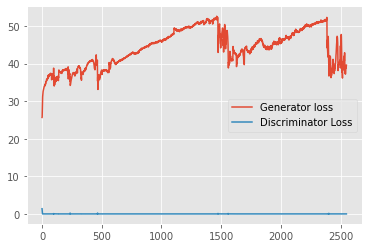

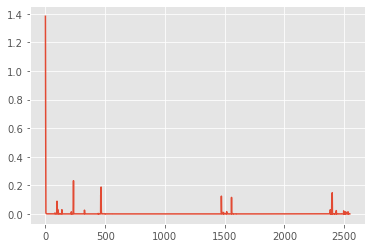

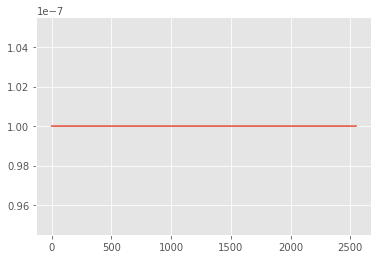

In [63]:
# plot and save the generator and discriminator loss
plt.figure()
losses_g_fixed = [i.detach() for i in losses_g]
losses_d_fixed = [i.detach() for i in losses_d]
sat_fixed = [i.detach() for i in sat]
plt.plot(losses_g_fixed, label='Generator loss')
plt.plot(losses_d_fixed, label='Discriminator Loss')
plt.legend()
plt.savefig('./outputs/loss_can2.png')
plt.figure()
plt.plot(losses_d_fixed, label='Discriminator Loss')
plt.savefig('./outputs/loss_d_can2.png')
plt.figure()
plt.plot(sat_fixed, label='Constraint satisfaction')
plt.savefig('./outputs/sat_can2.png')